In [1]:
import numpy as np
import os
import time

In [2]:
import keras

In [3]:
keras.__version__

'2.4.3'

In [4]:
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [5]:
#!pip install -q -U tensorflow-addons==0.11.2

### Utilities

In [6]:
from utils import verifyDir
from utils.networks import normalize, unnormalize, plot_data

### Dataset

In [7]:
from utils.MNIST import load_real_samples

### Discriminator & Generator

In [8]:
from utils.MNIST import define_discriminator
from utils.MNIST import define_generator

### Semi-Supervised GAN

In [9]:
from utils.networks import define_gan

### Selecting sub-set 

In [10]:
from utils.networks import select_supervised_samples, generate_real_samples
from utils.networks import generate_fake_samples, generate_latent_points

### Training

In [11]:
# train the generator and discriminator
def train(generator_model, unsupervised_model, supervised_model, gan_model, dataset, dataset_test, 
          latent_dim=100, n_epochs=20, n_batch=100, percent_samples=1.0):
    
    # select supervised dataset
    X_sup, y_sup = select_supervised_samples(dataset, percent_samples=percent_samples)
    print("Sup samples:", X_sup.shape, y_sup.shape)
    
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    print('n_epochs=%d, n_batch=%d, batch/epoch=%d, steps=%d' % (n_epochs, n_batch, bat_per_epo, n_steps))
    
    # manually enumerate epochs
    f_history = open(f"{LOG_PATH}SSL_GAN.csv", "w")
    f_history.write("step,generator_loss,unsupervised_real_loss,unsupervised_fake_loss,supervised_loss,supervised_acc,train_loss,test_loss,train_acc,test_acc\n")
    for step in range(1,n_steps+1):
#         t_start = time.time()
        # update supervised discriminator (c)
        [Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], n_batch)
        c_loss, c_acc = supervised_model.train_on_batch(Xsup_real, ysup_real)
        
        # update unsupervised discriminator (d)
        [X_real, _], y_real = generate_real_samples(dataset, n_batch)
        d_loss1 = unsupervised_model.train_on_batch(X_real, y_real)
        
        X_fake, y_fake = generate_fake_samples(generator_model, latent_dim, n_batch)
        d_loss2 = unsupervised_model.train_on_batch(X_fake, y_fake)
        
        # update generator (g)
        X_gan, y_gan = generate_latent_points(latent_dim, n_batch), np.ones((n_batch, 1))
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
#         t_total = (time.time() - t_start)
        # summarize loss on this batch
    
        # Train - Test
        X_train, y_train = dataset
        loss_train, acc_train = supervised_model.evaluate(X_train, y_train, verbose=0)

        # evaluate the test classifier model
        X_test, y_test = dataset_test
        loss_test, acc_test = supervised_model.evaluate(X_test, y_test, verbose=0)
        
        # Log
        print('step: %d | Train: G_Loss: %.3f, ' \
              'D_unsup_loss_real: %.3f, D_unsup_loss_fake: %.3f, ' \
              'D_sup_loss: %.3f, D_sup_acc: %.2f ' \
              'Train acc: %.3f Test acc: %.3f ' %(step, g_loss,
                                                d_loss1, d_loss2,
                                                c_loss, c_acc*100,
                                                 acc_train*100, acc_test*100))#, end = '\r')
        f_history.write(f"{step},{g_loss},{d_loss1},{d_loss2},{c_loss},{c_acc*100},{loss_train},{loss_test},{acc_train*100},{acc_test*100}\n")
        
        if step==1:
            plot_data(X_test, 0, "test", grid_size = [10, 10], OUT_PATH=LOG_PATH, gray=True)
        # evaluate the model performance every so often
        if (step) % (100) == 0 or step == 1:
            #summarize_performance(step, generator_model, supervised_model, latent_dim, dataset, dataset_test)
            # prepare fake examples
            X_generated, _ = generate_fake_samples(generator_model, latent_dim, n_samples=100)
            # scale from [-1,1] to [0,1]
            plot_data(X_generated, step, "generated", grid_size = [10, 10], OUT_PATH=LOG_PATH, gray=True)
            
            X_train, y_train = dataset
            _, acc = supervised_model.evaluate(X_train, y_train, verbose=0)
            print('Train Classifier Accuracy: %.3f%%\n' % (acc * 100))
            
            # evaluate the test classifier model
            X_test, y_test = dataset_test
            _, acc = supervised_model.evaluate(X_test, y_test, verbose=0)
            print('Test Classifier Accuracy: %.3f%%\n' % (acc * 100))
            # save the generator model
            filename2 = f'{LOG_PATH}generator_model_{step}.h5'
            generator_model.save(filename2)
            # save the classifier model
            filename3 = f'{LOG_PATH}supervised_model_{step}.h5'
            supervised_model.save(filename3)
            print('>Saving models Generator: %s and Supervised: %s' % (filename2, filename3))
    
    f_history.close()

### Parameters

In [12]:
input_shape = (28, 28, 1)
num_classes = 10

# learning rate
learning_rate = 2e-4

labeled_rate = 1/600
labeled_samples = 60000*labeled_rate

In [13]:
LOG_PATH = f"Logs/SSGAN_MNIST/Classifier_{int(labeled_samples)}/"
verifyDir(LOG_PATH)

### Creating Models

In [14]:
# create the discriminator models
unsupervised_model, supervised_model = define_discriminator(in_shape=input_shape, n_classes=num_classes, learning_rate = learning_rate)
# create the generator
generator_model = define_generator(latent_dim=100)
# create the gan
gan_model = define_gan(generator_model, unsupervised_model, learning_rate = learning_rate)

In [15]:
supervised_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       1280      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         147584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 4, 4, 128)         0     

In [16]:
gan_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       2622

### Loading Dataset

In [17]:
# load image data
dataset, dataset_test = load_real_samples()

(60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


### Training

In [18]:
train(generator_model, unsupervised_model, supervised_model, gan_model, 
      dataset, dataset_test, latent_dim=100, 
      n_epochs=20, n_batch=128, percent_samples=labeled_rate)

Sup samples: (94, 28, 28, 1) (94,)
n_epochs=20, n_batch=128, batch/epoch=468, steps=9360
step: 1 | Train: G_Loss: 0.095, D_unsup_loss_real: 0.096, D_unsup_loss_fake: 2.399, D_sup_loss: 2.300, D_sup_acc: 8.59 Train acc: 8.728 Test acc: 8.250 
Train Classifier Accuracy: 8.728%

Test Classifier Accuracy: 8.250%

>Saving models Generator: Logs/SSGAN_MNIST/Classifier_100/generator_model_1.h5 and Supervised: Logs/SSGAN_MNIST/Classifier_100/supervised_model_1.h5
step: 2 | Train: G_Loss: 0.096, D_unsup_loss_real: 0.094, D_unsup_loss_fake: 2.397, D_sup_loss: 2.293, D_sup_acc: 8.28 Train acc: 10.947 Test acc: 10.590 
step: 3 | Train: G_Loss: 0.096, D_unsup_loss_real: 0.092, D_unsup_loss_fake: 2.396, D_sup_loss: 2.285, D_sup_acc: 10.64 Train acc: 14.052 Test acc: 13.840 
step: 4 | Train: G_Loss: 0.096, D_unsup_loss_real: 0.091, D_unsup_loss_fake: 2.396, D_sup_loss: 2.271, D_sup_acc: 13.82 Train acc: 19.248 Test acc: 19.900 
step: 5 | Train: G_Loss: 0.096, D_unsup_loss_real: 0.089, D_unsup_loss_fa

step: 52 | Train: G_Loss: 0.846, D_unsup_loss_real: 0.893, D_unsup_loss_fake: 1.240, D_sup_loss: 0.735, D_sup_acc: 77.57 Train acc: 75.312 Test acc: 76.620 
step: 53 | Train: G_Loss: 0.844, D_unsup_loss_real: 0.850, D_unsup_loss_fake: 1.453, D_sup_loss: 0.766, D_sup_acc: 76.83 Train acc: 75.478 Test acc: 76.090 
step: 54 | Train: G_Loss: 0.943, D_unsup_loss_real: 0.823, D_unsup_loss_fake: 1.181, D_sup_loss: 0.744, D_sup_acc: 76.32 Train acc: 76.342 Test acc: 76.950 
step: 55 | Train: G_Loss: 0.902, D_unsup_loss_real: 0.921, D_unsup_loss_fake: 1.224, D_sup_loss: 0.723, D_sup_acc: 77.17 Train acc: 76.602 Test acc: 77.160 
step: 56 | Train: G_Loss: 0.777, D_unsup_loss_real: 1.014, D_unsup_loss_fake: 1.187, D_sup_loss: 0.720, D_sup_acc: 77.40 Train acc: 76.740 Test acc: 77.420 
step: 57 | Train: G_Loss: 0.921, D_unsup_loss_real: 0.787, D_unsup_loss_fake: 1.240, D_sup_loss: 0.709, D_sup_acc: 77.68 Train acc: 76.893 Test acc: 77.810 
step: 58 | Train: G_Loss: 0.815, D_unsup_loss_real: 0.905,

step: 103 | Train: G_Loss: 0.788, D_unsup_loss_real: 0.834, D_unsup_loss_fake: 0.943, D_sup_loss: 0.743, D_sup_acc: 78.52 Train acc: 77.152 Test acc: 78.310 
step: 104 | Train: G_Loss: 0.779, D_unsup_loss_real: 0.794, D_unsup_loss_fake: 1.001, D_sup_loss: 0.747, D_sup_acc: 78.52 Train acc: 77.398 Test acc: 78.380 
step: 105 | Train: G_Loss: 0.792, D_unsup_loss_real: 0.820, D_unsup_loss_fake: 0.945, D_sup_loss: 0.740, D_sup_acc: 78.60 Train acc: 77.458 Test acc: 78.570 
step: 106 | Train: G_Loss: 0.839, D_unsup_loss_real: 0.853, D_unsup_loss_fake: 0.910, D_sup_loss: 0.736, D_sup_acc: 78.78 Train acc: 77.398 Test acc: 78.550 
step: 107 | Train: G_Loss: 0.807, D_unsup_loss_real: 0.790, D_unsup_loss_fake: 0.957, D_sup_loss: 0.736, D_sup_acc: 78.75 Train acc: 77.452 Test acc: 78.650 
step: 108 | Train: G_Loss: 0.747, D_unsup_loss_real: 0.815, D_unsup_loss_fake: 0.987, D_sup_loss: 0.737, D_sup_acc: 78.87 Train acc: 77.197 Test acc: 78.190 
step: 109 | Train: G_Loss: 0.770, D_unsup_loss_real:

step: 155 | Train: G_Loss: 0.850, D_unsup_loss_real: 0.791, D_unsup_loss_fake: 0.882, D_sup_loss: 0.687, D_sup_acc: 79.70 Train acc: 78.352 Test acc: 79.560 
step: 156 | Train: G_Loss: 0.802, D_unsup_loss_real: 0.819, D_unsup_loss_fake: 0.827, D_sup_loss: 0.682, D_sup_acc: 79.79 Train acc: 78.383 Test acc: 79.580 
step: 157 | Train: G_Loss: 0.806, D_unsup_loss_real: 0.713, D_unsup_loss_fake: 0.840, D_sup_loss: 0.682, D_sup_acc: 79.83 Train acc: 78.558 Test acc: 80.010 
step: 158 | Train: G_Loss: 0.772, D_unsup_loss_real: 0.751, D_unsup_loss_fake: 0.818, D_sup_loss: 0.675, D_sup_acc: 80.24 Train acc: 78.433 Test acc: 79.950 
step: 159 | Train: G_Loss: 0.859, D_unsup_loss_real: 0.746, D_unsup_loss_fake: 0.858, D_sup_loss: 0.677, D_sup_acc: 80.19 Train acc: 78.483 Test acc: 79.940 
step: 160 | Train: G_Loss: 0.828, D_unsup_loss_real: 0.770, D_unsup_loss_fake: 0.912, D_sup_loss: 0.675, D_sup_acc: 80.18 Train acc: 78.475 Test acc: 79.850 
step: 161 | Train: G_Loss: 0.798, D_unsup_loss_real:

step: 206 | Train: G_Loss: 0.835, D_unsup_loss_real: 0.741, D_unsup_loss_fake: 0.880, D_sup_loss: 0.635, D_sup_acc: 80.96 Train acc: 79.812 Test acc: 81.110 
step: 207 | Train: G_Loss: 0.925, D_unsup_loss_real: 0.720, D_unsup_loss_fake: 0.791, D_sup_loss: 0.626, D_sup_acc: 81.34 Train acc: 79.763 Test acc: 81.250 
step: 208 | Train: G_Loss: 0.855, D_unsup_loss_real: 0.711, D_unsup_loss_fake: 0.799, D_sup_loss: 0.624, D_sup_acc: 81.48 Train acc: 79.843 Test acc: 81.160 
step: 209 | Train: G_Loss: 0.805, D_unsup_loss_real: 0.740, D_unsup_loss_fake: 0.836, D_sup_loss: 0.622, D_sup_acc: 81.39 Train acc: 79.960 Test acc: 81.240 
step: 210 | Train: G_Loss: 0.865, D_unsup_loss_real: 0.714, D_unsup_loss_fake: 0.785, D_sup_loss: 0.621, D_sup_acc: 81.48 Train acc: 79.852 Test acc: 81.070 
step: 211 | Train: G_Loss: 0.813, D_unsup_loss_real: 0.746, D_unsup_loss_fake: 0.815, D_sup_loss: 0.621, D_sup_acc: 81.30 Train acc: 79.788 Test acc: 81.130 
step: 212 | Train: G_Loss: 0.860, D_unsup_loss_real:

step: 258 | Train: G_Loss: 0.883, D_unsup_loss_real: 0.625, D_unsup_loss_fake: 0.766, D_sup_loss: 0.575, D_sup_acc: 82.42 Train acc: 81.052 Test acc: 82.320 
step: 259 | Train: G_Loss: 0.936, D_unsup_loss_real: 0.695, D_unsup_loss_fake: 0.820, D_sup_loss: 0.574, D_sup_acc: 82.54 Train acc: 80.947 Test acc: 82.360 
step: 260 | Train: G_Loss: 0.900, D_unsup_loss_real: 0.709, D_unsup_loss_fake: 0.727, D_sup_loss: 0.575, D_sup_acc: 82.58 Train acc: 80.988 Test acc: 82.310 
step: 261 | Train: G_Loss: 0.891, D_unsup_loss_real: 0.734, D_unsup_loss_fake: 0.822, D_sup_loss: 0.574, D_sup_acc: 82.53 Train acc: 81.213 Test acc: 82.440 
step: 262 | Train: G_Loss: 0.945, D_unsup_loss_real: 0.659, D_unsup_loss_fake: 0.786, D_sup_loss: 0.571, D_sup_acc: 82.65 Train acc: 80.865 Test acc: 82.200 
step: 263 | Train: G_Loss: 0.901, D_unsup_loss_real: 0.752, D_unsup_loss_fake: 0.764, D_sup_loss: 0.577, D_sup_acc: 82.42 Train acc: 80.998 Test acc: 82.510 
step: 264 | Train: G_Loss: 0.918, D_unsup_loss_real:

step: 309 | Train: G_Loss: 0.925, D_unsup_loss_real: 0.675, D_unsup_loss_fake: 0.810, D_sup_loss: 0.531, D_sup_acc: 83.65 Train acc: 82.530 Test acc: 83.840 
step: 310 | Train: G_Loss: 0.991, D_unsup_loss_real: 0.707, D_unsup_loss_fake: 0.739, D_sup_loss: 0.526, D_sup_acc: 84.04 Train acc: 82.578 Test acc: 83.770 
step: 311 | Train: G_Loss: 0.921, D_unsup_loss_real: 0.719, D_unsup_loss_fake: 0.783, D_sup_loss: 0.529, D_sup_acc: 83.98 Train acc: 82.637 Test acc: 83.710 
step: 312 | Train: G_Loss: 0.904, D_unsup_loss_real: 0.735, D_unsup_loss_fake: 0.737, D_sup_loss: 0.525, D_sup_acc: 83.92 Train acc: 82.472 Test acc: 83.650 
step: 313 | Train: G_Loss: 0.983, D_unsup_loss_real: 0.594, D_unsup_loss_fake: 0.739, D_sup_loss: 0.526, D_sup_acc: 83.86 Train acc: 82.103 Test acc: 83.290 
step: 314 | Train: G_Loss: 0.879, D_unsup_loss_real: 0.721, D_unsup_loss_fake: 0.754, D_sup_loss: 0.528, D_sup_acc: 83.50 Train acc: 82.213 Test acc: 83.460 
step: 315 | Train: G_Loss: 0.956, D_unsup_loss_real:

step: 361 | Train: G_Loss: 0.891, D_unsup_loss_real: 0.698, D_unsup_loss_fake: 0.759, D_sup_loss: 0.493, D_sup_acc: 85.08 Train acc: 83.708 Test acc: 84.640 
step: 362 | Train: G_Loss: 0.982, D_unsup_loss_real: 0.643, D_unsup_loss_fake: 0.767, D_sup_loss: 0.498, D_sup_acc: 84.83 Train acc: 83.430 Test acc: 84.620 
step: 363 | Train: G_Loss: 0.916, D_unsup_loss_real: 0.674, D_unsup_loss_fake: 0.702, D_sup_loss: 0.499, D_sup_acc: 84.80 Train acc: 83.728 Test acc: 84.880 
step: 364 | Train: G_Loss: 0.955, D_unsup_loss_real: 0.592, D_unsup_loss_fake: 0.690, D_sup_loss: 0.492, D_sup_acc: 85.06 Train acc: 83.692 Test acc: 84.660 
step: 365 | Train: G_Loss: 0.932, D_unsup_loss_real: 0.715, D_unsup_loss_fake: 0.733, D_sup_loss: 0.493, D_sup_acc: 84.85 Train acc: 84.145 Test acc: 85.490 
step: 366 | Train: G_Loss: 0.957, D_unsup_loss_real: 0.692, D_unsup_loss_fake: 0.832, D_sup_loss: 0.482, D_sup_acc: 85.67 Train acc: 84.525 Test acc: 85.770 
step: 367 | Train: G_Loss: 0.932, D_unsup_loss_real:

step: 412 | Train: G_Loss: 0.970, D_unsup_loss_real: 0.655, D_unsup_loss_fake: 0.698, D_sup_loss: 0.460, D_sup_acc: 86.47 Train acc: 85.628 Test acc: 86.420 
step: 413 | Train: G_Loss: 0.877, D_unsup_loss_real: 0.724, D_unsup_loss_fake: 0.797, D_sup_loss: 0.458, D_sup_acc: 86.59 Train acc: 85.957 Test acc: 86.690 
step: 414 | Train: G_Loss: 1.015, D_unsup_loss_real: 0.669, D_unsup_loss_fake: 0.770, D_sup_loss: 0.452, D_sup_acc: 86.86 Train acc: 85.752 Test acc: 86.730 
step: 415 | Train: G_Loss: 0.929, D_unsup_loss_real: 0.786, D_unsup_loss_fake: 0.723, D_sup_loss: 0.451, D_sup_acc: 86.90 Train acc: 85.932 Test acc: 86.850 
step: 416 | Train: G_Loss: 0.913, D_unsup_loss_real: 0.646, D_unsup_loss_fake: 0.820, D_sup_loss: 0.449, D_sup_acc: 87.02 Train acc: 86.008 Test acc: 86.960 
step: 417 | Train: G_Loss: 0.914, D_unsup_loss_real: 0.713, D_unsup_loss_fake: 0.751, D_sup_loss: 0.444, D_sup_acc: 87.11 Train acc: 86.015 Test acc: 87.060 
step: 418 | Train: G_Loss: 0.992, D_unsup_loss_real:

step: 464 | Train: G_Loss: 1.004, D_unsup_loss_real: 0.621, D_unsup_loss_fake: 0.739, D_sup_loss: 0.421, D_sup_acc: 88.14 Train acc: 86.932 Test acc: 87.860 
step: 465 | Train: G_Loss: 0.944, D_unsup_loss_real: 0.698, D_unsup_loss_fake: 0.753, D_sup_loss: 0.415, D_sup_acc: 88.01 Train acc: 86.493 Test acc: 87.280 
step: 466 | Train: G_Loss: 0.921, D_unsup_loss_real: 0.660, D_unsup_loss_fake: 0.746, D_sup_loss: 0.425, D_sup_acc: 87.44 Train acc: 86.607 Test acc: 87.400 
step: 467 | Train: G_Loss: 0.914, D_unsup_loss_real: 0.679, D_unsup_loss_fake: 0.776, D_sup_loss: 0.423, D_sup_acc: 87.56 Train acc: 86.952 Test acc: 87.690 
step: 468 | Train: G_Loss: 0.956, D_unsup_loss_real: 0.701, D_unsup_loss_fake: 0.705, D_sup_loss: 0.416, D_sup_acc: 87.85 Train acc: 87.200 Test acc: 87.990 
step: 469 | Train: G_Loss: 0.921, D_unsup_loss_real: 0.637, D_unsup_loss_fake: 0.737, D_sup_loss: 0.414, D_sup_acc: 88.14 Train acc: 87.357 Test acc: 88.290 
step: 470 | Train: G_Loss: 0.924, D_unsup_loss_real:

step: 515 | Train: G_Loss: 0.986, D_unsup_loss_real: 0.729, D_unsup_loss_fake: 0.814, D_sup_loss: 0.386, D_sup_acc: 89.36 Train acc: 88.115 Test acc: 89.090 
step: 516 | Train: G_Loss: 1.011, D_unsup_loss_real: 0.621, D_unsup_loss_fake: 0.701, D_sup_loss: 0.388, D_sup_acc: 89.23 Train acc: 87.758 Test acc: 88.700 
step: 517 | Train: G_Loss: 0.967, D_unsup_loss_real: 0.648, D_unsup_loss_fake: 0.647, D_sup_loss: 0.391, D_sup_acc: 88.84 Train acc: 87.762 Test acc: 88.660 
step: 518 | Train: G_Loss: 0.963, D_unsup_loss_real: 0.669, D_unsup_loss_fake: 0.682, D_sup_loss: 0.391, D_sup_acc: 88.80 Train acc: 87.782 Test acc: 88.620 
step: 519 | Train: G_Loss: 0.931, D_unsup_loss_real: 0.658, D_unsup_loss_fake: 0.731, D_sup_loss: 0.389, D_sup_acc: 88.76 Train acc: 87.955 Test acc: 88.820 
step: 520 | Train: G_Loss: 0.940, D_unsup_loss_real: 0.630, D_unsup_loss_fake: 0.800, D_sup_loss: 0.384, D_sup_acc: 88.96 Train acc: 88.105 Test acc: 88.800 
step: 521 | Train: G_Loss: 0.993, D_unsup_loss_real:

step: 567 | Train: G_Loss: 0.922, D_unsup_loss_real: 0.687, D_unsup_loss_fake: 0.693, D_sup_loss: 0.364, D_sup_acc: 89.84 Train acc: 88.827 Test acc: 89.830 
step: 568 | Train: G_Loss: 0.917, D_unsup_loss_real: 0.646, D_unsup_loss_fake: 0.816, D_sup_loss: 0.357, D_sup_acc: 89.96 Train acc: 88.765 Test acc: 89.670 
step: 569 | Train: G_Loss: 0.929, D_unsup_loss_real: 0.671, D_unsup_loss_fake: 0.800, D_sup_loss: 0.357, D_sup_acc: 89.80 Train acc: 88.375 Test acc: 89.150 
step: 570 | Train: G_Loss: 0.897, D_unsup_loss_real: 0.654, D_unsup_loss_fake: 0.704, D_sup_loss: 0.371, D_sup_acc: 89.29 Train acc: 88.603 Test acc: 89.370 
step: 571 | Train: G_Loss: 0.992, D_unsup_loss_real: 0.751, D_unsup_loss_fake: 0.747, D_sup_loss: 0.362, D_sup_acc: 89.50 Train acc: 88.922 Test acc: 89.930 
step: 572 | Train: G_Loss: 1.005, D_unsup_loss_real: 0.640, D_unsup_loss_fake: 0.711, D_sup_loss: 0.352, D_sup_acc: 90.06 Train acc: 88.818 Test acc: 89.600 
step: 573 | Train: G_Loss: 0.938, D_unsup_loss_real:

step: 618 | Train: G_Loss: 0.871, D_unsup_loss_real: 0.655, D_unsup_loss_fake: 0.726, D_sup_loss: 0.343, D_sup_acc: 90.14 Train acc: 89.377 Test acc: 90.090 
step: 619 | Train: G_Loss: 0.934, D_unsup_loss_real: 0.675, D_unsup_loss_fake: 0.787, D_sup_loss: 0.339, D_sup_acc: 90.22 Train acc: 89.102 Test acc: 89.790 
step: 620 | Train: G_Loss: 0.908, D_unsup_loss_real: 0.694, D_unsup_loss_fake: 0.846, D_sup_loss: 0.347, D_sup_acc: 89.92 Train acc: 88.838 Test acc: 89.550 
step: 621 | Train: G_Loss: 0.951, D_unsup_loss_real: 0.646, D_unsup_loss_fake: 0.715, D_sup_loss: 0.350, D_sup_acc: 89.68 Train acc: 89.028 Test acc: 89.850 
step: 622 | Train: G_Loss: 0.960, D_unsup_loss_real: 0.592, D_unsup_loss_fake: 0.681, D_sup_loss: 0.345, D_sup_acc: 89.98 Train acc: 88.855 Test acc: 89.590 
step: 623 | Train: G_Loss: 1.038, D_unsup_loss_real: 0.693, D_unsup_loss_fake: 0.757, D_sup_loss: 0.347, D_sup_acc: 89.72 Train acc: 88.972 Test acc: 89.780 
step: 624 | Train: G_Loss: 0.971, D_unsup_loss_real:

step: 670 | Train: G_Loss: 1.063, D_unsup_loss_real: 0.629, D_unsup_loss_fake: 0.723, D_sup_loss: 0.311, D_sup_acc: 91.37 Train acc: 90.673 Test acc: 91.470 
step: 671 | Train: G_Loss: 0.987, D_unsup_loss_real: 0.664, D_unsup_loss_fake: 0.703, D_sup_loss: 0.309, D_sup_acc: 91.58 Train acc: 90.555 Test acc: 91.350 
step: 672 | Train: G_Loss: 1.021, D_unsup_loss_real: 0.720, D_unsup_loss_fake: 0.677, D_sup_loss: 0.310, D_sup_acc: 91.46 Train acc: 90.305 Test acc: 91.200 
step: 673 | Train: G_Loss: 1.010, D_unsup_loss_real: 0.731, D_unsup_loss_fake: 0.739, D_sup_loss: 0.312, D_sup_acc: 91.31 Train acc: 90.262 Test acc: 90.910 
step: 674 | Train: G_Loss: 1.048, D_unsup_loss_real: 0.617, D_unsup_loss_fake: 0.685, D_sup_loss: 0.314, D_sup_acc: 91.02 Train acc: 90.525 Test acc: 91.190 
step: 675 | Train: G_Loss: 1.025, D_unsup_loss_real: 0.607, D_unsup_loss_fake: 0.691, D_sup_loss: 0.310, D_sup_acc: 91.30 Train acc: 90.413 Test acc: 91.200 
step: 676 | Train: G_Loss: 0.970, D_unsup_loss_real:

step: 721 | Train: G_Loss: 1.030, D_unsup_loss_real: 0.703, D_unsup_loss_fake: 0.674, D_sup_loss: 0.297, D_sup_acc: 91.59 Train acc: 90.827 Test acc: 91.600 
step: 722 | Train: G_Loss: 1.047, D_unsup_loss_real: 0.603, D_unsup_loss_fake: 0.718, D_sup_loss: 0.299, D_sup_acc: 91.71 Train acc: 90.457 Test acc: 91.260 
step: 723 | Train: G_Loss: 1.082, D_unsup_loss_real: 0.629, D_unsup_loss_fake: 0.697, D_sup_loss: 0.305, D_sup_acc: 91.37 Train acc: 90.815 Test acc: 91.590 
step: 724 | Train: G_Loss: 1.052, D_unsup_loss_real: 0.681, D_unsup_loss_fake: 0.638, D_sup_loss: 0.298, D_sup_acc: 91.70 Train acc: 90.587 Test acc: 91.370 
step: 725 | Train: G_Loss: 0.940, D_unsup_loss_real: 0.710, D_unsup_loss_fake: 0.679, D_sup_loss: 0.299, D_sup_acc: 91.48 Train acc: 90.568 Test acc: 91.310 
step: 726 | Train: G_Loss: 0.994, D_unsup_loss_real: 0.641, D_unsup_loss_fake: 0.636, D_sup_loss: 0.298, D_sup_acc: 91.42 Train acc: 90.553 Test acc: 91.290 
step: 727 | Train: G_Loss: 0.971, D_unsup_loss_real:

step: 773 | Train: G_Loss: 1.062, D_unsup_loss_real: 0.597, D_unsup_loss_fake: 0.720, D_sup_loss: 0.286, D_sup_acc: 91.86 Train acc: 91.063 Test acc: 91.750 
step: 774 | Train: G_Loss: 1.060, D_unsup_loss_real: 0.707, D_unsup_loss_fake: 0.676, D_sup_loss: 0.289, D_sup_acc: 91.85 Train acc: 91.232 Test acc: 91.860 
step: 775 | Train: G_Loss: 1.032, D_unsup_loss_real: 0.608, D_unsup_loss_fake: 0.732, D_sup_loss: 0.287, D_sup_acc: 91.96 Train acc: 91.362 Test acc: 92.090 
step: 776 | Train: G_Loss: 1.072, D_unsup_loss_real: 0.642, D_unsup_loss_fake: 0.674, D_sup_loss: 0.280, D_sup_acc: 92.19 Train acc: 91.238 Test acc: 91.900 
step: 777 | Train: G_Loss: 1.078, D_unsup_loss_real: 0.679, D_unsup_loss_fake: 0.750, D_sup_loss: 0.282, D_sup_acc: 92.00 Train acc: 91.075 Test acc: 91.850 
step: 778 | Train: G_Loss: 1.116, D_unsup_loss_real: 0.686, D_unsup_loss_fake: 0.640, D_sup_loss: 0.286, D_sup_acc: 91.95 Train acc: 91.177 Test acc: 92.020 
step: 779 | Train: G_Loss: 1.054, D_unsup_loss_real:

step: 824 | Train: G_Loss: 1.040, D_unsup_loss_real: 0.639, D_unsup_loss_fake: 0.623, D_sup_loss: 0.279, D_sup_acc: 92.18 Train acc: 91.245 Test acc: 92.050 
step: 825 | Train: G_Loss: 1.014, D_unsup_loss_real: 0.690, D_unsup_loss_fake: 0.640, D_sup_loss: 0.282, D_sup_acc: 92.15 Train acc: 91.263 Test acc: 91.970 
step: 826 | Train: G_Loss: 1.008, D_unsup_loss_real: 0.678, D_unsup_loss_fake: 0.760, D_sup_loss: 0.283, D_sup_acc: 92.07 Train acc: 91.317 Test acc: 91.930 
step: 827 | Train: G_Loss: 0.985, D_unsup_loss_real: 0.684, D_unsup_loss_fake: 0.737, D_sup_loss: 0.281, D_sup_acc: 92.02 Train acc: 91.365 Test acc: 92.060 
step: 828 | Train: G_Loss: 1.057, D_unsup_loss_real: 0.687, D_unsup_loss_fake: 0.691, D_sup_loss: 0.281, D_sup_acc: 92.16 Train acc: 91.255 Test acc: 91.980 
step: 829 | Train: G_Loss: 1.002, D_unsup_loss_real: 0.599, D_unsup_loss_fake: 0.646, D_sup_loss: 0.282, D_sup_acc: 92.08 Train acc: 91.390 Test acc: 92.010 
step: 830 | Train: G_Loss: 1.008, D_unsup_loss_real:

step: 876 | Train: G_Loss: 1.065, D_unsup_loss_real: 0.607, D_unsup_loss_fake: 0.697, D_sup_loss: 0.266, D_sup_acc: 92.65 Train acc: 91.952 Test acc: 92.490 
step: 877 | Train: G_Loss: 1.026, D_unsup_loss_real: 0.663, D_unsup_loss_fake: 0.650, D_sup_loss: 0.264, D_sup_acc: 92.58 Train acc: 91.908 Test acc: 92.540 
step: 878 | Train: G_Loss: 1.082, D_unsup_loss_real: 0.620, D_unsup_loss_fake: 0.645, D_sup_loss: 0.265, D_sup_acc: 92.63 Train acc: 91.950 Test acc: 92.520 
step: 879 | Train: G_Loss: 1.003, D_unsup_loss_real: 0.661, D_unsup_loss_fake: 0.627, D_sup_loss: 0.265, D_sup_acc: 92.61 Train acc: 91.883 Test acc: 92.420 
step: 880 | Train: G_Loss: 0.997, D_unsup_loss_real: 0.663, D_unsup_loss_fake: 0.709, D_sup_loss: 0.265, D_sup_acc: 92.52 Train acc: 91.850 Test acc: 92.420 
step: 881 | Train: G_Loss: 1.080, D_unsup_loss_real: 0.652, D_unsup_loss_fake: 0.692, D_sup_loss: 0.265, D_sup_acc: 92.52 Train acc: 91.900 Test acc: 92.490 
step: 882 | Train: G_Loss: 0.979, D_unsup_loss_real:

step: 927 | Train: G_Loss: 1.044, D_unsup_loss_real: 0.621, D_unsup_loss_fake: 0.651, D_sup_loss: 0.256, D_sup_acc: 92.95 Train acc: 92.250 Test acc: 92.890 
step: 928 | Train: G_Loss: 1.015, D_unsup_loss_real: 0.637, D_unsup_loss_fake: 0.752, D_sup_loss: 0.255, D_sup_acc: 92.98 Train acc: 92.310 Test acc: 92.950 
step: 929 | Train: G_Loss: 1.015, D_unsup_loss_real: 0.595, D_unsup_loss_fake: 0.606, D_sup_loss: 0.257, D_sup_acc: 93.04 Train acc: 92.355 Test acc: 93.070 
step: 930 | Train: G_Loss: 1.026, D_unsup_loss_real: 0.610, D_unsup_loss_fake: 0.635, D_sup_loss: 0.254, D_sup_acc: 93.16 Train acc: 92.457 Test acc: 93.120 
step: 931 | Train: G_Loss: 1.038, D_unsup_loss_real: 0.700, D_unsup_loss_fake: 0.715, D_sup_loss: 0.253, D_sup_acc: 93.21 Train acc: 92.390 Test acc: 93.050 
step: 932 | Train: G_Loss: 1.056, D_unsup_loss_real: 0.689, D_unsup_loss_fake: 0.677, D_sup_loss: 0.256, D_sup_acc: 93.14 Train acc: 92.395 Test acc: 93.040 
step: 933 | Train: G_Loss: 1.047, D_unsup_loss_real:

step: 979 | Train: G_Loss: 1.065, D_unsup_loss_real: 0.606, D_unsup_loss_fake: 0.598, D_sup_loss: 0.245, D_sup_acc: 93.29 Train acc: 92.810 Test acc: 93.230 
step: 980 | Train: G_Loss: 1.085, D_unsup_loss_real: 0.697, D_unsup_loss_fake: 0.696, D_sup_loss: 0.243, D_sup_acc: 93.32 Train acc: 92.765 Test acc: 93.230 
step: 981 | Train: G_Loss: 1.058, D_unsup_loss_real: 0.603, D_unsup_loss_fake: 0.695, D_sup_loss: 0.242, D_sup_acc: 93.32 Train acc: 92.737 Test acc: 93.110 
step: 982 | Train: G_Loss: 1.048, D_unsup_loss_real: 0.628, D_unsup_loss_fake: 0.717, D_sup_loss: 0.245, D_sup_acc: 93.20 Train acc: 92.837 Test acc: 93.440 
step: 983 | Train: G_Loss: 1.008, D_unsup_loss_real: 0.604, D_unsup_loss_fake: 0.618, D_sup_loss: 0.241, D_sup_acc: 93.52 Train acc: 92.797 Test acc: 93.420 
step: 984 | Train: G_Loss: 1.043, D_unsup_loss_real: 0.563, D_unsup_loss_fake: 0.634, D_sup_loss: 0.239, D_sup_acc: 93.50 Train acc: 92.683 Test acc: 93.290 
step: 985 | Train: G_Loss: 1.138, D_unsup_loss_real:

step: 1030 | Train: G_Loss: 1.104, D_unsup_loss_real: 0.594, D_unsup_loss_fake: 0.707, D_sup_loss: 0.234, D_sup_acc: 93.66 Train acc: 93.068 Test acc: 93.740 
step: 1031 | Train: G_Loss: 1.014, D_unsup_loss_real: 0.675, D_unsup_loss_fake: 0.621, D_sup_loss: 0.233, D_sup_acc: 93.82 Train acc: 93.025 Test acc: 93.600 
step: 1032 | Train: G_Loss: 1.050, D_unsup_loss_real: 0.589, D_unsup_loss_fake: 0.634, D_sup_loss: 0.238, D_sup_acc: 93.68 Train acc: 93.080 Test acc: 93.700 
step: 1033 | Train: G_Loss: 1.056, D_unsup_loss_real: 0.622, D_unsup_loss_fake: 0.684, D_sup_loss: 0.234, D_sup_acc: 93.78 Train acc: 93.065 Test acc: 93.620 
step: 1034 | Train: G_Loss: 1.087, D_unsup_loss_real: 0.646, D_unsup_loss_fake: 0.739, D_sup_loss: 0.237, D_sup_acc: 93.70 Train acc: 93.115 Test acc: 93.630 
step: 1035 | Train: G_Loss: 1.106, D_unsup_loss_real: 0.654, D_unsup_loss_fake: 0.650, D_sup_loss: 0.232, D_sup_acc: 93.71 Train acc: 93.217 Test acc: 93.780 
step: 1036 | Train: G_Loss: 1.018, D_unsup_los

step: 1082 | Train: G_Loss: 1.090, D_unsup_loss_real: 0.692, D_unsup_loss_fake: 0.684, D_sup_loss: 0.227, D_sup_acc: 93.68 Train acc: 93.037 Test acc: 93.560 
step: 1083 | Train: G_Loss: 1.208, D_unsup_loss_real: 0.614, D_unsup_loss_fake: 0.747, D_sup_loss: 0.233, D_sup_acc: 93.64 Train acc: 93.153 Test acc: 93.670 
step: 1084 | Train: G_Loss: 1.126, D_unsup_loss_real: 0.691, D_unsup_loss_fake: 0.663, D_sup_loss: 0.231, D_sup_acc: 93.75 Train acc: 93.140 Test acc: 93.590 
step: 1085 | Train: G_Loss: 1.066, D_unsup_loss_real: 0.655, D_unsup_loss_fake: 0.602, D_sup_loss: 0.230, D_sup_acc: 93.67 Train acc: 93.062 Test acc: 93.560 
step: 1086 | Train: G_Loss: 1.041, D_unsup_loss_real: 0.718, D_unsup_loss_fake: 0.646, D_sup_loss: 0.235, D_sup_acc: 93.64 Train acc: 93.060 Test acc: 93.590 
step: 1087 | Train: G_Loss: 1.042, D_unsup_loss_real: 0.608, D_unsup_loss_fake: 0.645, D_sup_loss: 0.232, D_sup_acc: 93.67 Train acc: 93.320 Test acc: 93.910 
step: 1088 | Train: G_Loss: 0.949, D_unsup_los

step: 1133 | Train: G_Loss: 1.057, D_unsup_loss_real: 0.559, D_unsup_loss_fake: 0.554, D_sup_loss: 0.215, D_sup_acc: 94.26 Train acc: 93.660 Test acc: 94.200 
step: 1134 | Train: G_Loss: 1.067, D_unsup_loss_real: 0.668, D_unsup_loss_fake: 0.714, D_sup_loss: 0.214, D_sup_acc: 94.27 Train acc: 93.617 Test acc: 94.090 
step: 1135 | Train: G_Loss: 0.987, D_unsup_loss_real: 0.657, D_unsup_loss_fake: 0.675, D_sup_loss: 0.215, D_sup_acc: 94.16 Train acc: 93.705 Test acc: 94.290 
step: 1136 | Train: G_Loss: 1.089, D_unsup_loss_real: 0.674, D_unsup_loss_fake: 0.744, D_sup_loss: 0.213, D_sup_acc: 94.36 Train acc: 93.600 Test acc: 94.290 
step: 1137 | Train: G_Loss: 0.991, D_unsup_loss_real: 0.675, D_unsup_loss_fake: 0.687, D_sup_loss: 0.219, D_sup_acc: 94.36 Train acc: 93.408 Test acc: 94.010 
step: 1138 | Train: G_Loss: 1.136, D_unsup_loss_real: 0.673, D_unsup_loss_fake: 0.789, D_sup_loss: 0.223, D_sup_acc: 94.09 Train acc: 93.523 Test acc: 93.970 
step: 1139 | Train: G_Loss: 1.087, D_unsup_los

step: 1185 | Train: G_Loss: 1.036, D_unsup_loss_real: 0.615, D_unsup_loss_fake: 0.633, D_sup_loss: 0.220, D_sup_acc: 94.12 Train acc: 93.635 Test acc: 94.070 
step: 1186 | Train: G_Loss: 1.130, D_unsup_loss_real: 0.640, D_unsup_loss_fake: 0.747, D_sup_loss: 0.219, D_sup_acc: 94.14 Train acc: 93.580 Test acc: 94.010 
step: 1187 | Train: G_Loss: 1.121, D_unsup_loss_real: 0.594, D_unsup_loss_fake: 0.647, D_sup_loss: 0.220, D_sup_acc: 94.09 Train acc: 93.643 Test acc: 94.080 
step: 1188 | Train: G_Loss: 0.966, D_unsup_loss_real: 0.563, D_unsup_loss_fake: 0.620, D_sup_loss: 0.218, D_sup_acc: 94.15 Train acc: 93.688 Test acc: 94.150 
step: 1189 | Train: G_Loss: 1.081, D_unsup_loss_real: 0.614, D_unsup_loss_fake: 0.623, D_sup_loss: 0.217, D_sup_acc: 94.22 Train acc: 93.672 Test acc: 94.100 
step: 1190 | Train: G_Loss: 1.175, D_unsup_loss_real: 0.626, D_unsup_loss_fake: 0.646, D_sup_loss: 0.220, D_sup_acc: 94.17 Train acc: 93.682 Test acc: 94.100 
step: 1191 | Train: G_Loss: 1.123, D_unsup_los

step: 1236 | Train: G_Loss: 1.125, D_unsup_loss_real: 0.642, D_unsup_loss_fake: 0.676, D_sup_loss: 0.210, D_sup_acc: 94.55 Train acc: 94.037 Test acc: 94.360 
step: 1237 | Train: G_Loss: 1.107, D_unsup_loss_real: 0.635, D_unsup_loss_fake: 0.663, D_sup_loss: 0.210, D_sup_acc: 94.43 Train acc: 94.018 Test acc: 94.400 
step: 1238 | Train: G_Loss: 1.086, D_unsup_loss_real: 0.545, D_unsup_loss_fake: 0.603, D_sup_loss: 0.211, D_sup_acc: 94.47 Train acc: 94.185 Test acc: 94.520 
step: 1239 | Train: G_Loss: 1.088, D_unsup_loss_real: 0.655, D_unsup_loss_fake: 0.626, D_sup_loss: 0.207, D_sup_acc: 94.59 Train acc: 94.182 Test acc: 94.570 
step: 1240 | Train: G_Loss: 1.086, D_unsup_loss_real: 0.636, D_unsup_loss_fake: 0.656, D_sup_loss: 0.206, D_sup_acc: 94.64 Train acc: 94.093 Test acc: 94.440 
step: 1241 | Train: G_Loss: 1.045, D_unsup_loss_real: 0.550, D_unsup_loss_fake: 0.601, D_sup_loss: 0.206, D_sup_acc: 94.51 Train acc: 94.005 Test acc: 94.380 
step: 1242 | Train: G_Loss: 1.009, D_unsup_los

step: 1288 | Train: G_Loss: 1.086, D_unsup_loss_real: 0.625, D_unsup_loss_fake: 0.648, D_sup_loss: 0.204, D_sup_acc: 94.93 Train acc: 94.360 Test acc: 94.800 
step: 1289 | Train: G_Loss: 1.059, D_unsup_loss_real: 0.625, D_unsup_loss_fake: 0.603, D_sup_loss: 0.205, D_sup_acc: 94.87 Train acc: 94.465 Test acc: 94.920 
step: 1290 | Train: G_Loss: 0.990, D_unsup_loss_real: 0.627, D_unsup_loss_fake: 0.680, D_sup_loss: 0.199, D_sup_acc: 94.98 Train acc: 94.448 Test acc: 94.920 
step: 1291 | Train: G_Loss: 1.020, D_unsup_loss_real: 0.581, D_unsup_loss_fake: 0.666, D_sup_loss: 0.199, D_sup_acc: 94.98 Train acc: 94.448 Test acc: 94.820 
step: 1292 | Train: G_Loss: 1.076, D_unsup_loss_real: 0.643, D_unsup_loss_fake: 0.707, D_sup_loss: 0.196, D_sup_acc: 94.89 Train acc: 94.318 Test acc: 94.670 
step: 1293 | Train: G_Loss: 1.142, D_unsup_loss_real: 0.620, D_unsup_loss_fake: 0.593, D_sup_loss: 0.200, D_sup_acc: 94.74 Train acc: 94.317 Test acc: 94.660 
step: 1294 | Train: G_Loss: 1.087, D_unsup_los

step: 1339 | Train: G_Loss: 1.136, D_unsup_loss_real: 0.566, D_unsup_loss_fake: 0.744, D_sup_loss: 0.196, D_sup_acc: 94.91 Train acc: 94.387 Test acc: 94.900 
step: 1340 | Train: G_Loss: 1.160, D_unsup_loss_real: 0.619, D_unsup_loss_fake: 0.659, D_sup_loss: 0.198, D_sup_acc: 94.96 Train acc: 94.377 Test acc: 94.830 
step: 1341 | Train: G_Loss: 1.015, D_unsup_loss_real: 0.648, D_unsup_loss_fake: 0.532, D_sup_loss: 0.199, D_sup_acc: 94.90 Train acc: 94.440 Test acc: 94.830 
step: 1342 | Train: G_Loss: 1.025, D_unsup_loss_real: 0.631, D_unsup_loss_fake: 0.686, D_sup_loss: 0.196, D_sup_acc: 94.90 Train acc: 94.470 Test acc: 94.800 
step: 1343 | Train: G_Loss: 1.103, D_unsup_loss_real: 0.645, D_unsup_loss_fake: 0.744, D_sup_loss: 0.196, D_sup_acc: 94.87 Train acc: 94.498 Test acc: 94.770 
step: 1344 | Train: G_Loss: 1.074, D_unsup_loss_real: 0.661, D_unsup_loss_fake: 0.647, D_sup_loss: 0.196, D_sup_acc: 94.84 Train acc: 94.493 Test acc: 94.880 
step: 1345 | Train: G_Loss: 1.091, D_unsup_los

step: 1391 | Train: G_Loss: 1.185, D_unsup_loss_real: 0.642, D_unsup_loss_fake: 0.613, D_sup_loss: 0.200, D_sup_acc: 94.92 Train acc: 94.253 Test acc: 94.720 
step: 1392 | Train: G_Loss: 1.156, D_unsup_loss_real: 0.545, D_unsup_loss_fake: 0.556, D_sup_loss: 0.201, D_sup_acc: 94.79 Train acc: 94.210 Test acc: 94.660 
step: 1393 | Train: G_Loss: 1.132, D_unsup_loss_real: 0.584, D_unsup_loss_fake: 0.645, D_sup_loss: 0.202, D_sup_acc: 94.73 Train acc: 94.438 Test acc: 94.920 
step: 1394 | Train: G_Loss: 1.116, D_unsup_loss_real: 0.618, D_unsup_loss_fake: 0.619, D_sup_loss: 0.197, D_sup_acc: 94.98 Train acc: 94.427 Test acc: 94.920 
step: 1395 | Train: G_Loss: 1.120, D_unsup_loss_real: 0.614, D_unsup_loss_fake: 0.589, D_sup_loss: 0.196, D_sup_acc: 94.98 Train acc: 94.448 Test acc: 95.010 
step: 1396 | Train: G_Loss: 1.093, D_unsup_loss_real: 0.694, D_unsup_loss_fake: 0.622, D_sup_loss: 0.195, D_sup_acc: 95.07 Train acc: 94.450 Test acc: 94.970 
step: 1397 | Train: G_Loss: 1.047, D_unsup_los

step: 1442 | Train: G_Loss: 1.023, D_unsup_loss_real: 0.579, D_unsup_loss_fake: 0.662, D_sup_loss: 0.203, D_sup_acc: 94.96 Train acc: 94.435 Test acc: 94.870 
step: 1443 | Train: G_Loss: 1.093, D_unsup_loss_real: 0.717, D_unsup_loss_fake: 0.631, D_sup_loss: 0.200, D_sup_acc: 94.93 Train acc: 94.638 Test acc: 95.190 
step: 1444 | Train: G_Loss: 1.118, D_unsup_loss_real: 0.616, D_unsup_loss_fake: 0.692, D_sup_loss: 0.192, D_sup_acc: 95.25 Train acc: 94.637 Test acc: 95.170 
step: 1445 | Train: G_Loss: 1.145, D_unsup_loss_real: 0.650, D_unsup_loss_fake: 0.664, D_sup_loss: 0.190, D_sup_acc: 95.23 Train acc: 94.632 Test acc: 95.110 
step: 1446 | Train: G_Loss: 1.043, D_unsup_loss_real: 0.667, D_unsup_loss_fake: 0.693, D_sup_loss: 0.193, D_sup_acc: 95.17 Train acc: 94.482 Test acc: 95.040 
step: 1447 | Train: G_Loss: 1.024, D_unsup_loss_real: 0.629, D_unsup_loss_fake: 0.604, D_sup_loss: 0.193, D_sup_acc: 95.10 Train acc: 94.547 Test acc: 94.990 
step: 1448 | Train: G_Loss: 1.073, D_unsup_los

step: 1494 | Train: G_Loss: 1.088, D_unsup_loss_real: 0.595, D_unsup_loss_fake: 0.638, D_sup_loss: 0.196, D_sup_acc: 94.90 Train acc: 94.543 Test acc: 95.000 
step: 1495 | Train: G_Loss: 0.994, D_unsup_loss_real: 0.664, D_unsup_loss_fake: 0.634, D_sup_loss: 0.193, D_sup_acc: 95.06 Train acc: 94.565 Test acc: 95.110 
step: 1496 | Train: G_Loss: 1.131, D_unsup_loss_real: 0.568, D_unsup_loss_fake: 0.679, D_sup_loss: 0.192, D_sup_acc: 95.17 Train acc: 94.475 Test acc: 94.980 
step: 1497 | Train: G_Loss: 1.060, D_unsup_loss_real: 0.699, D_unsup_loss_fake: 0.703, D_sup_loss: 0.195, D_sup_acc: 95.04 Train acc: 94.470 Test acc: 94.950 
step: 1498 | Train: G_Loss: 1.132, D_unsup_loss_real: 0.631, D_unsup_loss_fake: 0.641, D_sup_loss: 0.199, D_sup_acc: 95.01 Train acc: 94.570 Test acc: 95.110 
step: 1499 | Train: G_Loss: 1.138, D_unsup_loss_real: 0.668, D_unsup_loss_fake: 0.641, D_sup_loss: 0.195, D_sup_acc: 95.17 Train acc: 94.628 Test acc: 94.960 
step: 1500 | Train: G_Loss: 1.069, D_unsup_los

step: 1545 | Train: G_Loss: 1.089, D_unsup_loss_real: 0.519, D_unsup_loss_fake: 0.702, D_sup_loss: 0.180, D_sup_acc: 95.48 Train acc: 94.870 Test acc: 95.430 
step: 1546 | Train: G_Loss: 1.076, D_unsup_loss_real: 0.539, D_unsup_loss_fake: 0.658, D_sup_loss: 0.183, D_sup_acc: 95.49 Train acc: 94.897 Test acc: 95.430 
step: 1547 | Train: G_Loss: 1.201, D_unsup_loss_real: 0.615, D_unsup_loss_fake: 0.598, D_sup_loss: 0.178, D_sup_acc: 95.49 Train acc: 94.882 Test acc: 95.450 
step: 1548 | Train: G_Loss: 1.197, D_unsup_loss_real: 0.761, D_unsup_loss_fake: 0.646, D_sup_loss: 0.178, D_sup_acc: 95.51 Train acc: 94.913 Test acc: 95.460 
step: 1549 | Train: G_Loss: 1.072, D_unsup_loss_real: 0.704, D_unsup_loss_fake: 0.663, D_sup_loss: 0.182, D_sup_acc: 95.52 Train acc: 94.853 Test acc: 95.370 
step: 1550 | Train: G_Loss: 1.110, D_unsup_loss_real: 0.607, D_unsup_loss_fake: 0.592, D_sup_loss: 0.181, D_sup_acc: 95.43 Train acc: 94.777 Test acc: 95.260 
step: 1551 | Train: G_Loss: 1.129, D_unsup_los

step: 1597 | Train: G_Loss: 1.143, D_unsup_loss_real: 0.666, D_unsup_loss_fake: 0.686, D_sup_loss: 0.191, D_sup_acc: 95.12 Train acc: 94.552 Test acc: 94.930 
step: 1598 | Train: G_Loss: 1.094, D_unsup_loss_real: 0.628, D_unsup_loss_fake: 0.562, D_sup_loss: 0.197, D_sup_acc: 94.99 Train acc: 94.725 Test acc: 95.140 
step: 1599 | Train: G_Loss: 1.070, D_unsup_loss_real: 0.540, D_unsup_loss_fake: 0.568, D_sup_loss: 0.189, D_sup_acc: 95.20 Train acc: 94.810 Test acc: 95.250 
step: 1600 | Train: G_Loss: 1.048, D_unsup_loss_real: 0.637, D_unsup_loss_fake: 0.671, D_sup_loss: 0.183, D_sup_acc: 95.31 Train acc: 94.743 Test acc: 95.220 
Train Classifier Accuracy: 94.743%

Test Classifier Accuracy: 95.220%

>Saving models Generator: Logs/SSGAN_MNIST/Classifier_100/generator_model_1600.h5 and Supervised: Logs/SSGAN_MNIST/Classifier_100/supervised_model_1600.h5
step: 1601 | Train: G_Loss: 1.098, D_unsup_loss_real: 0.501, D_unsup_loss_fake: 0.651, D_sup_loss: 0.184, D_sup_acc: 95.28 Train acc: 94.7

step: 1648 | Train: G_Loss: 1.062, D_unsup_loss_real: 0.559, D_unsup_loss_fake: 0.682, D_sup_loss: 0.178, D_sup_acc: 95.34 Train acc: 94.797 Test acc: 95.220 
step: 1649 | Train: G_Loss: 1.128, D_unsup_loss_real: 0.553, D_unsup_loss_fake: 0.604, D_sup_loss: 0.179, D_sup_acc: 95.28 Train acc: 94.767 Test acc: 95.170 
step: 1650 | Train: G_Loss: 1.100, D_unsup_loss_real: 0.645, D_unsup_loss_fake: 0.682, D_sup_loss: 0.182, D_sup_acc: 95.23 Train acc: 94.688 Test acc: 95.080 
step: 1651 | Train: G_Loss: 1.132, D_unsup_loss_real: 0.610, D_unsup_loss_fake: 0.689, D_sup_loss: 0.187, D_sup_acc: 95.14 Train acc: 94.568 Test acc: 94.860 
step: 1652 | Train: G_Loss: 1.131, D_unsup_loss_real: 0.673, D_unsup_loss_fake: 0.601, D_sup_loss: 0.193, D_sup_acc: 94.92 Train acc: 94.557 Test acc: 94.900 
step: 1653 | Train: G_Loss: 1.065, D_unsup_loss_real: 0.575, D_unsup_loss_fake: 0.632, D_sup_loss: 0.195, D_sup_acc: 94.96 Train acc: 94.693 Test acc: 95.060 
step: 1654 | Train: G_Loss: 1.113, D_unsup_los

step: 1700 | Train: G_Loss: 1.089, D_unsup_loss_real: 0.575, D_unsup_loss_fake: 0.573, D_sup_loss: 0.184, D_sup_acc: 95.54 Train acc: 95.055 Test acc: 95.480 
Train Classifier Accuracy: 95.055%

Test Classifier Accuracy: 95.480%

>Saving models Generator: Logs/SSGAN_MNIST/Classifier_100/generator_model_1700.h5 and Supervised: Logs/SSGAN_MNIST/Classifier_100/supervised_model_1700.h5
step: 1701 | Train: G_Loss: 1.057, D_unsup_loss_real: 0.648, D_unsup_loss_fake: 0.630, D_sup_loss: 0.180, D_sup_acc: 95.54 Train acc: 94.980 Test acc: 95.480 
step: 1702 | Train: G_Loss: 1.082, D_unsup_loss_real: 0.625, D_unsup_loss_fake: 0.634, D_sup_loss: 0.185, D_sup_acc: 95.54 Train acc: 94.890 Test acc: 95.340 
step: 1703 | Train: G_Loss: 1.124, D_unsup_loss_real: 0.604, D_unsup_loss_fake: 0.657, D_sup_loss: 0.190, D_sup_acc: 95.40 Train acc: 94.917 Test acc: 95.220 
step: 1704 | Train: G_Loss: 1.126, D_unsup_loss_real: 0.612, D_unsup_loss_fake: 0.609, D_sup_loss: 0.190, D_sup_acc: 95.28 Train acc: 94.9

step: 1751 | Train: G_Loss: 1.078, D_unsup_loss_real: 0.539, D_unsup_loss_fake: 0.689, D_sup_loss: 0.183, D_sup_acc: 95.47 Train acc: 95.043 Test acc: 95.470 
step: 1752 | Train: G_Loss: 1.115, D_unsup_loss_real: 0.639, D_unsup_loss_fake: 0.695, D_sup_loss: 0.183, D_sup_acc: 95.53 Train acc: 95.118 Test acc: 95.410 
step: 1753 | Train: G_Loss: 1.144, D_unsup_loss_real: 0.627, D_unsup_loss_fake: 0.696, D_sup_loss: 0.177, D_sup_acc: 95.47 Train acc: 94.920 Test acc: 95.370 
step: 1754 | Train: G_Loss: 1.089, D_unsup_loss_real: 0.705, D_unsup_loss_fake: 0.610, D_sup_loss: 0.185, D_sup_acc: 95.43 Train acc: 94.965 Test acc: 95.420 
step: 1755 | Train: G_Loss: 1.126, D_unsup_loss_real: 0.631, D_unsup_loss_fake: 0.604, D_sup_loss: 0.181, D_sup_acc: 95.48 Train acc: 95.052 Test acc: 95.460 
step: 1756 | Train: G_Loss: 1.051, D_unsup_loss_real: 0.685, D_unsup_loss_fake: 0.583, D_sup_loss: 0.177, D_sup_acc: 95.52 Train acc: 95.002 Test acc: 95.480 
step: 1757 | Train: G_Loss: 1.067, D_unsup_los

step: 1802 | Train: G_Loss: 1.084, D_unsup_loss_real: 0.616, D_unsup_loss_fake: 0.556, D_sup_loss: 0.177, D_sup_acc: 95.66 Train acc: 95.060 Test acc: 95.570 
step: 1803 | Train: G_Loss: 1.091, D_unsup_loss_real: 0.613, D_unsup_loss_fake: 0.575, D_sup_loss: 0.175, D_sup_acc: 95.63 Train acc: 95.057 Test acc: 95.480 
step: 1804 | Train: G_Loss: 1.111, D_unsup_loss_real: 0.592, D_unsup_loss_fake: 0.572, D_sup_loss: 0.175, D_sup_acc: 95.54 Train acc: 95.115 Test acc: 95.610 
step: 1805 | Train: G_Loss: 1.053, D_unsup_loss_real: 0.576, D_unsup_loss_fake: 0.611, D_sup_loss: 0.173, D_sup_acc: 95.67 Train acc: 95.097 Test acc: 95.510 
step: 1806 | Train: G_Loss: 1.131, D_unsup_loss_real: 0.595, D_unsup_loss_fake: 0.644, D_sup_loss: 0.173, D_sup_acc: 95.57 Train acc: 95.108 Test acc: 95.610 
step: 1807 | Train: G_Loss: 1.054, D_unsup_loss_real: 0.687, D_unsup_loss_fake: 0.671, D_sup_loss: 0.172, D_sup_acc: 95.67 Train acc: 95.153 Test acc: 95.660 
step: 1808 | Train: G_Loss: 1.058, D_unsup_los

step: 1854 | Train: G_Loss: 1.124, D_unsup_loss_real: 0.639, D_unsup_loss_fake: 0.560, D_sup_loss: 0.176, D_sup_acc: 95.79 Train acc: 95.258 Test acc: 95.740 
step: 1855 | Train: G_Loss: 1.132, D_unsup_loss_real: 0.562, D_unsup_loss_fake: 0.569, D_sup_loss: 0.173, D_sup_acc: 95.79 Train acc: 95.318 Test acc: 95.830 
step: 1856 | Train: G_Loss: 1.047, D_unsup_loss_real: 0.589, D_unsup_loss_fake: 0.673, D_sup_loss: 0.169, D_sup_acc: 95.88 Train acc: 95.270 Test acc: 95.760 
step: 1857 | Train: G_Loss: 1.113, D_unsup_loss_real: 0.584, D_unsup_loss_fake: 0.634, D_sup_loss: 0.171, D_sup_acc: 95.81 Train acc: 95.210 Test acc: 95.750 
step: 1858 | Train: G_Loss: 1.062, D_unsup_loss_real: 0.616, D_unsup_loss_fake: 0.607, D_sup_loss: 0.171, D_sup_acc: 95.80 Train acc: 95.207 Test acc: 95.610 
step: 1859 | Train: G_Loss: 1.008, D_unsup_loss_real: 0.647, D_unsup_loss_fake: 0.708, D_sup_loss: 0.173, D_sup_acc: 95.67 Train acc: 95.278 Test acc: 95.720 
step: 1860 | Train: G_Loss: 1.049, D_unsup_los

step: 1905 | Train: G_Loss: 1.100, D_unsup_loss_real: 0.667, D_unsup_loss_fake: 0.639, D_sup_loss: 0.169, D_sup_acc: 95.77 Train acc: 95.325 Test acc: 95.690 
step: 1906 | Train: G_Loss: 1.111, D_unsup_loss_real: 0.657, D_unsup_loss_fake: 0.634, D_sup_loss: 0.170, D_sup_acc: 95.74 Train acc: 95.378 Test acc: 95.780 
step: 1907 | Train: G_Loss: 1.113, D_unsup_loss_real: 0.567, D_unsup_loss_fake: 0.609, D_sup_loss: 0.169, D_sup_acc: 95.83 Train acc: 95.338 Test acc: 95.760 
step: 1908 | Train: G_Loss: 1.038, D_unsup_loss_real: 0.644, D_unsup_loss_fake: 0.652, D_sup_loss: 0.168, D_sup_acc: 95.81 Train acc: 95.323 Test acc: 95.790 
step: 1909 | Train: G_Loss: 1.081, D_unsup_loss_real: 0.632, D_unsup_loss_fake: 0.683, D_sup_loss: 0.170, D_sup_acc: 95.84 Train acc: 95.247 Test acc: 95.660 
step: 1910 | Train: G_Loss: 1.033, D_unsup_loss_real: 0.583, D_unsup_loss_fake: 0.595, D_sup_loss: 0.171, D_sup_acc: 95.71 Train acc: 95.242 Test acc: 95.690 
step: 1911 | Train: G_Loss: 1.165, D_unsup_los

step: 1957 | Train: G_Loss: 1.132, D_unsup_loss_real: 0.592, D_unsup_loss_fake: 0.648, D_sup_loss: 0.168, D_sup_acc: 95.79 Train acc: 95.432 Test acc: 95.800 
step: 1958 | Train: G_Loss: 1.067, D_unsup_loss_real: 0.635, D_unsup_loss_fake: 0.533, D_sup_loss: 0.169, D_sup_acc: 95.85 Train acc: 95.448 Test acc: 95.800 
step: 1959 | Train: G_Loss: 1.054, D_unsup_loss_real: 0.654, D_unsup_loss_fake: 0.655, D_sup_loss: 0.165, D_sup_acc: 95.85 Train acc: 95.395 Test acc: 95.800 
step: 1960 | Train: G_Loss: 1.051, D_unsup_loss_real: 0.577, D_unsup_loss_fake: 0.711, D_sup_loss: 0.171, D_sup_acc: 95.85 Train acc: 95.417 Test acc: 95.680 
step: 1961 | Train: G_Loss: 1.062, D_unsup_loss_real: 0.619, D_unsup_loss_fake: 0.629, D_sup_loss: 0.171, D_sup_acc: 95.73 Train acc: 95.467 Test acc: 95.790 
step: 1962 | Train: G_Loss: 1.099, D_unsup_loss_real: 0.598, D_unsup_loss_fake: 0.623, D_sup_loss: 0.169, D_sup_acc: 95.84 Train acc: 95.385 Test acc: 95.690 
step: 1963 | Train: G_Loss: 1.015, D_unsup_los

step: 2008 | Train: G_Loss: 1.029, D_unsup_loss_real: 0.656, D_unsup_loss_fake: 0.624, D_sup_loss: 0.170, D_sup_acc: 95.87 Train acc: 95.467 Test acc: 95.900 
step: 2009 | Train: G_Loss: 1.096, D_unsup_loss_real: 0.592, D_unsup_loss_fake: 0.670, D_sup_loss: 0.168, D_sup_acc: 95.95 Train acc: 95.508 Test acc: 95.890 
step: 2010 | Train: G_Loss: 1.025, D_unsup_loss_real: 0.587, D_unsup_loss_fake: 0.632, D_sup_loss: 0.170, D_sup_acc: 95.94 Train acc: 95.437 Test acc: 95.820 
step: 2011 | Train: G_Loss: 1.139, D_unsup_loss_real: 0.613, D_unsup_loss_fake: 0.586, D_sup_loss: 0.168, D_sup_acc: 95.87 Train acc: 95.358 Test acc: 95.760 
step: 2012 | Train: G_Loss: 1.148, D_unsup_loss_real: 0.534, D_unsup_loss_fake: 0.604, D_sup_loss: 0.170, D_sup_acc: 95.81 Train acc: 95.383 Test acc: 95.790 
step: 2013 | Train: G_Loss: 1.018, D_unsup_loss_real: 0.669, D_unsup_loss_fake: 0.602, D_sup_loss: 0.168, D_sup_acc: 95.84 Train acc: 95.323 Test acc: 95.740 
step: 2014 | Train: G_Loss: 1.052, D_unsup_los

step: 2060 | Train: G_Loss: 1.068, D_unsup_loss_real: 0.662, D_unsup_loss_fake: 0.790, D_sup_loss: 0.163, D_sup_acc: 95.88 Train acc: 95.560 Test acc: 95.890 
step: 2061 | Train: G_Loss: 1.125, D_unsup_loss_real: 0.599, D_unsup_loss_fake: 0.693, D_sup_loss: 0.168, D_sup_acc: 95.94 Train acc: 95.592 Test acc: 95.830 
step: 2062 | Train: G_Loss: 1.039, D_unsup_loss_real: 0.632, D_unsup_loss_fake: 0.645, D_sup_loss: 0.171, D_sup_acc: 95.88 Train acc: 95.617 Test acc: 95.940 
step: 2063 | Train: G_Loss: 1.150, D_unsup_loss_real: 0.614, D_unsup_loss_fake: 0.672, D_sup_loss: 0.171, D_sup_acc: 95.99 Train acc: 95.542 Test acc: 95.910 
step: 2064 | Train: G_Loss: 1.138, D_unsup_loss_real: 0.548, D_unsup_loss_fake: 0.634, D_sup_loss: 0.176, D_sup_acc: 95.96 Train acc: 95.497 Test acc: 95.860 
step: 2065 | Train: G_Loss: 1.070, D_unsup_loss_real: 0.616, D_unsup_loss_fake: 0.659, D_sup_loss: 0.172, D_sup_acc: 95.91 Train acc: 95.515 Test acc: 95.890 
step: 2066 | Train: G_Loss: 1.111, D_unsup_los

step: 2111 | Train: G_Loss: 1.131, D_unsup_loss_real: 0.551, D_unsup_loss_fake: 0.610, D_sup_loss: 0.175, D_sup_acc: 95.60 Train acc: 95.323 Test acc: 95.600 
step: 2112 | Train: G_Loss: 1.128, D_unsup_loss_real: 0.627, D_unsup_loss_fake: 0.586, D_sup_loss: 0.173, D_sup_acc: 95.66 Train acc: 95.398 Test acc: 95.690 
step: 2113 | Train: G_Loss: 1.007, D_unsup_loss_real: 0.619, D_unsup_loss_fake: 0.640, D_sup_loss: 0.169, D_sup_acc: 95.74 Train acc: 95.467 Test acc: 95.830 
step: 2114 | Train: G_Loss: 1.037, D_unsup_loss_real: 0.581, D_unsup_loss_fake: 0.649, D_sup_loss: 0.167, D_sup_acc: 95.88 Train acc: 95.475 Test acc: 95.750 
step: 2115 | Train: G_Loss: 1.056, D_unsup_loss_real: 0.589, D_unsup_loss_fake: 0.608, D_sup_loss: 0.170, D_sup_acc: 95.80 Train acc: 95.577 Test acc: 95.750 
step: 2116 | Train: G_Loss: 1.116, D_unsup_loss_real: 0.601, D_unsup_loss_fake: 0.656, D_sup_loss: 0.165, D_sup_acc: 95.80 Train acc: 95.597 Test acc: 95.820 
step: 2117 | Train: G_Loss: 1.040, D_unsup_los

step: 2163 | Train: G_Loss: 1.070, D_unsup_loss_real: 0.609, D_unsup_loss_fake: 0.558, D_sup_loss: 0.163, D_sup_acc: 95.99 Train acc: 95.655 Test acc: 95.970 
step: 2164 | Train: G_Loss: 1.110, D_unsup_loss_real: 0.614, D_unsup_loss_fake: 0.645, D_sup_loss: 0.159, D_sup_acc: 96.02 Train acc: 95.638 Test acc: 95.920 
step: 2165 | Train: G_Loss: 1.008, D_unsup_loss_real: 0.672, D_unsup_loss_fake: 0.561, D_sup_loss: 0.161, D_sup_acc: 95.97 Train acc: 95.605 Test acc: 95.970 
step: 2166 | Train: G_Loss: 1.036, D_unsup_loss_real: 0.552, D_unsup_loss_fake: 0.665, D_sup_loss: 0.162, D_sup_acc: 96.02 Train acc: 95.600 Test acc: 95.920 
step: 2167 | Train: G_Loss: 1.051, D_unsup_loss_real: 0.515, D_unsup_loss_fake: 0.683, D_sup_loss: 0.164, D_sup_acc: 95.97 Train acc: 95.565 Test acc: 95.870 
step: 2168 | Train: G_Loss: 1.094, D_unsup_loss_real: 0.611, D_unsup_loss_fake: 0.667, D_sup_loss: 0.163, D_sup_acc: 95.92 Train acc: 95.498 Test acc: 95.800 
step: 2169 | Train: G_Loss: 1.094, D_unsup_los

step: 2214 | Train: G_Loss: 1.055, D_unsup_loss_real: 0.602, D_unsup_loss_fake: 0.591, D_sup_loss: 0.180, D_sup_acc: 95.83 Train acc: 95.370 Test acc: 95.760 
step: 2215 | Train: G_Loss: 0.971, D_unsup_loss_real: 0.653, D_unsup_loss_fake: 0.655, D_sup_loss: 0.175, D_sup_acc: 95.81 Train acc: 95.513 Test acc: 95.880 
step: 2216 | Train: G_Loss: 0.995, D_unsup_loss_real: 0.569, D_unsup_loss_fake: 0.588, D_sup_loss: 0.170, D_sup_acc: 95.93 Train acc: 95.517 Test acc: 95.920 
step: 2217 | Train: G_Loss: 1.129, D_unsup_loss_real: 0.612, D_unsup_loss_fake: 0.672, D_sup_loss: 0.166, D_sup_acc: 95.97 Train acc: 95.462 Test acc: 95.910 
step: 2218 | Train: G_Loss: 1.099, D_unsup_loss_real: 0.632, D_unsup_loss_fake: 0.642, D_sup_loss: 0.173, D_sup_acc: 95.96 Train acc: 95.548 Test acc: 95.940 
step: 2219 | Train: G_Loss: 1.043, D_unsup_loss_real: 0.579, D_unsup_loss_fake: 0.643, D_sup_loss: 0.172, D_sup_acc: 95.99 Train acc: 95.503 Test acc: 95.990 
step: 2220 | Train: G_Loss: 1.110, D_unsup_los

step: 2266 | Train: G_Loss: 1.140, D_unsup_loss_real: 0.615, D_unsup_loss_fake: 0.655, D_sup_loss: 0.156, D_sup_acc: 96.24 Train acc: 95.807 Test acc: 96.190 
step: 2267 | Train: G_Loss: 1.126, D_unsup_loss_real: 0.722, D_unsup_loss_fake: 0.656, D_sup_loss: 0.159, D_sup_acc: 96.24 Train acc: 95.723 Test acc: 96.080 
step: 2268 | Train: G_Loss: 1.085, D_unsup_loss_real: 0.596, D_unsup_loss_fake: 0.636, D_sup_loss: 0.162, D_sup_acc: 96.13 Train acc: 95.753 Test acc: 96.220 
step: 2269 | Train: G_Loss: 1.029, D_unsup_loss_real: 0.663, D_unsup_loss_fake: 0.661, D_sup_loss: 0.161, D_sup_acc: 96.27 Train acc: 95.805 Test acc: 96.140 
step: 2270 | Train: G_Loss: 1.016, D_unsup_loss_real: 0.615, D_unsup_loss_fake: 0.593, D_sup_loss: 0.160, D_sup_acc: 96.19 Train acc: 95.762 Test acc: 96.140 
step: 2271 | Train: G_Loss: 1.057, D_unsup_loss_real: 0.653, D_unsup_loss_fake: 0.603, D_sup_loss: 0.161, D_sup_acc: 96.19 Train acc: 95.733 Test acc: 96.090 
step: 2272 | Train: G_Loss: 1.115, D_unsup_los

step: 2317 | Train: G_Loss: 1.050, D_unsup_loss_real: 0.591, D_unsup_loss_fake: 0.636, D_sup_loss: 0.164, D_sup_acc: 96.06 Train acc: 95.508 Test acc: 95.800 
step: 2318 | Train: G_Loss: 1.088, D_unsup_loss_real: 0.622, D_unsup_loss_fake: 0.633, D_sup_loss: 0.161, D_sup_acc: 95.85 Train acc: 95.613 Test acc: 95.990 
step: 2319 | Train: G_Loss: 1.098, D_unsup_loss_real: 0.586, D_unsup_loss_fake: 0.729, D_sup_loss: 0.159, D_sup_acc: 96.04 Train acc: 95.592 Test acc: 95.980 
step: 2320 | Train: G_Loss: 1.021, D_unsup_loss_real: 0.661, D_unsup_loss_fake: 0.611, D_sup_loss: 0.160, D_sup_acc: 96.03 Train acc: 95.543 Test acc: 95.940 
step: 2321 | Train: G_Loss: 1.073, D_unsup_loss_real: 0.643, D_unsup_loss_fake: 0.588, D_sup_loss: 0.163, D_sup_acc: 95.99 Train acc: 95.427 Test acc: 95.770 
step: 2322 | Train: G_Loss: 1.078, D_unsup_loss_real: 0.587, D_unsup_loss_fake: 0.683, D_sup_loss: 0.168, D_sup_acc: 95.82 Train acc: 95.360 Test acc: 95.830 
step: 2323 | Train: G_Loss: 1.174, D_unsup_los

step: 2369 | Train: G_Loss: 1.185, D_unsup_loss_real: 0.580, D_unsup_loss_fake: 0.677, D_sup_loss: 0.156, D_sup_acc: 96.25 Train acc: 95.908 Test acc: 96.310 
step: 2370 | Train: G_Loss: 1.134, D_unsup_loss_real: 0.597, D_unsup_loss_fake: 0.636, D_sup_loss: 0.155, D_sup_acc: 96.36 Train acc: 95.882 Test acc: 96.330 
step: 2371 | Train: G_Loss: 1.169, D_unsup_loss_real: 0.673, D_unsup_loss_fake: 0.603, D_sup_loss: 0.156, D_sup_acc: 96.38 Train acc: 95.853 Test acc: 96.300 
step: 2372 | Train: G_Loss: 1.073, D_unsup_loss_real: 0.626, D_unsup_loss_fake: 0.597, D_sup_loss: 0.160, D_sup_acc: 96.35 Train acc: 95.877 Test acc: 96.320 
step: 2373 | Train: G_Loss: 1.078, D_unsup_loss_real: 0.569, D_unsup_loss_fake: 0.637, D_sup_loss: 0.158, D_sup_acc: 96.37 Train acc: 95.892 Test acc: 96.400 
step: 2374 | Train: G_Loss: 1.178, D_unsup_loss_real: 0.596, D_unsup_loss_fake: 0.650, D_sup_loss: 0.156, D_sup_acc: 96.45 Train acc: 95.920 Test acc: 96.320 
step: 2375 | Train: G_Loss: 1.069, D_unsup_los

step: 2420 | Train: G_Loss: 1.103, D_unsup_loss_real: 0.613, D_unsup_loss_fake: 0.612, D_sup_loss: 0.157, D_sup_acc: 96.29 Train acc: 95.772 Test acc: 96.090 
step: 2421 | Train: G_Loss: 1.037, D_unsup_loss_real: 0.604, D_unsup_loss_fake: 0.659, D_sup_loss: 0.165, D_sup_acc: 96.14 Train acc: 95.945 Test acc: 96.360 
step: 2422 | Train: G_Loss: 1.071, D_unsup_loss_real: 0.577, D_unsup_loss_fake: 0.668, D_sup_loss: 0.157, D_sup_acc: 96.41 Train acc: 95.888 Test acc: 96.320 
step: 2423 | Train: G_Loss: 1.027, D_unsup_loss_real: 0.525, D_unsup_loss_fake: 0.632, D_sup_loss: 0.154, D_sup_acc: 96.37 Train acc: 96.002 Test acc: 96.380 
step: 2424 | Train: G_Loss: 1.126, D_unsup_loss_real: 0.608, D_unsup_loss_fake: 0.605, D_sup_loss: 0.151, D_sup_acc: 96.43 Train acc: 96.020 Test acc: 96.360 
step: 2425 | Train: G_Loss: 1.173, D_unsup_loss_real: 0.618, D_unsup_loss_fake: 0.606, D_sup_loss: 0.156, D_sup_acc: 96.41 Train acc: 95.965 Test acc: 96.290 
step: 2426 | Train: G_Loss: 1.096, D_unsup_los

step: 2472 | Train: G_Loss: 1.068, D_unsup_loss_real: 0.591, D_unsup_loss_fake: 0.592, D_sup_loss: 0.159, D_sup_acc: 96.35 Train acc: 95.975 Test acc: 96.370 
step: 2473 | Train: G_Loss: 1.044, D_unsup_loss_real: 0.539, D_unsup_loss_fake: 0.653, D_sup_loss: 0.157, D_sup_acc: 96.42 Train acc: 95.955 Test acc: 96.340 
step: 2474 | Train: G_Loss: 1.044, D_unsup_loss_real: 0.615, D_unsup_loss_fake: 0.648, D_sup_loss: 0.157, D_sup_acc: 96.39 Train acc: 95.968 Test acc: 96.290 
step: 2475 | Train: G_Loss: 1.054, D_unsup_loss_real: 0.683, D_unsup_loss_fake: 0.626, D_sup_loss: 0.160, D_sup_acc: 96.34 Train acc: 96.013 Test acc: 96.330 
step: 2476 | Train: G_Loss: 1.118, D_unsup_loss_real: 0.591, D_unsup_loss_fake: 0.597, D_sup_loss: 0.159, D_sup_acc: 96.38 Train acc: 95.987 Test acc: 96.290 
step: 2477 | Train: G_Loss: 1.118, D_unsup_loss_real: 0.665, D_unsup_loss_fake: 0.684, D_sup_loss: 0.158, D_sup_acc: 96.34 Train acc: 95.773 Test acc: 96.010 
step: 2478 | Train: G_Loss: 1.056, D_unsup_los

step: 2523 | Train: G_Loss: 1.152, D_unsup_loss_real: 0.710, D_unsup_loss_fake: 0.608, D_sup_loss: 0.163, D_sup_acc: 96.15 Train acc: 95.700 Test acc: 96.100 
step: 2524 | Train: G_Loss: 1.016, D_unsup_loss_real: 0.641, D_unsup_loss_fake: 0.623, D_sup_loss: 0.164, D_sup_acc: 96.15 Train acc: 95.712 Test acc: 96.070 
step: 2525 | Train: G_Loss: 1.071, D_unsup_loss_real: 0.595, D_unsup_loss_fake: 0.667, D_sup_loss: 0.163, D_sup_acc: 96.12 Train acc: 95.802 Test acc: 96.220 
step: 2526 | Train: G_Loss: 1.087, D_unsup_loss_real: 0.526, D_unsup_loss_fake: 0.634, D_sup_loss: 0.158, D_sup_acc: 96.27 Train acc: 95.813 Test acc: 96.130 
step: 2527 | Train: G_Loss: 0.995, D_unsup_loss_real: 0.622, D_unsup_loss_fake: 0.642, D_sup_loss: 0.158, D_sup_acc: 96.18 Train acc: 95.825 Test acc: 96.240 
step: 2528 | Train: G_Loss: 1.131, D_unsup_loss_real: 0.665, D_unsup_loss_fake: 0.571, D_sup_loss: 0.159, D_sup_acc: 96.29 Train acc: 95.752 Test acc: 96.140 
step: 2529 | Train: G_Loss: 1.121, D_unsup_los

step: 2575 | Train: G_Loss: 1.091, D_unsup_loss_real: 0.606, D_unsup_loss_fake: 0.598, D_sup_loss: 0.153, D_sup_acc: 96.37 Train acc: 96.095 Test acc: 96.440 
step: 2576 | Train: G_Loss: 0.993, D_unsup_loss_real: 0.668, D_unsup_loss_fake: 0.630, D_sup_loss: 0.152, D_sup_acc: 96.48 Train acc: 96.002 Test acc: 96.370 
step: 2577 | Train: G_Loss: 1.120, D_unsup_loss_real: 0.594, D_unsup_loss_fake: 0.596, D_sup_loss: 0.156, D_sup_acc: 96.42 Train acc: 96.000 Test acc: 96.420 
step: 2578 | Train: G_Loss: 1.050, D_unsup_loss_real: 0.575, D_unsup_loss_fake: 0.606, D_sup_loss: 0.156, D_sup_acc: 96.47 Train acc: 96.018 Test acc: 96.320 
step: 2579 | Train: G_Loss: 1.048, D_unsup_loss_real: 0.595, D_unsup_loss_fake: 0.655, D_sup_loss: 0.155, D_sup_acc: 96.37 Train acc: 95.920 Test acc: 96.350 
step: 2580 | Train: G_Loss: 1.046, D_unsup_loss_real: 0.628, D_unsup_loss_fake: 0.621, D_sup_loss: 0.156, D_sup_acc: 96.40 Train acc: 95.840 Test acc: 96.320 
step: 2581 | Train: G_Loss: 1.056, D_unsup_los

step: 2626 | Train: G_Loss: 1.019, D_unsup_loss_real: 0.644, D_unsup_loss_fake: 0.617, D_sup_loss: 0.156, D_sup_acc: 96.37 Train acc: 95.775 Test acc: 96.130 
step: 2627 | Train: G_Loss: 1.102, D_unsup_loss_real: 0.669, D_unsup_loss_fake: 0.624, D_sup_loss: 0.161, D_sup_acc: 96.18 Train acc: 95.828 Test acc: 96.130 
step: 2628 | Train: G_Loss: 1.142, D_unsup_loss_real: 0.518, D_unsup_loss_fake: 0.570, D_sup_loss: 0.161, D_sup_acc: 96.18 Train acc: 95.898 Test acc: 96.180 
step: 2629 | Train: G_Loss: 1.045, D_unsup_loss_real: 0.628, D_unsup_loss_fake: 0.641, D_sup_loss: 0.160, D_sup_acc: 96.23 Train acc: 95.855 Test acc: 96.200 
step: 2630 | Train: G_Loss: 1.082, D_unsup_loss_real: 0.616, D_unsup_loss_fake: 0.662, D_sup_loss: 0.159, D_sup_acc: 96.25 Train acc: 95.857 Test acc: 96.110 
step: 2631 | Train: G_Loss: 1.104, D_unsup_loss_real: 0.619, D_unsup_loss_fake: 0.621, D_sup_loss: 0.161, D_sup_acc: 96.16 Train acc: 95.865 Test acc: 96.230 
step: 2632 | Train: G_Loss: 1.095, D_unsup_los

step: 2678 | Train: G_Loss: 1.061, D_unsup_loss_real: 0.659, D_unsup_loss_fake: 0.636, D_sup_loss: 0.144, D_sup_acc: 96.46 Train acc: 96.067 Test acc: 96.510 
step: 2679 | Train: G_Loss: 1.034, D_unsup_loss_real: 0.617, D_unsup_loss_fake: 0.629, D_sup_loss: 0.148, D_sup_acc: 96.55 Train acc: 96.058 Test acc: 96.560 
step: 2680 | Train: G_Loss: 1.078, D_unsup_loss_real: 0.543, D_unsup_loss_fake: 0.643, D_sup_loss: 0.150, D_sup_acc: 96.60 Train acc: 96.053 Test acc: 96.520 
step: 2681 | Train: G_Loss: 1.208, D_unsup_loss_real: 0.571, D_unsup_loss_fake: 0.652, D_sup_loss: 0.150, D_sup_acc: 96.56 Train acc: 96.023 Test acc: 96.500 
step: 2682 | Train: G_Loss: 1.178, D_unsup_loss_real: 0.558, D_unsup_loss_fake: 0.642, D_sup_loss: 0.153, D_sup_acc: 96.54 Train acc: 95.923 Test acc: 96.430 
step: 2683 | Train: G_Loss: 1.176, D_unsup_loss_real: 0.599, D_unsup_loss_fake: 0.585, D_sup_loss: 0.155, D_sup_acc: 96.48 Train acc: 95.995 Test acc: 96.490 
step: 2684 | Train: G_Loss: 1.179, D_unsup_los

step: 2729 | Train: G_Loss: 1.094, D_unsup_loss_real: 0.621, D_unsup_loss_fake: 0.640, D_sup_loss: 0.147, D_sup_acc: 96.53 Train acc: 96.088 Test acc: 96.410 
step: 2730 | Train: G_Loss: 1.036, D_unsup_loss_real: 0.598, D_unsup_loss_fake: 0.595, D_sup_loss: 0.147, D_sup_acc: 96.46 Train acc: 96.063 Test acc: 96.470 
step: 2731 | Train: G_Loss: 1.093, D_unsup_loss_real: 0.696, D_unsup_loss_fake: 0.643, D_sup_loss: 0.147, D_sup_acc: 96.51 Train acc: 96.018 Test acc: 96.460 
step: 2732 | Train: G_Loss: 1.029, D_unsup_loss_real: 0.536, D_unsup_loss_fake: 0.649, D_sup_loss: 0.149, D_sup_acc: 96.50 Train acc: 96.040 Test acc: 96.560 
step: 2733 | Train: G_Loss: 1.169, D_unsup_loss_real: 0.576, D_unsup_loss_fake: 0.598, D_sup_loss: 0.147, D_sup_acc: 96.60 Train acc: 96.037 Test acc: 96.470 
step: 2734 | Train: G_Loss: 1.114, D_unsup_loss_real: 0.719, D_unsup_loss_fake: 0.637, D_sup_loss: 0.145, D_sup_acc: 96.51 Train acc: 96.037 Test acc: 96.440 
step: 2735 | Train: G_Loss: 1.091, D_unsup_los

step: 2781 | Train: G_Loss: 1.090, D_unsup_loss_real: 0.625, D_unsup_loss_fake: 0.718, D_sup_loss: 0.154, D_sup_acc: 96.51 Train acc: 95.882 Test acc: 96.210 
step: 2782 | Train: G_Loss: 1.035, D_unsup_loss_real: 0.675, D_unsup_loss_fake: 0.612, D_sup_loss: 0.164, D_sup_acc: 96.26 Train acc: 95.888 Test acc: 96.270 
step: 2783 | Train: G_Loss: 1.004, D_unsup_loss_real: 0.657, D_unsup_loss_fake: 0.634, D_sup_loss: 0.162, D_sup_acc: 96.32 Train acc: 95.955 Test acc: 96.330 
step: 2784 | Train: G_Loss: 1.131, D_unsup_loss_real: 0.623, D_unsup_loss_fake: 0.669, D_sup_loss: 0.163, D_sup_acc: 96.38 Train acc: 95.942 Test acc: 96.210 
step: 2785 | Train: G_Loss: 1.043, D_unsup_loss_real: 0.534, D_unsup_loss_fake: 0.604, D_sup_loss: 0.165, D_sup_acc: 96.26 Train acc: 95.977 Test acc: 96.270 
step: 2786 | Train: G_Loss: 1.104, D_unsup_loss_real: 0.603, D_unsup_loss_fake: 0.547, D_sup_loss: 0.159, D_sup_acc: 96.32 Train acc: 95.950 Test acc: 96.230 
step: 2787 | Train: G_Loss: 1.101, D_unsup_los

step: 2832 | Train: G_Loss: 1.097, D_unsup_loss_real: 0.592, D_unsup_loss_fake: 0.599, D_sup_loss: 0.152, D_sup_acc: 96.57 Train acc: 96.050 Test acc: 96.460 
step: 2833 | Train: G_Loss: 1.099, D_unsup_loss_real: 0.563, D_unsup_loss_fake: 0.601, D_sup_loss: 0.156, D_sup_acc: 96.50 Train acc: 95.988 Test acc: 96.480 
step: 2834 | Train: G_Loss: 1.084, D_unsup_loss_real: 0.568, D_unsup_loss_fake: 0.636, D_sup_loss: 0.157, D_sup_acc: 96.52 Train acc: 95.828 Test acc: 96.410 
step: 2835 | Train: G_Loss: 1.101, D_unsup_loss_real: 0.682, D_unsup_loss_fake: 0.591, D_sup_loss: 0.164, D_sup_acc: 96.46 Train acc: 96.037 Test acc: 96.550 
step: 2836 | Train: G_Loss: 1.151, D_unsup_loss_real: 0.573, D_unsup_loss_fake: 0.607, D_sup_loss: 0.151, D_sup_acc: 96.59 Train acc: 96.128 Test acc: 96.540 
step: 2837 | Train: G_Loss: 1.136, D_unsup_loss_real: 0.565, D_unsup_loss_fake: 0.666, D_sup_loss: 0.147, D_sup_acc: 96.58 Train acc: 96.058 Test acc: 96.450 
step: 2838 | Train: G_Loss: 1.095, D_unsup_los

step: 2884 | Train: G_Loss: 1.180, D_unsup_loss_real: 0.636, D_unsup_loss_fake: 0.616, D_sup_loss: 0.146, D_sup_acc: 96.70 Train acc: 96.267 Test acc: 96.620 
step: 2885 | Train: G_Loss: 1.222, D_unsup_loss_real: 0.548, D_unsup_loss_fake: 0.707, D_sup_loss: 0.144, D_sup_acc: 96.66 Train acc: 96.207 Test acc: 96.650 
step: 2886 | Train: G_Loss: 1.216, D_unsup_loss_real: 0.593, D_unsup_loss_fake: 0.607, D_sup_loss: 0.147, D_sup_acc: 96.69 Train acc: 96.260 Test acc: 96.610 
step: 2887 | Train: G_Loss: 1.194, D_unsup_loss_real: 0.605, D_unsup_loss_fake: 0.615, D_sup_loss: 0.146, D_sup_acc: 96.65 Train acc: 96.312 Test acc: 96.650 
step: 2888 | Train: G_Loss: 1.074, D_unsup_loss_real: 0.615, D_unsup_loss_fake: 0.597, D_sup_loss: 0.145, D_sup_acc: 96.69 Train acc: 96.367 Test acc: 96.640 
step: 2889 | Train: G_Loss: 1.180, D_unsup_loss_real: 0.681, D_unsup_loss_fake: 0.582, D_sup_loss: 0.144, D_sup_acc: 96.68 Train acc: 96.363 Test acc: 96.680 
step: 2890 | Train: G_Loss: 1.139, D_unsup_los

step: 2935 | Train: G_Loss: 1.207, D_unsup_loss_real: 0.619, D_unsup_loss_fake: 0.618, D_sup_loss: 0.149, D_sup_acc: 96.61 Train acc: 96.223 Test acc: 96.580 
step: 2936 | Train: G_Loss: 1.117, D_unsup_loss_real: 0.606, D_unsup_loss_fake: 0.619, D_sup_loss: 0.148, D_sup_acc: 96.62 Train acc: 96.270 Test acc: 96.570 
step: 2937 | Train: G_Loss: 1.140, D_unsup_loss_real: 0.563, D_unsup_loss_fake: 0.625, D_sup_loss: 0.147, D_sup_acc: 96.61 Train acc: 96.223 Test acc: 96.610 
step: 2938 | Train: G_Loss: 1.056, D_unsup_loss_real: 0.716, D_unsup_loss_fake: 0.605, D_sup_loss: 0.152, D_sup_acc: 96.65 Train acc: 96.222 Test acc: 96.650 
step: 2939 | Train: G_Loss: 1.129, D_unsup_loss_real: 0.577, D_unsup_loss_fake: 0.598, D_sup_loss: 0.153, D_sup_acc: 96.69 Train acc: 96.292 Test acc: 96.750 
step: 2940 | Train: G_Loss: 1.082, D_unsup_loss_real: 0.576, D_unsup_loss_fake: 0.727, D_sup_loss: 0.147, D_sup_acc: 96.79 Train acc: 96.273 Test acc: 96.800 
step: 2941 | Train: G_Loss: 1.100, D_unsup_los

step: 2987 | Train: G_Loss: 1.139, D_unsup_loss_real: 0.651, D_unsup_loss_fake: 0.654, D_sup_loss: 0.142, D_sup_acc: 96.69 Train acc: 96.375 Test acc: 96.780 
step: 2988 | Train: G_Loss: 1.065, D_unsup_loss_real: 0.634, D_unsup_loss_fake: 0.630, D_sup_loss: 0.142, D_sup_acc: 96.82 Train acc: 96.398 Test acc: 96.800 
step: 2989 | Train: G_Loss: 1.066, D_unsup_loss_real: 0.642, D_unsup_loss_fake: 0.608, D_sup_loss: 0.140, D_sup_acc: 96.84 Train acc: 96.408 Test acc: 96.840 
step: 2990 | Train: G_Loss: 1.012, D_unsup_loss_real: 0.633, D_unsup_loss_fake: 0.621, D_sup_loss: 0.144, D_sup_acc: 96.88 Train acc: 96.397 Test acc: 96.670 
step: 2991 | Train: G_Loss: 1.141, D_unsup_loss_real: 0.588, D_unsup_loss_fake: 0.615, D_sup_loss: 0.140, D_sup_acc: 96.71 Train acc: 96.350 Test acc: 96.760 
step: 2992 | Train: G_Loss: 1.123, D_unsup_loss_real: 0.588, D_unsup_loss_fake: 0.642, D_sup_loss: 0.144, D_sup_acc: 96.80 Train acc: 96.327 Test acc: 96.590 
step: 2993 | Train: G_Loss: 1.056, D_unsup_los

step: 3038 | Train: G_Loss: 1.119, D_unsup_loss_real: 0.638, D_unsup_loss_fake: 0.591, D_sup_loss: 0.143, D_sup_acc: 96.66 Train acc: 96.298 Test acc: 96.630 
step: 3039 | Train: G_Loss: 1.137, D_unsup_loss_real: 0.537, D_unsup_loss_fake: 0.640, D_sup_loss: 0.139, D_sup_acc: 96.67 Train acc: 96.338 Test acc: 96.670 
step: 3040 | Train: G_Loss: 1.038, D_unsup_loss_real: 0.669, D_unsup_loss_fake: 0.592, D_sup_loss: 0.143, D_sup_acc: 96.71 Train acc: 96.292 Test acc: 96.640 
step: 3041 | Train: G_Loss: 1.086, D_unsup_loss_real: 0.590, D_unsup_loss_fake: 0.589, D_sup_loss: 0.148, D_sup_acc: 96.68 Train acc: 96.245 Test acc: 96.590 
step: 3042 | Train: G_Loss: 1.126, D_unsup_loss_real: 0.670, D_unsup_loss_fake: 0.635, D_sup_loss: 0.147, D_sup_acc: 96.63 Train acc: 96.270 Test acc: 96.580 
step: 3043 | Train: G_Loss: 1.111, D_unsup_loss_real: 0.607, D_unsup_loss_fake: 0.645, D_sup_loss: 0.144, D_sup_acc: 96.62 Train acc: 96.330 Test acc: 96.600 
step: 3044 | Train: G_Loss: 0.977, D_unsup_los

step: 3090 | Train: G_Loss: 1.094, D_unsup_loss_real: 0.585, D_unsup_loss_fake: 0.630, D_sup_loss: 0.148, D_sup_acc: 96.82 Train acc: 96.195 Test acc: 96.710 
step: 3091 | Train: G_Loss: 0.985, D_unsup_loss_real: 0.644, D_unsup_loss_fake: 0.638, D_sup_loss: 0.149, D_sup_acc: 96.75 Train acc: 96.073 Test acc: 96.440 
step: 3092 | Train: G_Loss: 1.065, D_unsup_loss_real: 0.599, D_unsup_loss_fake: 0.561, D_sup_loss: 0.156, D_sup_acc: 96.48 Train acc: 95.995 Test acc: 96.340 
step: 3093 | Train: G_Loss: 1.059, D_unsup_loss_real: 0.663, D_unsup_loss_fake: 0.636, D_sup_loss: 0.156, D_sup_acc: 96.39 Train acc: 96.212 Test acc: 96.610 
step: 3094 | Train: G_Loss: 1.004, D_unsup_loss_real: 0.589, D_unsup_loss_fake: 0.681, D_sup_loss: 0.149, D_sup_acc: 96.65 Train acc: 96.142 Test acc: 96.500 
step: 3095 | Train: G_Loss: 1.142, D_unsup_loss_real: 0.620, D_unsup_loss_fake: 0.653, D_sup_loss: 0.151, D_sup_acc: 96.54 Train acc: 96.117 Test acc: 96.370 
step: 3096 | Train: G_Loss: 1.135, D_unsup_los

step: 3141 | Train: G_Loss: 1.095, D_unsup_loss_real: 0.676, D_unsup_loss_fake: 0.641, D_sup_loss: 0.144, D_sup_acc: 96.72 Train acc: 96.222 Test acc: 96.600 
step: 3142 | Train: G_Loss: 1.132, D_unsup_loss_real: 0.620, D_unsup_loss_fake: 0.589, D_sup_loss: 0.149, D_sup_acc: 96.64 Train acc: 96.247 Test acc: 96.620 
step: 3143 | Train: G_Loss: 1.084, D_unsup_loss_real: 0.608, D_unsup_loss_fake: 0.568, D_sup_loss: 0.147, D_sup_acc: 96.66 Train acc: 96.162 Test acc: 96.650 
step: 3144 | Train: G_Loss: 1.056, D_unsup_loss_real: 0.618, D_unsup_loss_fake: 0.731, D_sup_loss: 0.151, D_sup_acc: 96.69 Train acc: 96.302 Test acc: 96.840 
step: 3145 | Train: G_Loss: 1.089, D_unsup_loss_real: 0.608, D_unsup_loss_fake: 0.639, D_sup_loss: 0.143, D_sup_acc: 96.88 Train acc: 96.313 Test acc: 96.780 
step: 3146 | Train: G_Loss: 1.010, D_unsup_loss_real: 0.599, D_unsup_loss_fake: 0.589, D_sup_loss: 0.147, D_sup_acc: 96.82 Train acc: 96.263 Test acc: 96.640 
step: 3147 | Train: G_Loss: 1.122, D_unsup_los

step: 3193 | Train: G_Loss: 1.063, D_unsup_loss_real: 0.600, D_unsup_loss_fake: 0.609, D_sup_loss: 0.144, D_sup_acc: 96.83 Train acc: 96.370 Test acc: 96.860 
step: 3194 | Train: G_Loss: 1.147, D_unsup_loss_real: 0.589, D_unsup_loss_fake: 0.638, D_sup_loss: 0.141, D_sup_acc: 96.90 Train acc: 96.375 Test acc: 96.700 
step: 3195 | Train: G_Loss: 1.036, D_unsup_loss_real: 0.599, D_unsup_loss_fake: 0.616, D_sup_loss: 0.141, D_sup_acc: 96.74 Train acc: 96.337 Test acc: 96.720 
step: 3196 | Train: G_Loss: 1.116, D_unsup_loss_real: 0.601, D_unsup_loss_fake: 0.597, D_sup_loss: 0.146, D_sup_acc: 96.76 Train acc: 96.412 Test acc: 96.840 
step: 3197 | Train: G_Loss: 1.039, D_unsup_loss_real: 0.616, D_unsup_loss_fake: 0.629, D_sup_loss: 0.142, D_sup_acc: 96.88 Train acc: 96.428 Test acc: 96.830 
step: 3198 | Train: G_Loss: 1.129, D_unsup_loss_real: 0.641, D_unsup_loss_fake: 0.620, D_sup_loss: 0.143, D_sup_acc: 96.87 Train acc: 96.470 Test acc: 96.900 
step: 3199 | Train: G_Loss: 1.046, D_unsup_los

step: 3244 | Train: G_Loss: 1.143, D_unsup_loss_real: 0.626, D_unsup_loss_fake: 0.645, D_sup_loss: 0.146, D_sup_acc: 96.81 Train acc: 96.290 Test acc: 96.780 
step: 3245 | Train: G_Loss: 1.057, D_unsup_loss_real: 0.627, D_unsup_loss_fake: 0.570, D_sup_loss: 0.149, D_sup_acc: 96.82 Train acc: 96.255 Test acc: 96.850 
step: 3246 | Train: G_Loss: 1.043, D_unsup_loss_real: 0.570, D_unsup_loss_fake: 0.579, D_sup_loss: 0.153, D_sup_acc: 96.89 Train acc: 96.410 Test acc: 96.810 
step: 3247 | Train: G_Loss: 1.058, D_unsup_loss_real: 0.531, D_unsup_loss_fake: 0.623, D_sup_loss: 0.145, D_sup_acc: 96.85 Train acc: 96.310 Test acc: 96.760 
step: 3248 | Train: G_Loss: 1.100, D_unsup_loss_real: 0.666, D_unsup_loss_fake: 0.593, D_sup_loss: 0.149, D_sup_acc: 96.80 Train acc: 96.403 Test acc: 96.920 
step: 3249 | Train: G_Loss: 1.144, D_unsup_loss_real: 0.628, D_unsup_loss_fake: 0.674, D_sup_loss: 0.143, D_sup_acc: 96.96 Train acc: 96.477 Test acc: 96.810 
step: 3250 | Train: G_Loss: 1.067, D_unsup_los

step: 3296 | Train: G_Loss: 1.061, D_unsup_loss_real: 0.552, D_unsup_loss_fake: 0.605, D_sup_loss: 0.146, D_sup_acc: 96.77 Train acc: 96.327 Test acc: 96.650 
step: 3297 | Train: G_Loss: 1.172, D_unsup_loss_real: 0.620, D_unsup_loss_fake: 0.688, D_sup_loss: 0.146, D_sup_acc: 96.69 Train acc: 96.270 Test acc: 96.770 
step: 3298 | Train: G_Loss: 1.138, D_unsup_loss_real: 0.592, D_unsup_loss_fake: 0.664, D_sup_loss: 0.147, D_sup_acc: 96.81 Train acc: 96.183 Test acc: 96.670 
step: 3299 | Train: G_Loss: 1.116, D_unsup_loss_real: 0.695, D_unsup_loss_fake: 0.598, D_sup_loss: 0.154, D_sup_acc: 96.71 Train acc: 96.272 Test acc: 96.760 
step: 3300 | Train: G_Loss: 1.051, D_unsup_loss_real: 0.679, D_unsup_loss_fake: 0.611, D_sup_loss: 0.145, D_sup_acc: 96.80 Train acc: 96.350 Test acc: 96.750 
Train Classifier Accuracy: 96.350%

Test Classifier Accuracy: 96.750%

>Saving models Generator: Logs/SSGAN_MNIST/Classifier_100/generator_model_3300.h5 and Supervised: Logs/SSGAN_MNIST/Classifier_100/supe

step: 3347 | Train: G_Loss: 1.072, D_unsup_loss_real: 0.542, D_unsup_loss_fake: 0.665, D_sup_loss: 0.148, D_sup_acc: 96.75 Train acc: 96.343 Test acc: 96.710 
step: 3348 | Train: G_Loss: 1.039, D_unsup_loss_real: 0.667, D_unsup_loss_fake: 0.592, D_sup_loss: 0.153, D_sup_acc: 96.75 Train acc: 96.335 Test acc: 96.660 
step: 3349 | Train: G_Loss: 1.085, D_unsup_loss_real: 0.568, D_unsup_loss_fake: 0.603, D_sup_loss: 0.151, D_sup_acc: 96.70 Train acc: 96.390 Test acc: 96.730 
step: 3350 | Train: G_Loss: 1.098, D_unsup_loss_real: 0.599, D_unsup_loss_fake: 0.610, D_sup_loss: 0.148, D_sup_acc: 96.77 Train acc: 96.317 Test acc: 96.620 
step: 3351 | Train: G_Loss: 1.168, D_unsup_loss_real: 0.610, D_unsup_loss_fake: 0.648, D_sup_loss: 0.151, D_sup_acc: 96.66 Train acc: 96.477 Test acc: 96.810 
step: 3352 | Train: G_Loss: 1.101, D_unsup_loss_real: 0.609, D_unsup_loss_fake: 0.694, D_sup_loss: 0.145, D_sup_acc: 96.85 Train acc: 96.445 Test acc: 96.760 
step: 3353 | Train: G_Loss: 1.103, D_unsup_los

step: 3399 | Train: G_Loss: 1.183, D_unsup_loss_real: 0.671, D_unsup_loss_fake: 0.592, D_sup_loss: 0.141, D_sup_acc: 96.81 Train acc: 96.290 Test acc: 96.700 
step: 3400 | Train: G_Loss: 1.064, D_unsup_loss_real: 0.597, D_unsup_loss_fake: 0.580, D_sup_loss: 0.148, D_sup_acc: 96.74 Train acc: 96.132 Test acc: 96.510 
Train Classifier Accuracy: 96.132%

Test Classifier Accuracy: 96.510%

>Saving models Generator: Logs/SSGAN_MNIST/Classifier_100/generator_model_3400.h5 and Supervised: Logs/SSGAN_MNIST/Classifier_100/supervised_model_3400.h5
step: 3401 | Train: G_Loss: 1.079, D_unsup_loss_real: 0.610, D_unsup_loss_fake: 0.614, D_sup_loss: 0.159, D_sup_acc: 96.55 Train acc: 96.353 Test acc: 96.690 
step: 3402 | Train: G_Loss: 1.054, D_unsup_loss_real: 0.619, D_unsup_loss_fake: 0.555, D_sup_loss: 0.146, D_sup_acc: 96.73 Train acc: 96.398 Test acc: 96.730 
step: 3403 | Train: G_Loss: 1.122, D_unsup_loss_real: 0.642, D_unsup_loss_fake: 0.578, D_sup_loss: 0.146, D_sup_acc: 96.77 Train acc: 96.4

step: 3450 | Train: G_Loss: 1.096, D_unsup_loss_real: 0.636, D_unsup_loss_fake: 0.563, D_sup_loss: 0.147, D_sup_acc: 96.86 Train acc: 96.273 Test acc: 96.710 
step: 3451 | Train: G_Loss: 1.140, D_unsup_loss_real: 0.606, D_unsup_loss_fake: 0.525, D_sup_loss: 0.150, D_sup_acc: 96.75 Train acc: 96.513 Test acc: 96.820 
step: 3452 | Train: G_Loss: 1.218, D_unsup_loss_real: 0.607, D_unsup_loss_fake: 0.611, D_sup_loss: 0.134, D_sup_acc: 96.86 Train acc: 96.425 Test acc: 96.820 
step: 3453 | Train: G_Loss: 1.192, D_unsup_loss_real: 0.544, D_unsup_loss_fake: 0.610, D_sup_loss: 0.135, D_sup_acc: 96.86 Train acc: 96.515 Test acc: 96.870 
step: 3454 | Train: G_Loss: 1.123, D_unsup_loss_real: 0.560, D_unsup_loss_fake: 0.651, D_sup_loss: 0.132, D_sup_acc: 96.91 Train acc: 96.317 Test acc: 96.750 
step: 3455 | Train: G_Loss: 1.103, D_unsup_loss_real: 0.540, D_unsup_loss_fake: 0.555, D_sup_loss: 0.139, D_sup_acc: 96.79 Train acc: 96.340 Test acc: 96.920 
step: 3456 | Train: G_Loss: 1.119, D_unsup_los

step: 3501 | Train: G_Loss: 1.084, D_unsup_loss_real: 0.605, D_unsup_loss_fake: 0.596, D_sup_loss: 0.139, D_sup_acc: 96.85 Train acc: 96.507 Test acc: 96.870 
step: 3502 | Train: G_Loss: 1.146, D_unsup_loss_real: 0.599, D_unsup_loss_fake: 0.572, D_sup_loss: 0.138, D_sup_acc: 96.91 Train acc: 96.512 Test acc: 96.800 
step: 3503 | Train: G_Loss: 1.077, D_unsup_loss_real: 0.586, D_unsup_loss_fake: 0.647, D_sup_loss: 0.139, D_sup_acc: 96.84 Train acc: 96.590 Test acc: 96.880 
step: 3504 | Train: G_Loss: 1.073, D_unsup_loss_real: 0.559, D_unsup_loss_fake: 0.568, D_sup_loss: 0.139, D_sup_acc: 96.92 Train acc: 96.493 Test acc: 96.700 
step: 3505 | Train: G_Loss: 1.119, D_unsup_loss_real: 0.614, D_unsup_loss_fake: 0.620, D_sup_loss: 0.141, D_sup_acc: 96.74 Train acc: 96.433 Test acc: 96.820 
step: 3506 | Train: G_Loss: 1.125, D_unsup_loss_real: 0.663, D_unsup_loss_fake: 0.683, D_sup_loss: 0.146, D_sup_acc: 96.86 Train acc: 96.415 Test acc: 96.810 
step: 3507 | Train: G_Loss: 1.149, D_unsup_los

step: 3553 | Train: G_Loss: 0.987, D_unsup_loss_real: 0.603, D_unsup_loss_fake: 0.565, D_sup_loss: 0.131, D_sup_acc: 97.01 Train acc: 96.648 Test acc: 96.930 
step: 3554 | Train: G_Loss: 1.155, D_unsup_loss_real: 0.553, D_unsup_loss_fake: 0.683, D_sup_loss: 0.130, D_sup_acc: 96.97 Train acc: 96.578 Test acc: 96.910 
step: 3555 | Train: G_Loss: 1.093, D_unsup_loss_real: 0.583, D_unsup_loss_fake: 0.532, D_sup_loss: 0.133, D_sup_acc: 96.95 Train acc: 96.580 Test acc: 96.840 
step: 3556 | Train: G_Loss: 1.130, D_unsup_loss_real: 0.606, D_unsup_loss_fake: 0.564, D_sup_loss: 0.134, D_sup_acc: 96.88 Train acc: 96.602 Test acc: 96.880 
step: 3557 | Train: G_Loss: 1.141, D_unsup_loss_real: 0.541, D_unsup_loss_fake: 0.606, D_sup_loss: 0.134, D_sup_acc: 96.92 Train acc: 96.673 Test acc: 96.950 
step: 3558 | Train: G_Loss: 1.143, D_unsup_loss_real: 0.525, D_unsup_loss_fake: 0.601, D_sup_loss: 0.130, D_sup_acc: 96.99 Train acc: 96.653 Test acc: 96.920 
step: 3559 | Train: G_Loss: 1.201, D_unsup_los

step: 3604 | Train: G_Loss: 1.125, D_unsup_loss_real: 0.584, D_unsup_loss_fake: 0.544, D_sup_loss: 0.135, D_sup_acc: 96.98 Train acc: 96.623 Test acc: 97.040 
step: 3605 | Train: G_Loss: 1.121, D_unsup_loss_real: 0.525, D_unsup_loss_fake: 0.609, D_sup_loss: 0.129, D_sup_acc: 97.08 Train acc: 96.592 Test acc: 97.030 
step: 3606 | Train: G_Loss: 1.164, D_unsup_loss_real: 0.575, D_unsup_loss_fake: 0.651, D_sup_loss: 0.129, D_sup_acc: 97.07 Train acc: 96.563 Test acc: 96.910 
step: 3607 | Train: G_Loss: 1.133, D_unsup_loss_real: 0.579, D_unsup_loss_fake: 0.611, D_sup_loss: 0.130, D_sup_acc: 96.95 Train acc: 96.537 Test acc: 96.910 
step: 3608 | Train: G_Loss: 1.208, D_unsup_loss_real: 0.577, D_unsup_loss_fake: 0.577, D_sup_loss: 0.134, D_sup_acc: 96.95 Train acc: 96.487 Test acc: 96.800 
step: 3609 | Train: G_Loss: 1.102, D_unsup_loss_real: 0.543, D_unsup_loss_fake: 0.548, D_sup_loss: 0.136, D_sup_acc: 96.84 Train acc: 96.490 Test acc: 96.900 
step: 3610 | Train: G_Loss: 1.140, D_unsup_los

step: 3656 | Train: G_Loss: 1.132, D_unsup_loss_real: 0.595, D_unsup_loss_fake: 0.623, D_sup_loss: 0.140, D_sup_acc: 96.92 Train acc: 96.497 Test acc: 96.880 
step: 3657 | Train: G_Loss: 1.172, D_unsup_loss_real: 0.556, D_unsup_loss_fake: 0.624, D_sup_loss: 0.139, D_sup_acc: 96.92 Train acc: 96.448 Test acc: 96.830 
step: 3658 | Train: G_Loss: 1.164, D_unsup_loss_real: 0.579, D_unsup_loss_fake: 0.619, D_sup_loss: 0.140, D_sup_acc: 96.87 Train acc: 96.367 Test acc: 96.710 
step: 3659 | Train: G_Loss: 1.125, D_unsup_loss_real: 0.636, D_unsup_loss_fake: 0.557, D_sup_loss: 0.145, D_sup_acc: 96.75 Train acc: 96.043 Test acc: 96.510 
step: 3660 | Train: G_Loss: 1.202, D_unsup_loss_real: 0.645, D_unsup_loss_fake: 0.621, D_sup_loss: 0.162, D_sup_acc: 96.55 Train acc: 96.362 Test acc: 96.790 
step: 3661 | Train: G_Loss: 1.169, D_unsup_loss_real: 0.599, D_unsup_loss_fake: 0.636, D_sup_loss: 0.146, D_sup_acc: 96.83 Train acc: 96.433 Test acc: 96.730 
step: 3662 | Train: G_Loss: 1.136, D_unsup_los

step: 3707 | Train: G_Loss: 1.121, D_unsup_loss_real: 0.560, D_unsup_loss_fake: 0.624, D_sup_loss: 0.160, D_sup_acc: 96.59 Train acc: 96.542 Test acc: 96.810 
step: 3708 | Train: G_Loss: 1.075, D_unsup_loss_real: 0.577, D_unsup_loss_fake: 0.562, D_sup_loss: 0.137, D_sup_acc: 96.85 Train acc: 96.610 Test acc: 96.860 
step: 3709 | Train: G_Loss: 0.977, D_unsup_loss_real: 0.604, D_unsup_loss_fake: 0.667, D_sup_loss: 0.131, D_sup_acc: 96.90 Train acc: 96.605 Test acc: 96.830 
step: 3710 | Train: G_Loss: 1.119, D_unsup_loss_real: 0.597, D_unsup_loss_fake: 0.587, D_sup_loss: 0.133, D_sup_acc: 96.87 Train acc: 96.598 Test acc: 96.900 
step: 3711 | Train: G_Loss: 1.105, D_unsup_loss_real: 0.562, D_unsup_loss_fake: 0.639, D_sup_loss: 0.137, D_sup_acc: 96.94 Train acc: 96.688 Test acc: 97.010 
step: 3712 | Train: G_Loss: 1.168, D_unsup_loss_real: 0.616, D_unsup_loss_fake: 0.621, D_sup_loss: 0.136, D_sup_acc: 97.05 Train acc: 96.600 Test acc: 96.870 
step: 3713 | Train: G_Loss: 1.134, D_unsup_los

step: 3759 | Train: G_Loss: 1.083, D_unsup_loss_real: 0.581, D_unsup_loss_fake: 0.589, D_sup_loss: 0.142, D_sup_acc: 96.83 Train acc: 96.272 Test acc: 96.640 
step: 3760 | Train: G_Loss: 1.073, D_unsup_loss_real: 0.621, D_unsup_loss_fake: 0.658, D_sup_loss: 0.153, D_sup_acc: 96.68 Train acc: 96.387 Test acc: 96.860 
step: 3761 | Train: G_Loss: 1.081, D_unsup_loss_real: 0.548, D_unsup_loss_fake: 0.701, D_sup_loss: 0.146, D_sup_acc: 96.90 Train acc: 96.262 Test acc: 96.740 
step: 3762 | Train: G_Loss: 1.086, D_unsup_loss_real: 0.557, D_unsup_loss_fake: 0.525, D_sup_loss: 0.154, D_sup_acc: 96.78 Train acc: 96.512 Test acc: 96.850 
step: 3763 | Train: G_Loss: 1.182, D_unsup_loss_real: 0.611, D_unsup_loss_fake: 0.679, D_sup_loss: 0.139, D_sup_acc: 96.89 Train acc: 96.590 Test acc: 96.860 
step: 3764 | Train: G_Loss: 1.270, D_unsup_loss_real: 0.589, D_unsup_loss_fake: 0.585, D_sup_loss: 0.138, D_sup_acc: 96.90 Train acc: 96.528 Test acc: 96.820 
step: 3765 | Train: G_Loss: 1.155, D_unsup_los

step: 3810 | Train: G_Loss: 1.140, D_unsup_loss_real: 0.593, D_unsup_loss_fake: 0.670, D_sup_loss: 0.138, D_sup_acc: 96.84 Train acc: 96.237 Test acc: 96.690 
step: 3811 | Train: G_Loss: 1.072, D_unsup_loss_real: 0.664, D_unsup_loss_fake: 0.634, D_sup_loss: 0.152, D_sup_acc: 96.73 Train acc: 96.337 Test acc: 96.810 
step: 3812 | Train: G_Loss: 1.192, D_unsup_loss_real: 0.599, D_unsup_loss_fake: 0.557, D_sup_loss: 0.149, D_sup_acc: 96.85 Train acc: 96.417 Test acc: 96.830 
step: 3813 | Train: G_Loss: 1.138, D_unsup_loss_real: 0.568, D_unsup_loss_fake: 0.604, D_sup_loss: 0.145, D_sup_acc: 96.87 Train acc: 96.330 Test acc: 96.840 
step: 3814 | Train: G_Loss: 1.104, D_unsup_loss_real: 0.664, D_unsup_loss_fake: 0.549, D_sup_loss: 0.148, D_sup_acc: 96.88 Train acc: 96.537 Test acc: 96.970 
step: 3815 | Train: G_Loss: 1.122, D_unsup_loss_real: 0.650, D_unsup_loss_fake: 0.618, D_sup_loss: 0.139, D_sup_acc: 97.01 Train acc: 96.585 Test acc: 97.020 
step: 3816 | Train: G_Loss: 1.092, D_unsup_los

step: 3862 | Train: G_Loss: 1.141, D_unsup_loss_real: 0.588, D_unsup_loss_fake: 0.581, D_sup_loss: 0.137, D_sup_acc: 96.83 Train acc: 96.502 Test acc: 96.770 
step: 3863 | Train: G_Loss: 1.126, D_unsup_loss_real: 0.588, D_unsup_loss_fake: 0.611, D_sup_loss: 0.138, D_sup_acc: 96.81 Train acc: 96.642 Test acc: 96.860 
step: 3864 | Train: G_Loss: 1.080, D_unsup_loss_real: 0.562, D_unsup_loss_fake: 0.611, D_sup_loss: 0.132, D_sup_acc: 96.90 Train acc: 96.445 Test acc: 96.870 
step: 3865 | Train: G_Loss: 1.102, D_unsup_loss_real: 0.494, D_unsup_loss_fake: 0.686, D_sup_loss: 0.141, D_sup_acc: 96.91 Train acc: 96.395 Test acc: 96.910 
step: 3866 | Train: G_Loss: 1.069, D_unsup_loss_real: 0.586, D_unsup_loss_fake: 0.614, D_sup_loss: 0.143, D_sup_acc: 96.95 Train acc: 96.638 Test acc: 96.900 
step: 3867 | Train: G_Loss: 1.160, D_unsup_loss_real: 0.634, D_unsup_loss_fake: 0.554, D_sup_loss: 0.135, D_sup_acc: 96.94 Train acc: 96.510 Test acc: 96.880 
step: 3868 | Train: G_Loss: 1.201, D_unsup_los

step: 3913 | Train: G_Loss: 1.027, D_unsup_loss_real: 0.597, D_unsup_loss_fake: 0.629, D_sup_loss: 0.141, D_sup_acc: 97.00 Train acc: 96.558 Test acc: 96.870 
step: 3914 | Train: G_Loss: 1.036, D_unsup_loss_real: 0.607, D_unsup_loss_fake: 0.622, D_sup_loss: 0.143, D_sup_acc: 96.91 Train acc: 96.673 Test acc: 97.000 
step: 3915 | Train: G_Loss: 0.990, D_unsup_loss_real: 0.566, D_unsup_loss_fake: 0.553, D_sup_loss: 0.139, D_sup_acc: 97.04 Train acc: 96.628 Test acc: 96.940 
step: 3916 | Train: G_Loss: 1.060, D_unsup_loss_real: 0.613, D_unsup_loss_fake: 0.601, D_sup_loss: 0.137, D_sup_acc: 96.98 Train acc: 96.733 Test acc: 97.010 
step: 3917 | Train: G_Loss: 1.059, D_unsup_loss_real: 0.606, D_unsup_loss_fake: 0.629, D_sup_loss: 0.133, D_sup_acc: 97.05 Train acc: 96.575 Test acc: 96.940 
step: 3918 | Train: G_Loss: 1.039, D_unsup_loss_real: 0.587, D_unsup_loss_fake: 0.625, D_sup_loss: 0.143, D_sup_acc: 96.98 Train acc: 96.658 Test acc: 96.890 
step: 3919 | Train: G_Loss: 1.045, D_unsup_los

step: 3965 | Train: G_Loss: 1.134, D_unsup_loss_real: 0.579, D_unsup_loss_fake: 0.636, D_sup_loss: 0.130, D_sup_acc: 97.15 Train acc: 96.805 Test acc: 97.100 
step: 3966 | Train: G_Loss: 1.141, D_unsup_loss_real: 0.646, D_unsup_loss_fake: 0.658, D_sup_loss: 0.127, D_sup_acc: 97.14 Train acc: 96.557 Test acc: 96.890 
step: 3967 | Train: G_Loss: 1.063, D_unsup_loss_real: 0.626, D_unsup_loss_fake: 0.581, D_sup_loss: 0.141, D_sup_acc: 96.93 Train acc: 96.390 Test acc: 96.650 
step: 3968 | Train: G_Loss: 1.052, D_unsup_loss_real: 0.589, D_unsup_loss_fake: 0.633, D_sup_loss: 0.151, D_sup_acc: 96.69 Train acc: 96.642 Test acc: 96.980 
step: 3969 | Train: G_Loss: 1.136, D_unsup_loss_real: 0.600, D_unsup_loss_fake: 0.612, D_sup_loss: 0.136, D_sup_acc: 97.02 Train acc: 96.732 Test acc: 96.950 
step: 3970 | Train: G_Loss: 1.122, D_unsup_loss_real: 0.579, D_unsup_loss_fake: 0.602, D_sup_loss: 0.132, D_sup_acc: 96.99 Train acc: 96.732 Test acc: 96.970 
step: 3971 | Train: G_Loss: 1.002, D_unsup_los

step: 4016 | Train: G_Loss: 1.032, D_unsup_loss_real: 0.685, D_unsup_loss_fake: 0.693, D_sup_loss: 0.139, D_sup_acc: 96.84 Train acc: 96.302 Test acc: 96.700 
step: 4017 | Train: G_Loss: 1.162, D_unsup_loss_real: 0.573, D_unsup_loss_fake: 0.605, D_sup_loss: 0.149, D_sup_acc: 96.74 Train acc: 96.507 Test acc: 96.910 
step: 4018 | Train: G_Loss: 1.099, D_unsup_loss_real: 0.589, D_unsup_loss_fake: 0.638, D_sup_loss: 0.140, D_sup_acc: 96.95 Train acc: 96.597 Test acc: 96.870 
step: 4019 | Train: G_Loss: 1.150, D_unsup_loss_real: 0.535, D_unsup_loss_fake: 0.633, D_sup_loss: 0.137, D_sup_acc: 96.91 Train acc: 96.552 Test acc: 96.920 
step: 4020 | Train: G_Loss: 1.123, D_unsup_loss_real: 0.600, D_unsup_loss_fake: 0.570, D_sup_loss: 0.141, D_sup_acc: 96.96 Train acc: 96.710 Test acc: 96.870 
step: 4021 | Train: G_Loss: 1.070, D_unsup_loss_real: 0.676, D_unsup_loss_fake: 0.621, D_sup_loss: 0.131, D_sup_acc: 96.91 Train acc: 96.672 Test acc: 96.970 
step: 4022 | Train: G_Loss: 1.166, D_unsup_los

step: 4068 | Train: G_Loss: 1.128, D_unsup_loss_real: 0.618, D_unsup_loss_fake: 0.620, D_sup_loss: 0.144, D_sup_acc: 96.81 Train acc: 96.647 Test acc: 96.920 
step: 4069 | Train: G_Loss: 1.183, D_unsup_loss_real: 0.641, D_unsup_loss_fake: 0.615, D_sup_loss: 0.132, D_sup_acc: 96.96 Train acc: 96.498 Test acc: 96.830 
step: 4070 | Train: G_Loss: 1.067, D_unsup_loss_real: 0.607, D_unsup_loss_fake: 0.656, D_sup_loss: 0.140, D_sup_acc: 96.87 Train acc: 96.525 Test acc: 96.800 
step: 4071 | Train: G_Loss: 1.136, D_unsup_loss_real: 0.634, D_unsup_loss_fake: 0.634, D_sup_loss: 0.139, D_sup_acc: 96.84 Train acc: 96.652 Test acc: 96.940 
step: 4072 | Train: G_Loss: 1.083, D_unsup_loss_real: 0.601, D_unsup_loss_fake: 0.622, D_sup_loss: 0.138, D_sup_acc: 96.98 Train acc: 96.722 Test acc: 96.910 
step: 4073 | Train: G_Loss: 1.071, D_unsup_loss_real: 0.658, D_unsup_loss_fake: 0.603, D_sup_loss: 0.130, D_sup_acc: 96.95 Train acc: 96.578 Test acc: 96.770 
step: 4074 | Train: G_Loss: 1.077, D_unsup_los

step: 4119 | Train: G_Loss: 1.043, D_unsup_loss_real: 0.552, D_unsup_loss_fake: 0.571, D_sup_loss: 0.135, D_sup_acc: 96.96 Train acc: 96.710 Test acc: 96.970 
step: 4120 | Train: G_Loss: 1.054, D_unsup_loss_real: 0.571, D_unsup_loss_fake: 0.588, D_sup_loss: 0.131, D_sup_acc: 97.01 Train acc: 96.718 Test acc: 96.850 
step: 4121 | Train: G_Loss: 1.094, D_unsup_loss_real: 0.578, D_unsup_loss_fake: 0.625, D_sup_loss: 0.131, D_sup_acc: 96.89 Train acc: 96.497 Test acc: 96.770 
step: 4122 | Train: G_Loss: 1.166, D_unsup_loss_real: 0.602, D_unsup_loss_fake: 0.600, D_sup_loss: 0.144, D_sup_acc: 96.81 Train acc: 96.590 Test acc: 96.920 
step: 4123 | Train: G_Loss: 1.212, D_unsup_loss_real: 0.528, D_unsup_loss_fake: 0.634, D_sup_loss: 0.136, D_sup_acc: 96.96 Train acc: 96.773 Test acc: 97.040 
step: 4124 | Train: G_Loss: 1.109, D_unsup_loss_real: 0.641, D_unsup_loss_fake: 0.537, D_sup_loss: 0.126, D_sup_acc: 97.08 Train acc: 96.790 Test acc: 97.120 
step: 4125 | Train: G_Loss: 1.154, D_unsup_los

step: 4171 | Train: G_Loss: 1.093, D_unsup_loss_real: 0.657, D_unsup_loss_fake: 0.610, D_sup_loss: 0.132, D_sup_acc: 97.05 Train acc: 96.583 Test acc: 97.070 
step: 4172 | Train: G_Loss: 1.138, D_unsup_loss_real: 0.599, D_unsup_loss_fake: 0.619, D_sup_loss: 0.139, D_sup_acc: 97.11 Train acc: 96.498 Test acc: 96.990 
step: 4173 | Train: G_Loss: 1.085, D_unsup_loss_real: 0.566, D_unsup_loss_fake: 0.607, D_sup_loss: 0.142, D_sup_acc: 97.03 Train acc: 96.623 Test acc: 97.070 
step: 4174 | Train: G_Loss: 1.097, D_unsup_loss_real: 0.631, D_unsup_loss_fake: 0.614, D_sup_loss: 0.136, D_sup_acc: 97.11 Train acc: 96.723 Test acc: 97.140 
step: 4175 | Train: G_Loss: 1.142, D_unsup_loss_real: 0.636, D_unsup_loss_fake: 0.536, D_sup_loss: 0.131, D_sup_acc: 97.18 Train acc: 96.710 Test acc: 97.130 
step: 4176 | Train: G_Loss: 1.149, D_unsup_loss_real: 0.646, D_unsup_loss_fake: 0.562, D_sup_loss: 0.132, D_sup_acc: 97.17 Train acc: 96.797 Test acc: 96.980 
step: 4177 | Train: G_Loss: 1.058, D_unsup_los

step: 4222 | Train: G_Loss: 1.088, D_unsup_loss_real: 0.614, D_unsup_loss_fake: 0.610, D_sup_loss: 0.131, D_sup_acc: 97.18 Train acc: 96.600 Test acc: 97.000 
step: 4223 | Train: G_Loss: 1.010, D_unsup_loss_real: 0.654, D_unsup_loss_fake: 0.572, D_sup_loss: 0.135, D_sup_acc: 97.04 Train acc: 96.615 Test acc: 97.020 
step: 4224 | Train: G_Loss: 1.137, D_unsup_loss_real: 0.616, D_unsup_loss_fake: 0.663, D_sup_loss: 0.135, D_sup_acc: 97.06 Train acc: 96.600 Test acc: 97.040 
step: 4225 | Train: G_Loss: 1.116, D_unsup_loss_real: 0.590, D_unsup_loss_fake: 0.585, D_sup_loss: 0.139, D_sup_acc: 97.08 Train acc: 96.427 Test acc: 96.840 
step: 4226 | Train: G_Loss: 1.069, D_unsup_loss_real: 0.579, D_unsup_loss_fake: 0.616, D_sup_loss: 0.150, D_sup_acc: 96.88 Train acc: 96.595 Test acc: 96.930 
step: 4227 | Train: G_Loss: 1.116, D_unsup_loss_real: 0.612, D_unsup_loss_fake: 0.572, D_sup_loss: 0.139, D_sup_acc: 96.97 Train acc: 96.542 Test acc: 96.960 
step: 4228 | Train: G_Loss: 1.101, D_unsup_los

step: 4274 | Train: G_Loss: 1.124, D_unsup_loss_real: 0.545, D_unsup_loss_fake: 0.703, D_sup_loss: 0.135, D_sup_acc: 97.05 Train acc: 96.452 Test acc: 96.940 
step: 4275 | Train: G_Loss: 1.106, D_unsup_loss_real: 0.593, D_unsup_loss_fake: 0.546, D_sup_loss: 0.141, D_sup_acc: 96.98 Train acc: 96.670 Test acc: 97.030 
step: 4276 | Train: G_Loss: 1.017, D_unsup_loss_real: 0.562, D_unsup_loss_fake: 0.637, D_sup_loss: 0.130, D_sup_acc: 97.07 Train acc: 96.498 Test acc: 96.830 
step: 4277 | Train: G_Loss: 1.031, D_unsup_loss_real: 0.625, D_unsup_loss_fake: 0.624, D_sup_loss: 0.141, D_sup_acc: 96.87 Train acc: 96.417 Test acc: 96.900 
step: 4278 | Train: G_Loss: 1.084, D_unsup_loss_real: 0.580, D_unsup_loss_fake: 0.600, D_sup_loss: 0.142, D_sup_acc: 96.94 Train acc: 96.675 Test acc: 97.000 
step: 4279 | Train: G_Loss: 1.174, D_unsup_loss_real: 0.601, D_unsup_loss_fake: 0.562, D_sup_loss: 0.131, D_sup_acc: 97.04 Train acc: 96.682 Test acc: 97.040 
step: 4280 | Train: G_Loss: 1.126, D_unsup_los

step: 4325 | Train: G_Loss: 1.166, D_unsup_loss_real: 0.540, D_unsup_loss_fake: 0.581, D_sup_loss: 0.142, D_sup_acc: 96.72 Train acc: 96.723 Test acc: 96.910 
step: 4326 | Train: G_Loss: 1.174, D_unsup_loss_real: 0.572, D_unsup_loss_fake: 0.608, D_sup_loss: 0.130, D_sup_acc: 96.95 Train acc: 96.477 Test acc: 96.760 
step: 4327 | Train: G_Loss: 1.127, D_unsup_loss_real: 0.677, D_unsup_loss_fake: 0.615, D_sup_loss: 0.146, D_sup_acc: 96.80 Train acc: 96.608 Test acc: 96.870 
step: 4328 | Train: G_Loss: 1.080, D_unsup_loss_real: 0.552, D_unsup_loss_fake: 0.607, D_sup_loss: 0.140, D_sup_acc: 96.91 Train acc: 96.618 Test acc: 96.870 
step: 4329 | Train: G_Loss: 1.141, D_unsup_loss_real: 0.594, D_unsup_loss_fake: 0.550, D_sup_loss: 0.138, D_sup_acc: 96.91 Train acc: 96.583 Test acc: 96.860 
step: 4330 | Train: G_Loss: 1.170, D_unsup_loss_real: 0.600, D_unsup_loss_fake: 0.641, D_sup_loss: 0.137, D_sup_acc: 96.90 Train acc: 96.573 Test acc: 96.830 
step: 4331 | Train: G_Loss: 1.128, D_unsup_los

step: 4377 | Train: G_Loss: 1.127, D_unsup_loss_real: 0.664, D_unsup_loss_fake: 0.544, D_sup_loss: 0.130, D_sup_acc: 96.96 Train acc: 96.748 Test acc: 97.070 
step: 4378 | Train: G_Loss: 1.085, D_unsup_loss_real: 0.627, D_unsup_loss_fake: 0.624, D_sup_loss: 0.136, D_sup_acc: 97.11 Train acc: 96.415 Test acc: 96.890 
step: 4379 | Train: G_Loss: 1.103, D_unsup_loss_real: 0.627, D_unsup_loss_fake: 0.603, D_sup_loss: 0.155, D_sup_acc: 96.93 Train acc: 96.712 Test acc: 97.120 
step: 4380 | Train: G_Loss: 1.079, D_unsup_loss_real: 0.551, D_unsup_loss_fake: 0.535, D_sup_loss: 0.140, D_sup_acc: 97.16 Train acc: 96.617 Test acc: 97.020 
step: 4381 | Train: G_Loss: 1.046, D_unsup_loss_real: 0.623, D_unsup_loss_fake: 0.652, D_sup_loss: 0.144, D_sup_acc: 97.06 Train acc: 96.703 Test acc: 97.110 
step: 4382 | Train: G_Loss: 1.098, D_unsup_loss_real: 0.650, D_unsup_loss_fake: 0.662, D_sup_loss: 0.139, D_sup_acc: 97.15 Train acc: 96.682 Test acc: 97.010 
step: 4383 | Train: G_Loss: 1.153, D_unsup_los

step: 4428 | Train: G_Loss: 1.181, D_unsup_loss_real: 0.523, D_unsup_loss_fake: 0.607, D_sup_loss: 0.126, D_sup_acc: 97.09 Train acc: 96.862 Test acc: 97.000 
step: 4429 | Train: G_Loss: 1.064, D_unsup_loss_real: 0.588, D_unsup_loss_fake: 0.662, D_sup_loss: 0.123, D_sup_acc: 97.04 Train acc: 96.480 Test acc: 96.740 
step: 4430 | Train: G_Loss: 1.059, D_unsup_loss_real: 0.626, D_unsup_loss_fake: 0.619, D_sup_loss: 0.142, D_sup_acc: 96.78 Train acc: 96.787 Test acc: 97.030 
step: 4431 | Train: G_Loss: 1.126, D_unsup_loss_real: 0.556, D_unsup_loss_fake: 0.610, D_sup_loss: 0.127, D_sup_acc: 97.07 Train acc: 96.695 Test acc: 96.900 
step: 4432 | Train: G_Loss: 1.213, D_unsup_loss_real: 0.546, D_unsup_loss_fake: 0.580, D_sup_loss: 0.132, D_sup_acc: 96.94 Train acc: 96.605 Test acc: 96.910 
step: 4433 | Train: G_Loss: 1.220, D_unsup_loss_real: 0.544, D_unsup_loss_fake: 0.638, D_sup_loss: 0.135, D_sup_acc: 96.95 Train acc: 96.712 Test acc: 96.960 
step: 4434 | Train: G_Loss: 1.151, D_unsup_los

step: 4480 | Train: G_Loss: 1.073, D_unsup_loss_real: 0.566, D_unsup_loss_fake: 0.633, D_sup_loss: 0.129, D_sup_acc: 97.02 Train acc: 96.790 Test acc: 97.090 
step: 4481 | Train: G_Loss: 1.068, D_unsup_loss_real: 0.633, D_unsup_loss_fake: 0.573, D_sup_loss: 0.131, D_sup_acc: 97.13 Train acc: 96.747 Test acc: 97.060 
step: 4482 | Train: G_Loss: 1.132, D_unsup_loss_real: 0.527, D_unsup_loss_fake: 0.667, D_sup_loss: 0.135, D_sup_acc: 97.10 Train acc: 96.683 Test acc: 97.050 
step: 4483 | Train: G_Loss: 1.161, D_unsup_loss_real: 0.593, D_unsup_loss_fake: 0.555, D_sup_loss: 0.136, D_sup_acc: 97.09 Train acc: 96.773 Test acc: 96.990 
step: 4484 | Train: G_Loss: 1.171, D_unsup_loss_real: 0.620, D_unsup_loss_fake: 0.575, D_sup_loss: 0.130, D_sup_acc: 97.03 Train acc: 96.555 Test acc: 96.850 
step: 4485 | Train: G_Loss: 1.064, D_unsup_loss_real: 0.551, D_unsup_loss_fake: 0.650, D_sup_loss: 0.146, D_sup_acc: 96.89 Train acc: 96.520 Test acc: 96.910 
step: 4486 | Train: G_Loss: 1.115, D_unsup_los

step: 4531 | Train: G_Loss: 1.181, D_unsup_loss_real: 0.603, D_unsup_loss_fake: 0.648, D_sup_loss: 0.131, D_sup_acc: 97.16 Train acc: 96.697 Test acc: 97.040 
step: 4532 | Train: G_Loss: 1.251, D_unsup_loss_real: 0.589, D_unsup_loss_fake: 0.569, D_sup_loss: 0.133, D_sup_acc: 97.08 Train acc: 96.770 Test acc: 97.090 
step: 4533 | Train: G_Loss: 1.239, D_unsup_loss_real: 0.538, D_unsup_loss_fake: 0.667, D_sup_loss: 0.126, D_sup_acc: 97.13 Train acc: 96.682 Test acc: 97.010 
step: 4534 | Train: G_Loss: 1.227, D_unsup_loss_real: 0.676, D_unsup_loss_fake: 0.542, D_sup_loss: 0.133, D_sup_acc: 97.05 Train acc: 96.722 Test acc: 97.080 
step: 4535 | Train: G_Loss: 1.168, D_unsup_loss_real: 0.566, D_unsup_loss_fake: 0.520, D_sup_loss: 0.131, D_sup_acc: 97.12 Train acc: 96.717 Test acc: 96.880 
step: 4536 | Train: G_Loss: 1.155, D_unsup_loss_real: 0.616, D_unsup_loss_fake: 0.611, D_sup_loss: 0.128, D_sup_acc: 96.92 Train acc: 96.523 Test acc: 96.950 
step: 4537 | Train: G_Loss: 1.151, D_unsup_los

step: 4583 | Train: G_Loss: 1.117, D_unsup_loss_real: 0.686, D_unsup_loss_fake: 0.596, D_sup_loss: 0.135, D_sup_acc: 97.02 Train acc: 96.473 Test acc: 96.910 
step: 4584 | Train: G_Loss: 1.078, D_unsup_loss_real: 0.601, D_unsup_loss_fake: 0.571, D_sup_loss: 0.152, D_sup_acc: 96.95 Train acc: 96.825 Test acc: 97.150 
step: 4585 | Train: G_Loss: 1.096, D_unsup_loss_real: 0.570, D_unsup_loss_fake: 0.653, D_sup_loss: 0.131, D_sup_acc: 97.19 Train acc: 96.915 Test acc: 97.160 
step: 4586 | Train: G_Loss: 1.128, D_unsup_loss_real: 0.505, D_unsup_loss_fake: 0.580, D_sup_loss: 0.126, D_sup_acc: 97.20 Train acc: 96.813 Test acc: 97.150 
step: 4587 | Train: G_Loss: 1.106, D_unsup_loss_real: 0.561, D_unsup_loss_fake: 0.611, D_sup_loss: 0.127, D_sup_acc: 97.19 Train acc: 96.593 Test acc: 97.030 
step: 4588 | Train: G_Loss: 1.148, D_unsup_loss_real: 0.582, D_unsup_loss_fake: 0.579, D_sup_loss: 0.140, D_sup_acc: 97.07 Train acc: 96.473 Test acc: 96.860 
step: 4589 | Train: G_Loss: 1.198, D_unsup_los

step: 4634 | Train: G_Loss: 1.073, D_unsup_loss_real: 0.588, D_unsup_loss_fake: 0.629, D_sup_loss: 0.132, D_sup_acc: 97.16 Train acc: 96.692 Test acc: 97.090 
step: 4635 | Train: G_Loss: 1.190, D_unsup_loss_real: 0.583, D_unsup_loss_fake: 0.602, D_sup_loss: 0.136, D_sup_acc: 97.13 Train acc: 96.628 Test acc: 96.940 
step: 4636 | Train: G_Loss: 1.154, D_unsup_loss_real: 0.536, D_unsup_loss_fake: 0.616, D_sup_loss: 0.144, D_sup_acc: 96.98 Train acc: 96.840 Test acc: 97.100 
step: 4637 | Train: G_Loss: 1.119, D_unsup_loss_real: 0.591, D_unsup_loss_fake: 0.570, D_sup_loss: 0.126, D_sup_acc: 97.14 Train acc: 96.782 Test acc: 97.100 
step: 4638 | Train: G_Loss: 1.148, D_unsup_loss_real: 0.625, D_unsup_loss_fake: 0.584, D_sup_loss: 0.133, D_sup_acc: 97.14 Train acc: 96.745 Test acc: 97.110 
step: 4639 | Train: G_Loss: 1.179, D_unsup_loss_real: 0.531, D_unsup_loss_fake: 0.672, D_sup_loss: 0.135, D_sup_acc: 97.15 Train acc: 96.600 Test acc: 97.070 
step: 4640 | Train: G_Loss: 1.125, D_unsup_los

step: 4686 | Train: G_Loss: 1.125, D_unsup_loss_real: 0.643, D_unsup_loss_fake: 0.617, D_sup_loss: 0.141, D_sup_acc: 96.95 Train acc: 96.447 Test acc: 96.860 
step: 4687 | Train: G_Loss: 1.116, D_unsup_loss_real: 0.556, D_unsup_loss_fake: 0.599, D_sup_loss: 0.147, D_sup_acc: 96.90 Train acc: 96.613 Test acc: 97.070 
step: 4688 | Train: G_Loss: 1.203, D_unsup_loss_real: 0.599, D_unsup_loss_fake: 0.628, D_sup_loss: 0.140, D_sup_acc: 97.11 Train acc: 96.232 Test acc: 96.710 
step: 4689 | Train: G_Loss: 1.013, D_unsup_loss_real: 0.690, D_unsup_loss_fake: 0.653, D_sup_loss: 0.156, D_sup_acc: 96.75 Train acc: 96.467 Test acc: 96.940 
step: 4690 | Train: G_Loss: 1.188, D_unsup_loss_real: 0.619, D_unsup_loss_fake: 0.570, D_sup_loss: 0.147, D_sup_acc: 96.98 Train acc: 96.562 Test acc: 96.930 
step: 4691 | Train: G_Loss: 1.246, D_unsup_loss_real: 0.591, D_unsup_loss_fake: 0.520, D_sup_loss: 0.143, D_sup_acc: 96.97 Train acc: 96.800 Test acc: 97.150 
step: 4692 | Train: G_Loss: 1.061, D_unsup_los

step: 4737 | Train: G_Loss: 1.107, D_unsup_loss_real: 0.659, D_unsup_loss_fake: 0.606, D_sup_loss: 0.139, D_sup_acc: 97.14 Train acc: 96.577 Test acc: 97.050 
step: 4738 | Train: G_Loss: 1.061, D_unsup_loss_real: 0.546, D_unsup_loss_fake: 0.563, D_sup_loss: 0.145, D_sup_acc: 97.09 Train acc: 96.522 Test acc: 97.030 
step: 4739 | Train: G_Loss: 1.202, D_unsup_loss_real: 0.558, D_unsup_loss_fake: 0.609, D_sup_loss: 0.147, D_sup_acc: 97.07 Train acc: 96.725 Test acc: 97.200 
step: 4740 | Train: G_Loss: 1.144, D_unsup_loss_real: 0.572, D_unsup_loss_fake: 0.583, D_sup_loss: 0.134, D_sup_acc: 97.24 Train acc: 96.652 Test acc: 97.140 
step: 4741 | Train: G_Loss: 1.087, D_unsup_loss_real: 0.602, D_unsup_loss_fake: 0.600, D_sup_loss: 0.139, D_sup_acc: 97.18 Train acc: 96.740 Test acc: 97.110 
step: 4742 | Train: G_Loss: 0.977, D_unsup_loss_real: 0.607, D_unsup_loss_fake: 0.597, D_sup_loss: 0.132, D_sup_acc: 97.15 Train acc: 96.758 Test acc: 97.140 
step: 4743 | Train: G_Loss: 1.080, D_unsup_los

step: 4789 | Train: G_Loss: 1.175, D_unsup_loss_real: 0.578, D_unsup_loss_fake: 0.542, D_sup_loss: 0.134, D_sup_acc: 97.02 Train acc: 96.687 Test acc: 97.030 
step: 4790 | Train: G_Loss: 1.060, D_unsup_loss_real: 0.585, D_unsup_loss_fake: 0.589, D_sup_loss: 0.129, D_sup_acc: 97.07 Train acc: 96.570 Test acc: 96.990 
step: 4791 | Train: G_Loss: 1.073, D_unsup_loss_real: 0.604, D_unsup_loss_fake: 0.586, D_sup_loss: 0.140, D_sup_acc: 97.03 Train acc: 96.747 Test acc: 96.970 
step: 4792 | Train: G_Loss: 1.047, D_unsup_loss_real: 0.676, D_unsup_loss_fake: 0.502, D_sup_loss: 0.132, D_sup_acc: 97.01 Train acc: 96.597 Test acc: 96.860 
step: 4793 | Train: G_Loss: 1.101, D_unsup_loss_real: 0.540, D_unsup_loss_fake: 0.547, D_sup_loss: 0.140, D_sup_acc: 96.90 Train acc: 96.842 Test acc: 97.000 
step: 4794 | Train: G_Loss: 1.131, D_unsup_loss_real: 0.525, D_unsup_loss_fake: 0.654, D_sup_loss: 0.126, D_sup_acc: 97.04 Train acc: 96.772 Test acc: 96.930 
step: 4795 | Train: G_Loss: 1.284, D_unsup_los

step: 4840 | Train: G_Loss: 1.105, D_unsup_loss_real: 0.609, D_unsup_loss_fake: 0.627, D_sup_loss: 0.125, D_sup_acc: 97.17 Train acc: 96.863 Test acc: 97.070 
step: 4841 | Train: G_Loss: 1.055, D_unsup_loss_real: 0.647, D_unsup_loss_fake: 0.607, D_sup_loss: 0.128, D_sup_acc: 97.11 Train acc: 96.713 Test acc: 96.930 
step: 4842 | Train: G_Loss: 1.063, D_unsup_loss_real: 0.600, D_unsup_loss_fake: 0.572, D_sup_loss: 0.142, D_sup_acc: 96.97 Train acc: 96.617 Test acc: 96.910 
step: 4843 | Train: G_Loss: 1.118, D_unsup_loss_real: 0.591, D_unsup_loss_fake: 0.658, D_sup_loss: 0.144, D_sup_acc: 96.95 Train acc: 96.767 Test acc: 97.160 
step: 4844 | Train: G_Loss: 1.210, D_unsup_loss_real: 0.585, D_unsup_loss_fake: 0.618, D_sup_loss: 0.133, D_sup_acc: 97.20 Train acc: 96.698 Test acc: 96.970 
step: 4845 | Train: G_Loss: 1.216, D_unsup_loss_real: 0.590, D_unsup_loss_fake: 0.604, D_sup_loss: 0.135, D_sup_acc: 97.01 Train acc: 96.755 Test acc: 97.030 
step: 4846 | Train: G_Loss: 1.223, D_unsup_los

step: 4892 | Train: G_Loss: 1.124, D_unsup_loss_real: 0.557, D_unsup_loss_fake: 0.562, D_sup_loss: 0.122, D_sup_acc: 97.13 Train acc: 96.798 Test acc: 97.010 
step: 4893 | Train: G_Loss: 1.156, D_unsup_loss_real: 0.582, D_unsup_loss_fake: 0.561, D_sup_loss: 0.126, D_sup_acc: 97.05 Train acc: 96.742 Test acc: 97.020 
step: 4894 | Train: G_Loss: 1.147, D_unsup_loss_real: 0.518, D_unsup_loss_fake: 0.599, D_sup_loss: 0.134, D_sup_acc: 97.06 Train acc: 96.835 Test acc: 97.100 
step: 4895 | Train: G_Loss: 1.098, D_unsup_loss_real: 0.639, D_unsup_loss_fake: 0.557, D_sup_loss: 0.129, D_sup_acc: 97.14 Train acc: 96.847 Test acc: 97.170 
step: 4896 | Train: G_Loss: 1.160, D_unsup_loss_real: 0.598, D_unsup_loss_fake: 0.610, D_sup_loss: 0.127, D_sup_acc: 97.21 Train acc: 96.882 Test acc: 97.190 
step: 4897 | Train: G_Loss: 1.186, D_unsup_loss_real: 0.567, D_unsup_loss_fake: 0.606, D_sup_loss: 0.127, D_sup_acc: 97.23 Train acc: 96.840 Test acc: 97.100 
step: 4898 | Train: G_Loss: 1.096, D_unsup_los

step: 4943 | Train: G_Loss: 1.141, D_unsup_loss_real: 0.539, D_unsup_loss_fake: 0.580, D_sup_loss: 0.127, D_sup_acc: 97.17 Train acc: 96.840 Test acc: 97.140 
step: 4944 | Train: G_Loss: 1.152, D_unsup_loss_real: 0.543, D_unsup_loss_fake: 0.592, D_sup_loss: 0.124, D_sup_acc: 97.18 Train acc: 96.828 Test acc: 97.140 
step: 4945 | Train: G_Loss: 1.144, D_unsup_loss_real: 0.583, D_unsup_loss_fake: 0.549, D_sup_loss: 0.125, D_sup_acc: 97.18 Train acc: 96.768 Test acc: 97.140 
step: 4946 | Train: G_Loss: 1.173, D_unsup_loss_real: 0.593, D_unsup_loss_fake: 0.557, D_sup_loss: 0.126, D_sup_acc: 97.18 Train acc: 96.763 Test acc: 96.970 
step: 4947 | Train: G_Loss: 1.092, D_unsup_loss_real: 0.563, D_unsup_loss_fake: 0.639, D_sup_loss: 0.131, D_sup_acc: 97.01 Train acc: 96.707 Test acc: 96.960 
step: 4948 | Train: G_Loss: 1.186, D_unsup_loss_real: 0.586, D_unsup_loss_fake: 0.549, D_sup_loss: 0.133, D_sup_acc: 97.00 Train acc: 96.775 Test acc: 97.150 
step: 4949 | Train: G_Loss: 1.097, D_unsup_los

step: 4995 | Train: G_Loss: 1.138, D_unsup_loss_real: 0.652, D_unsup_loss_fake: 0.588, D_sup_loss: 0.126, D_sup_acc: 97.24 Train acc: 96.932 Test acc: 97.100 
step: 4996 | Train: G_Loss: 1.201, D_unsup_loss_real: 0.622, D_unsup_loss_fake: 0.583, D_sup_loss: 0.124, D_sup_acc: 97.14 Train acc: 96.835 Test acc: 97.120 
step: 4997 | Train: G_Loss: 1.162, D_unsup_loss_real: 0.578, D_unsup_loss_fake: 0.626, D_sup_loss: 0.129, D_sup_acc: 97.16 Train acc: 96.807 Test acc: 97.090 
step: 4998 | Train: G_Loss: 1.157, D_unsup_loss_real: 0.608, D_unsup_loss_fake: 0.596, D_sup_loss: 0.132, D_sup_acc: 97.13 Train acc: 96.663 Test acc: 97.060 
step: 4999 | Train: G_Loss: 1.071, D_unsup_loss_real: 0.625, D_unsup_loss_fake: 0.581, D_sup_loss: 0.138, D_sup_acc: 97.10 Train acc: 96.787 Test acc: 97.060 
step: 5000 | Train: G_Loss: 1.218, D_unsup_loss_real: 0.585, D_unsup_loss_fake: 0.597, D_sup_loss: 0.131, D_sup_acc: 97.10 Train acc: 96.762 Test acc: 97.110 
Train Classifier Accuracy: 96.762%

Test Class

step: 5046 | Train: G_Loss: 1.133, D_unsup_loss_real: 0.565, D_unsup_loss_fake: 0.596, D_sup_loss: 0.130, D_sup_acc: 97.17 Train acc: 96.740 Test acc: 97.090 
step: 5047 | Train: G_Loss: 1.218, D_unsup_loss_real: 0.678, D_unsup_loss_fake: 0.568, D_sup_loss: 0.132, D_sup_acc: 97.13 Train acc: 96.637 Test acc: 96.960 
step: 5048 | Train: G_Loss: 1.135, D_unsup_loss_real: 0.639, D_unsup_loss_fake: 0.540, D_sup_loss: 0.135, D_sup_acc: 97.00 Train acc: 96.660 Test acc: 96.960 
step: 5049 | Train: G_Loss: 1.182, D_unsup_loss_real: 0.553, D_unsup_loss_fake: 0.584, D_sup_loss: 0.134, D_sup_acc: 97.00 Train acc: 96.798 Test acc: 97.090 
step: 5050 | Train: G_Loss: 1.089, D_unsup_loss_real: 0.619, D_unsup_loss_fake: 0.617, D_sup_loss: 0.124, D_sup_acc: 97.13 Train acc: 96.585 Test acc: 97.030 
step: 5051 | Train: G_Loss: 1.157, D_unsup_loss_real: 0.645, D_unsup_loss_fake: 0.631, D_sup_loss: 0.137, D_sup_acc: 97.07 Train acc: 96.710 Test acc: 97.050 
step: 5052 | Train: G_Loss: 1.075, D_unsup_los

step: 5098 | Train: G_Loss: 1.153, D_unsup_loss_real: 0.578, D_unsup_loss_fake: 0.605, D_sup_loss: 0.132, D_sup_acc: 97.05 Train acc: 96.833 Test acc: 97.210 
step: 5099 | Train: G_Loss: 1.070, D_unsup_loss_real: 0.578, D_unsup_loss_fake: 0.551, D_sup_loss: 0.123, D_sup_acc: 97.25 Train acc: 96.775 Test acc: 97.160 
step: 5100 | Train: G_Loss: 1.087, D_unsup_loss_real: 0.520, D_unsup_loss_fake: 0.576, D_sup_loss: 0.130, D_sup_acc: 97.20 Train acc: 96.845 Test acc: 97.240 
Train Classifier Accuracy: 96.845%

Test Classifier Accuracy: 97.240%

>Saving models Generator: Logs/SSGAN_MNIST/Classifier_100/generator_model_5100.h5 and Supervised: Logs/SSGAN_MNIST/Classifier_100/supervised_model_5100.h5
step: 5101 | Train: G_Loss: 1.203, D_unsup_loss_real: 0.528, D_unsup_loss_fake: 0.620, D_sup_loss: 0.126, D_sup_acc: 97.27 Train acc: 96.783 Test acc: 97.170 
step: 5102 | Train: G_Loss: 1.276, D_unsup_loss_real: 0.554, D_unsup_loss_fake: 0.655, D_sup_loss: 0.128, D_sup_acc: 97.21 Train acc: 96.6

step: 5149 | Train: G_Loss: 1.139, D_unsup_loss_real: 0.597, D_unsup_loss_fake: 0.595, D_sup_loss: 0.127, D_sup_acc: 97.15 Train acc: 96.758 Test acc: 97.120 
step: 5150 | Train: G_Loss: 1.028, D_unsup_loss_real: 0.655, D_unsup_loss_fake: 0.616, D_sup_loss: 0.128, D_sup_acc: 97.16 Train acc: 96.755 Test acc: 97.160 
step: 5151 | Train: G_Loss: 1.159, D_unsup_loss_real: 0.607, D_unsup_loss_fake: 0.575, D_sup_loss: 0.129, D_sup_acc: 97.20 Train acc: 96.742 Test acc: 97.040 
step: 5152 | Train: G_Loss: 1.087, D_unsup_loss_real: 0.561, D_unsup_loss_fake: 0.625, D_sup_loss: 0.129, D_sup_acc: 97.08 Train acc: 96.950 Test acc: 97.250 
step: 5153 | Train: G_Loss: 1.208, D_unsup_loss_real: 0.619, D_unsup_loss_fake: 0.605, D_sup_loss: 0.120, D_sup_acc: 97.28 Train acc: 96.838 Test acc: 97.150 
step: 5154 | Train: G_Loss: 1.082, D_unsup_loss_real: 0.556, D_unsup_loss_fake: 0.534, D_sup_loss: 0.123, D_sup_acc: 97.19 Train acc: 96.985 Test acc: 97.310 
step: 5155 | Train: G_Loss: 1.184, D_unsup_los

Train Classifier Accuracy: 96.843%

Test Classifier Accuracy: 97.320%

>Saving models Generator: Logs/SSGAN_MNIST/Classifier_100/generator_model_5200.h5 and Supervised: Logs/SSGAN_MNIST/Classifier_100/supervised_model_5200.h5
step: 5201 | Train: G_Loss: 1.131, D_unsup_loss_real: 0.549, D_unsup_loss_fake: 0.525, D_sup_loss: 0.128, D_sup_acc: 97.35 Train acc: 96.868 Test acc: 97.240 
step: 5202 | Train: G_Loss: 1.115, D_unsup_loss_real: 0.624, D_unsup_loss_fake: 0.582, D_sup_loss: 0.127, D_sup_acc: 97.27 Train acc: 96.780 Test acc: 97.040 
step: 5203 | Train: G_Loss: 1.121, D_unsup_loss_real: 0.507, D_unsup_loss_fake: 0.653, D_sup_loss: 0.132, D_sup_acc: 97.08 Train acc: 96.702 Test acc: 96.940 
step: 5204 | Train: G_Loss: 1.245, D_unsup_loss_real: 0.512, D_unsup_loss_fake: 0.620, D_sup_loss: 0.137, D_sup_acc: 96.98 Train acc: 96.673 Test acc: 97.100 
step: 5205 | Train: G_Loss: 1.263, D_unsup_loss_real: 0.596, D_unsup_loss_fake: 0.612, D_sup_loss: 0.127, D_sup_acc: 97.14 Train acc: 96.7

step: 5252 | Train: G_Loss: 1.165, D_unsup_loss_real: 0.604, D_unsup_loss_fake: 0.528, D_sup_loss: 0.127, D_sup_acc: 97.23 Train acc: 96.928 Test acc: 97.230 
step: 5253 | Train: G_Loss: 1.229, D_unsup_loss_real: 0.541, D_unsup_loss_fake: 0.586, D_sup_loss: 0.122, D_sup_acc: 97.27 Train acc: 96.902 Test acc: 97.250 
step: 5254 | Train: G_Loss: 1.139, D_unsup_loss_real: 0.587, D_unsup_loss_fake: 0.537, D_sup_loss: 0.121, D_sup_acc: 97.28 Train acc: 96.948 Test acc: 97.270 
step: 5255 | Train: G_Loss: 1.165, D_unsup_loss_real: 0.510, D_unsup_loss_fake: 0.633, D_sup_loss: 0.119, D_sup_acc: 97.30 Train acc: 96.918 Test acc: 97.320 
step: 5256 | Train: G_Loss: 1.236, D_unsup_loss_real: 0.586, D_unsup_loss_fake: 0.600, D_sup_loss: 0.125, D_sup_acc: 97.35 Train acc: 96.855 Test acc: 97.160 
step: 5257 | Train: G_Loss: 1.233, D_unsup_loss_real: 0.544, D_unsup_loss_fake: 0.575, D_sup_loss: 0.128, D_sup_acc: 97.20 Train acc: 96.803 Test acc: 97.090 
step: 5258 | Train: G_Loss: 1.282, D_unsup_los

step: 5303 | Train: G_Loss: 1.072, D_unsup_loss_real: 0.551, D_unsup_loss_fake: 0.589, D_sup_loss: 0.117, D_sup_acc: 97.38 Train acc: 96.960 Test acc: 97.210 
step: 5304 | Train: G_Loss: 1.176, D_unsup_loss_real: 0.601, D_unsup_loss_fake: 0.624, D_sup_loss: 0.126, D_sup_acc: 97.25 Train acc: 96.925 Test acc: 97.110 
step: 5305 | Train: G_Loss: 1.120, D_unsup_loss_real: 0.641, D_unsup_loss_fake: 0.571, D_sup_loss: 0.127, D_sup_acc: 97.15 Train acc: 96.887 Test acc: 97.160 
step: 5306 | Train: G_Loss: 1.114, D_unsup_loss_real: 0.613, D_unsup_loss_fake: 0.611, D_sup_loss: 0.125, D_sup_acc: 97.20 Train acc: 96.727 Test acc: 96.990 
step: 5307 | Train: G_Loss: 1.187, D_unsup_loss_real: 0.514, D_unsup_loss_fake: 0.547, D_sup_loss: 0.138, D_sup_acc: 97.03 Train acc: 96.818 Test acc: 97.140 
step: 5308 | Train: G_Loss: 1.136, D_unsup_loss_real: 0.610, D_unsup_loss_fake: 0.581, D_sup_loss: 0.126, D_sup_acc: 97.18 Train acc: 96.937 Test acc: 97.190 
step: 5309 | Train: G_Loss: 1.113, D_unsup_los

step: 5355 | Train: G_Loss: 1.137, D_unsup_loss_real: 0.702, D_unsup_loss_fake: 0.549, D_sup_loss: 0.124, D_sup_acc: 97.20 Train acc: 96.617 Test acc: 96.940 
step: 5356 | Train: G_Loss: 1.102, D_unsup_loss_real: 0.632, D_unsup_loss_fake: 0.598, D_sup_loss: 0.155, D_sup_acc: 96.98 Train acc: 96.982 Test acc: 97.180 
step: 5357 | Train: G_Loss: 1.111, D_unsup_loss_real: 0.583, D_unsup_loss_fake: 0.562, D_sup_loss: 0.127, D_sup_acc: 97.22 Train acc: 96.945 Test acc: 97.110 
step: 5358 | Train: G_Loss: 1.124, D_unsup_loss_real: 0.499, D_unsup_loss_fake: 0.514, D_sup_loss: 0.125, D_sup_acc: 97.15 Train acc: 97.025 Test acc: 97.210 
step: 5359 | Train: G_Loss: 1.205, D_unsup_loss_real: 0.543, D_unsup_loss_fake: 0.680, D_sup_loss: 0.120, D_sup_acc: 97.25 Train acc: 96.968 Test acc: 97.160 
step: 5360 | Train: G_Loss: 1.116, D_unsup_loss_real: 0.527, D_unsup_loss_fake: 0.630, D_sup_loss: 0.124, D_sup_acc: 97.20 Train acc: 96.845 Test acc: 97.100 
step: 5361 | Train: G_Loss: 1.137, D_unsup_los

step: 5406 | Train: G_Loss: 1.142, D_unsup_loss_real: 0.625, D_unsup_loss_fake: 0.665, D_sup_loss: 0.119, D_sup_acc: 97.17 Train acc: 96.955 Test acc: 97.160 
step: 5407 | Train: G_Loss: 1.185, D_unsup_loss_real: 0.539, D_unsup_loss_fake: 0.537, D_sup_loss: 0.125, D_sup_acc: 97.20 Train acc: 96.952 Test acc: 97.270 
step: 5408 | Train: G_Loss: 1.145, D_unsup_loss_real: 0.589, D_unsup_loss_fake: 0.588, D_sup_loss: 0.121, D_sup_acc: 97.30 Train acc: 96.745 Test acc: 96.880 
step: 5409 | Train: G_Loss: 1.135, D_unsup_loss_real: 0.638, D_unsup_loss_fake: 0.636, D_sup_loss: 0.137, D_sup_acc: 96.92 Train acc: 96.937 Test acc: 97.130 
step: 5410 | Train: G_Loss: 1.167, D_unsup_loss_real: 0.527, D_unsup_loss_fake: 0.586, D_sup_loss: 0.125, D_sup_acc: 97.17 Train acc: 96.935 Test acc: 97.200 
step: 5411 | Train: G_Loss: 1.148, D_unsup_loss_real: 0.589, D_unsup_loss_fake: 0.620, D_sup_loss: 0.122, D_sup_acc: 97.24 Train acc: 96.832 Test acc: 97.090 
step: 5412 | Train: G_Loss: 1.147, D_unsup_los

step: 5458 | Train: G_Loss: 1.118, D_unsup_loss_real: 0.575, D_unsup_loss_fake: 0.640, D_sup_loss: 0.129, D_sup_acc: 97.28 Train acc: 96.963 Test acc: 97.280 
step: 5459 | Train: G_Loss: 1.174, D_unsup_loss_real: 0.562, D_unsup_loss_fake: 0.611, D_sup_loss: 0.126, D_sup_acc: 97.31 Train acc: 96.835 Test acc: 97.100 
step: 5460 | Train: G_Loss: 1.136, D_unsup_loss_real: 0.514, D_unsup_loss_fake: 0.688, D_sup_loss: 0.137, D_sup_acc: 97.14 Train acc: 96.948 Test acc: 97.160 
step: 5461 | Train: G_Loss: 1.116, D_unsup_loss_real: 0.602, D_unsup_loss_fake: 0.551, D_sup_loss: 0.132, D_sup_acc: 97.20 Train acc: 97.067 Test acc: 97.200 
step: 5462 | Train: G_Loss: 1.127, D_unsup_loss_real: 0.615, D_unsup_loss_fake: 0.599, D_sup_loss: 0.123, D_sup_acc: 97.24 Train acc: 96.957 Test acc: 97.140 
step: 5463 | Train: G_Loss: 1.134, D_unsup_loss_real: 0.550, D_unsup_loss_fake: 0.634, D_sup_loss: 0.133, D_sup_acc: 97.18 Train acc: 97.017 Test acc: 97.190 
step: 5464 | Train: G_Loss: 1.176, D_unsup_los

step: 5509 | Train: G_Loss: 1.148, D_unsup_loss_real: 0.634, D_unsup_loss_fake: 0.637, D_sup_loss: 0.127, D_sup_acc: 97.18 Train acc: 96.713 Test acc: 96.940 
step: 5510 | Train: G_Loss: 1.151, D_unsup_loss_real: 0.626, D_unsup_loss_fake: 0.582, D_sup_loss: 0.139, D_sup_acc: 96.98 Train acc: 96.852 Test acc: 97.130 
step: 5511 | Train: G_Loss: 1.084, D_unsup_loss_real: 0.565, D_unsup_loss_fake: 0.609, D_sup_loss: 0.132, D_sup_acc: 97.17 Train acc: 96.765 Test acc: 96.970 
step: 5512 | Train: G_Loss: 1.136, D_unsup_loss_real: 0.624, D_unsup_loss_fake: 0.605, D_sup_loss: 0.140, D_sup_acc: 97.01 Train acc: 96.847 Test acc: 97.040 
step: 5513 | Train: G_Loss: 1.147, D_unsup_loss_real: 0.577, D_unsup_loss_fake: 0.533, D_sup_loss: 0.129, D_sup_acc: 97.08 Train acc: 96.910 Test acc: 97.160 
step: 5514 | Train: G_Loss: 1.237, D_unsup_loss_real: 0.617, D_unsup_loss_fake: 0.631, D_sup_loss: 0.129, D_sup_acc: 97.20 Train acc: 96.775 Test acc: 96.970 
step: 5515 | Train: G_Loss: 1.148, D_unsup_los

step: 5561 | Train: G_Loss: 1.201, D_unsup_loss_real: 0.606, D_unsup_loss_fake: 0.599, D_sup_loss: 0.123, D_sup_acc: 97.23 Train acc: 97.035 Test acc: 97.210 
step: 5562 | Train: G_Loss: 1.117, D_unsup_loss_real: 0.527, D_unsup_loss_fake: 0.577, D_sup_loss: 0.121, D_sup_acc: 97.25 Train acc: 97.068 Test acc: 97.150 
step: 5563 | Train: G_Loss: 1.216, D_unsup_loss_real: 0.579, D_unsup_loss_fake: 0.524, D_sup_loss: 0.126, D_sup_acc: 97.19 Train acc: 97.008 Test acc: 97.210 
step: 5564 | Train: G_Loss: 1.143, D_unsup_loss_real: 0.543, D_unsup_loss_fake: 0.556, D_sup_loss: 0.119, D_sup_acc: 97.25 Train acc: 96.947 Test acc: 97.120 
step: 5565 | Train: G_Loss: 1.186, D_unsup_loss_real: 0.576, D_unsup_loss_fake: 0.562, D_sup_loss: 0.129, D_sup_acc: 97.16 Train acc: 96.915 Test acc: 97.090 
step: 5566 | Train: G_Loss: 1.065, D_unsup_loss_real: 0.609, D_unsup_loss_fake: 0.634, D_sup_loss: 0.129, D_sup_acc: 97.13 Train acc: 96.500 Test acc: 96.880 
step: 5567 | Train: G_Loss: 1.176, D_unsup_los

step: 5612 | Train: G_Loss: 1.173, D_unsup_loss_real: 0.502, D_unsup_loss_fake: 0.593, D_sup_loss: 0.114, D_sup_acc: 97.22 Train acc: 97.023 Test acc: 97.210 
step: 5613 | Train: G_Loss: 1.136, D_unsup_loss_real: 0.528, D_unsup_loss_fake: 0.578, D_sup_loss: 0.119, D_sup_acc: 97.25 Train acc: 96.883 Test acc: 97.130 
step: 5614 | Train: G_Loss: 1.252, D_unsup_loss_real: 0.535, D_unsup_loss_fake: 0.536, D_sup_loss: 0.133, D_sup_acc: 97.17 Train acc: 97.035 Test acc: 97.180 
step: 5615 | Train: G_Loss: 1.212, D_unsup_loss_real: 0.510, D_unsup_loss_fake: 0.543, D_sup_loss: 0.117, D_sup_acc: 97.22 Train acc: 97.052 Test acc: 97.110 
step: 5616 | Train: G_Loss: 1.130, D_unsup_loss_real: 0.576, D_unsup_loss_fake: 0.577, D_sup_loss: 0.116, D_sup_acc: 97.15 Train acc: 96.960 Test acc: 97.060 
step: 5617 | Train: G_Loss: 1.205, D_unsup_loss_real: 0.578, D_unsup_loss_fake: 0.570, D_sup_loss: 0.127, D_sup_acc: 97.10 Train acc: 96.938 Test acc: 97.020 
step: 5618 | Train: G_Loss: 1.253, D_unsup_los

step: 5664 | Train: G_Loss: 1.200, D_unsup_loss_real: 0.584, D_unsup_loss_fake: 0.547, D_sup_loss: 0.140, D_sup_acc: 96.92 Train acc: 96.797 Test acc: 96.950 
step: 5665 | Train: G_Loss: 1.133, D_unsup_loss_real: 0.638, D_unsup_loss_fake: 0.602, D_sup_loss: 0.131, D_sup_acc: 96.99 Train acc: 96.845 Test acc: 96.980 
step: 5666 | Train: G_Loss: 1.289, D_unsup_loss_real: 0.608, D_unsup_loss_fake: 0.595, D_sup_loss: 0.134, D_sup_acc: 97.02 Train acc: 96.998 Test acc: 97.110 
step: 5667 | Train: G_Loss: 1.178, D_unsup_loss_real: 0.598, D_unsup_loss_fake: 0.513, D_sup_loss: 0.124, D_sup_acc: 97.15 Train acc: 97.045 Test acc: 97.190 
step: 5668 | Train: G_Loss: 1.063, D_unsup_loss_real: 0.598, D_unsup_loss_fake: 0.636, D_sup_loss: 0.122, D_sup_acc: 97.23 Train acc: 96.772 Test acc: 96.820 
step: 5669 | Train: G_Loss: 1.193, D_unsup_loss_real: 0.584, D_unsup_loss_fake: 0.567, D_sup_loss: 0.138, D_sup_acc: 96.86 Train acc: 96.897 Test acc: 97.080 
step: 5670 | Train: G_Loss: 1.144, D_unsup_los

step: 5715 | Train: G_Loss: 1.155, D_unsup_loss_real: 0.757, D_unsup_loss_fake: 0.620, D_sup_loss: 0.122, D_sup_acc: 97.25 Train acc: 96.978 Test acc: 97.250 
step: 5716 | Train: G_Loss: 1.184, D_unsup_loss_real: 0.588, D_unsup_loss_fake: 0.510, D_sup_loss: 0.126, D_sup_acc: 97.28 Train acc: 97.132 Test acc: 97.320 
step: 5717 | Train: G_Loss: 1.271, D_unsup_loss_real: 0.578, D_unsup_loss_fake: 0.590, D_sup_loss: 0.114, D_sup_acc: 97.35 Train acc: 97.057 Test acc: 97.200 
step: 5718 | Train: G_Loss: 1.206, D_unsup_loss_real: 0.586, D_unsup_loss_fake: 0.581, D_sup_loss: 0.120, D_sup_acc: 97.24 Train acc: 96.945 Test acc: 97.190 
step: 5719 | Train: G_Loss: 1.217, D_unsup_loss_real: 0.540, D_unsup_loss_fake: 0.561, D_sup_loss: 0.126, D_sup_acc: 97.23 Train acc: 96.977 Test acc: 97.200 
step: 5720 | Train: G_Loss: 1.184, D_unsup_loss_real: 0.568, D_unsup_loss_fake: 0.633, D_sup_loss: 0.122, D_sup_acc: 97.24 Train acc: 97.042 Test acc: 97.300 
step: 5721 | Train: G_Loss: 1.141, D_unsup_los

step: 5767 | Train: G_Loss: 1.201, D_unsup_loss_real: 0.533, D_unsup_loss_fake: 0.573, D_sup_loss: 0.137, D_sup_acc: 97.23 Train acc: 97.043 Test acc: 97.230 
step: 5768 | Train: G_Loss: 1.213, D_unsup_loss_real: 0.594, D_unsup_loss_fake: 0.574, D_sup_loss: 0.120, D_sup_acc: 97.27 Train acc: 97.000 Test acc: 97.220 
step: 5769 | Train: G_Loss: 1.104, D_unsup_loss_real: 0.581, D_unsup_loss_fake: 0.602, D_sup_loss: 0.121, D_sup_acc: 97.26 Train acc: 97.002 Test acc: 97.240 
step: 5770 | Train: G_Loss: 1.224, D_unsup_loss_real: 0.626, D_unsup_loss_fake: 0.546, D_sup_loss: 0.119, D_sup_acc: 97.27 Train acc: 96.992 Test acc: 97.170 
step: 5771 | Train: G_Loss: 1.206, D_unsup_loss_real: 0.605, D_unsup_loss_fake: 0.610, D_sup_loss: 0.120, D_sup_acc: 97.21 Train acc: 97.063 Test acc: 97.190 
step: 5772 | Train: G_Loss: 1.115, D_unsup_loss_real: 0.569, D_unsup_loss_fake: 0.646, D_sup_loss: 0.120, D_sup_acc: 97.23 Train acc: 96.972 Test acc: 97.210 
step: 5773 | Train: G_Loss: 1.156, D_unsup_los

step: 5818 | Train: G_Loss: 1.189, D_unsup_loss_real: 0.512, D_unsup_loss_fake: 0.608, D_sup_loss: 0.134, D_sup_acc: 96.86 Train acc: 96.942 Test acc: 97.120 
step: 5819 | Train: G_Loss: 1.182, D_unsup_loss_real: 0.602, D_unsup_loss_fake: 0.578, D_sup_loss: 0.119, D_sup_acc: 97.16 Train acc: 96.842 Test acc: 97.060 
step: 5820 | Train: G_Loss: 1.191, D_unsup_loss_real: 0.646, D_unsup_loss_fake: 0.561, D_sup_loss: 0.124, D_sup_acc: 97.10 Train acc: 96.603 Test acc: 96.890 
step: 5821 | Train: G_Loss: 1.264, D_unsup_loss_real: 0.598, D_unsup_loss_fake: 0.578, D_sup_loss: 0.137, D_sup_acc: 96.93 Train acc: 96.987 Test acc: 97.200 
step: 5822 | Train: G_Loss: 1.124, D_unsup_loss_real: 0.572, D_unsup_loss_fake: 0.583, D_sup_loss: 0.116, D_sup_acc: 97.24 Train acc: 96.717 Test acc: 97.010 
step: 5823 | Train: G_Loss: 1.243, D_unsup_loss_real: 0.609, D_unsup_loss_fake: 0.554, D_sup_loss: 0.133, D_sup_acc: 97.05 Train acc: 96.812 Test acc: 97.170 
step: 5824 | Train: G_Loss: 1.213, D_unsup_los

step: 5870 | Train: G_Loss: 1.227, D_unsup_loss_real: 0.657, D_unsup_loss_fake: 0.578, D_sup_loss: 0.127, D_sup_acc: 96.76 Train acc: 96.433 Test acc: 96.660 
step: 5871 | Train: G_Loss: 1.158, D_unsup_loss_real: 0.614, D_unsup_loss_fake: 0.556, D_sup_loss: 0.160, D_sup_acc: 96.70 Train acc: 97.082 Test acc: 97.290 
step: 5872 | Train: G_Loss: 1.145, D_unsup_loss_real: 0.547, D_unsup_loss_fake: 0.620, D_sup_loss: 0.113, D_sup_acc: 97.32 Train acc: 97.152 Test acc: 97.330 
step: 5873 | Train: G_Loss: 1.131, D_unsup_loss_real: 0.495, D_unsup_loss_fake: 0.630, D_sup_loss: 0.111, D_sup_acc: 97.36 Train acc: 97.088 Test acc: 97.330 
step: 5874 | Train: G_Loss: 1.168, D_unsup_loss_real: 0.644, D_unsup_loss_fake: 0.571, D_sup_loss: 0.112, D_sup_acc: 97.36 Train acc: 96.978 Test acc: 97.290 
step: 5875 | Train: G_Loss: 1.182, D_unsup_loss_real: 0.534, D_unsup_loss_fake: 0.611, D_sup_loss: 0.119, D_sup_acc: 97.32 Train acc: 97.073 Test acc: 97.330 
step: 5876 | Train: G_Loss: 1.066, D_unsup_los

step: 5921 | Train: G_Loss: 1.156, D_unsup_loss_real: 0.562, D_unsup_loss_fake: 0.628, D_sup_loss: 0.118, D_sup_acc: 97.15 Train acc: 96.935 Test acc: 97.090 
step: 5922 | Train: G_Loss: 1.212, D_unsup_loss_real: 0.570, D_unsup_loss_fake: 0.524, D_sup_loss: 0.123, D_sup_acc: 97.13 Train acc: 96.982 Test acc: 97.180 
step: 5923 | Train: G_Loss: 1.228, D_unsup_loss_real: 0.596, D_unsup_loss_fake: 0.692, D_sup_loss: 0.121, D_sup_acc: 97.22 Train acc: 96.865 Test acc: 97.160 
step: 5924 | Train: G_Loss: 1.148, D_unsup_loss_real: 0.660, D_unsup_loss_fake: 0.637, D_sup_loss: 0.122, D_sup_acc: 97.20 Train acc: 96.798 Test acc: 97.090 
step: 5925 | Train: G_Loss: 1.126, D_unsup_loss_real: 0.580, D_unsup_loss_fake: 0.549, D_sup_loss: 0.128, D_sup_acc: 97.13 Train acc: 96.958 Test acc: 97.190 
step: 5926 | Train: G_Loss: 1.082, D_unsup_loss_real: 0.602, D_unsup_loss_fake: 0.677, D_sup_loss: 0.121, D_sup_acc: 97.23 Train acc: 96.882 Test acc: 97.120 
step: 5927 | Train: G_Loss: 1.162, D_unsup_los

step: 5973 | Train: G_Loss: 1.247, D_unsup_loss_real: 0.622, D_unsup_loss_fake: 0.567, D_sup_loss: 0.123, D_sup_acc: 97.27 Train acc: 97.065 Test acc: 97.250 
step: 5974 | Train: G_Loss: 1.169, D_unsup_loss_real: 0.719, D_unsup_loss_fake: 0.623, D_sup_loss: 0.113, D_sup_acc: 97.28 Train acc: 96.775 Test acc: 97.020 
step: 5975 | Train: G_Loss: 1.216, D_unsup_loss_real: 0.615, D_unsup_loss_fake: 0.536, D_sup_loss: 0.138, D_sup_acc: 97.06 Train acc: 97.075 Test acc: 97.400 
step: 5976 | Train: G_Loss: 1.180, D_unsup_loss_real: 0.590, D_unsup_loss_fake: 0.576, D_sup_loss: 0.114, D_sup_acc: 97.43 Train acc: 97.060 Test acc: 97.410 
step: 5977 | Train: G_Loss: 1.134, D_unsup_loss_real: 0.533, D_unsup_loss_fake: 0.538, D_sup_loss: 0.117, D_sup_acc: 97.44 Train acc: 97.130 Test acc: 97.350 
step: 5978 | Train: G_Loss: 1.258, D_unsup_loss_real: 0.565, D_unsup_loss_fake: 0.599, D_sup_loss: 0.112, D_sup_acc: 97.38 Train acc: 97.135 Test acc: 97.430 
step: 5979 | Train: G_Loss: 1.255, D_unsup_los

step: 6024 | Train: G_Loss: 1.142, D_unsup_loss_real: 0.447, D_unsup_loss_fake: 0.646, D_sup_loss: 0.123, D_sup_acc: 97.10 Train acc: 96.767 Test acc: 97.010 
step: 6025 | Train: G_Loss: 1.155, D_unsup_loss_real: 0.610, D_unsup_loss_fake: 0.586, D_sup_loss: 0.129, D_sup_acc: 97.05 Train acc: 96.885 Test acc: 97.170 
step: 6026 | Train: G_Loss: 1.239, D_unsup_loss_real: 0.512, D_unsup_loss_fake: 0.605, D_sup_loss: 0.122, D_sup_acc: 97.21 Train acc: 96.890 Test acc: 97.110 
step: 6027 | Train: G_Loss: 1.158, D_unsup_loss_real: 0.590, D_unsup_loss_fake: 0.589, D_sup_loss: 0.125, D_sup_acc: 97.15 Train acc: 96.900 Test acc: 97.110 
step: 6028 | Train: G_Loss: 1.183, D_unsup_loss_real: 0.618, D_unsup_loss_fake: 0.553, D_sup_loss: 0.122, D_sup_acc: 97.15 Train acc: 96.717 Test acc: 96.930 
step: 6029 | Train: G_Loss: 1.123, D_unsup_loss_real: 0.570, D_unsup_loss_fake: 0.615, D_sup_loss: 0.131, D_sup_acc: 96.97 Train acc: 96.683 Test acc: 96.880 
step: 6030 | Train: G_Loss: 1.164, D_unsup_los

step: 6076 | Train: G_Loss: 1.178, D_unsup_loss_real: 0.609, D_unsup_loss_fake: 0.503, D_sup_loss: 0.122, D_sup_acc: 97.29 Train acc: 96.647 Test acc: 96.840 
step: 6077 | Train: G_Loss: 1.252, D_unsup_loss_real: 0.575, D_unsup_loss_fake: 0.559, D_sup_loss: 0.142, D_sup_acc: 96.88 Train acc: 97.047 Test acc: 97.190 
step: 6078 | Train: G_Loss: 1.308, D_unsup_loss_real: 0.642, D_unsup_loss_fake: 0.559, D_sup_loss: 0.121, D_sup_acc: 97.23 Train acc: 97.138 Test acc: 97.220 
step: 6079 | Train: G_Loss: 1.224, D_unsup_loss_real: 0.579, D_unsup_loss_fake: 0.523, D_sup_loss: 0.115, D_sup_acc: 97.26 Train acc: 97.147 Test acc: 97.270 
step: 6080 | Train: G_Loss: 1.299, D_unsup_loss_real: 0.598, D_unsup_loss_fake: 0.628, D_sup_loss: 0.116, D_sup_acc: 97.30 Train acc: 97.057 Test acc: 97.260 
step: 6081 | Train: G_Loss: 1.230, D_unsup_loss_real: 0.627, D_unsup_loss_fake: 0.584, D_sup_loss: 0.122, D_sup_acc: 97.29 Train acc: 97.032 Test acc: 97.200 
step: 6082 | Train: G_Loss: 1.057, D_unsup_los

step: 6127 | Train: G_Loss: 1.213, D_unsup_loss_real: 0.562, D_unsup_loss_fake: 0.676, D_sup_loss: 0.118, D_sup_acc: 97.30 Train acc: 96.917 Test acc: 97.070 
step: 6128 | Train: G_Loss: 1.137, D_unsup_loss_real: 0.561, D_unsup_loss_fake: 0.560, D_sup_loss: 0.126, D_sup_acc: 97.11 Train acc: 96.778 Test acc: 96.890 
step: 6129 | Train: G_Loss: 1.291, D_unsup_loss_real: 0.588, D_unsup_loss_fake: 0.599, D_sup_loss: 0.131, D_sup_acc: 96.93 Train acc: 97.072 Test acc: 97.270 
step: 6130 | Train: G_Loss: 1.066, D_unsup_loss_real: 0.569, D_unsup_loss_fake: 0.575, D_sup_loss: 0.114, D_sup_acc: 97.30 Train acc: 97.053 Test acc: 97.200 
step: 6131 | Train: G_Loss: 1.104, D_unsup_loss_real: 0.618, D_unsup_loss_fake: 0.577, D_sup_loss: 0.115, D_sup_acc: 97.24 Train acc: 96.843 Test acc: 97.090 
step: 6132 | Train: G_Loss: 1.141, D_unsup_loss_real: 0.564, D_unsup_loss_fake: 0.504, D_sup_loss: 0.130, D_sup_acc: 97.13 Train acc: 97.068 Test acc: 97.250 
step: 6133 | Train: G_Loss: 1.076, D_unsup_los

step: 6179 | Train: G_Loss: 1.180, D_unsup_loss_real: 0.592, D_unsup_loss_fake: 0.579, D_sup_loss: 0.113, D_sup_acc: 97.23 Train acc: 96.952 Test acc: 97.150 
step: 6180 | Train: G_Loss: 1.189, D_unsup_loss_real: 0.592, D_unsup_loss_fake: 0.584, D_sup_loss: 0.128, D_sup_acc: 97.19 Train acc: 97.022 Test acc: 97.080 
step: 6181 | Train: G_Loss: 1.083, D_unsup_loss_real: 0.594, D_unsup_loss_fake: 0.649, D_sup_loss: 0.119, D_sup_acc: 97.12 Train acc: 97.007 Test acc: 97.220 
step: 6182 | Train: G_Loss: 1.095, D_unsup_loss_real: 0.573, D_unsup_loss_fake: 0.574, D_sup_loss: 0.127, D_sup_acc: 97.26 Train acc: 97.123 Test acc: 97.240 
step: 6183 | Train: G_Loss: 1.136, D_unsup_loss_real: 0.545, D_unsup_loss_fake: 0.594, D_sup_loss: 0.120, D_sup_acc: 97.27 Train acc: 96.907 Test acc: 97.270 
step: 6184 | Train: G_Loss: 1.175, D_unsup_loss_real: 0.559, D_unsup_loss_fake: 0.622, D_sup_loss: 0.132, D_sup_acc: 97.30 Train acc: 96.793 Test acc: 97.110 
step: 6185 | Train: G_Loss: 1.150, D_unsup_los

step: 6230 | Train: G_Loss: 1.293, D_unsup_loss_real: 0.531, D_unsup_loss_fake: 0.545, D_sup_loss: 0.132, D_sup_acc: 97.09 Train acc: 96.850 Test acc: 97.110 
step: 6231 | Train: G_Loss: 1.100, D_unsup_loss_real: 0.604, D_unsup_loss_fake: 0.619, D_sup_loss: 0.126, D_sup_acc: 97.15 Train acc: 96.773 Test acc: 97.020 
step: 6232 | Train: G_Loss: 1.130, D_unsup_loss_real: 0.640, D_unsup_loss_fake: 0.737, D_sup_loss: 0.136, D_sup_acc: 97.06 Train acc: 96.938 Test acc: 97.210 
step: 6233 | Train: G_Loss: 1.209, D_unsup_loss_real: 0.557, D_unsup_loss_fake: 0.538, D_sup_loss: 0.120, D_sup_acc: 97.25 Train acc: 96.912 Test acc: 97.140 
step: 6234 | Train: G_Loss: 1.224, D_unsup_loss_real: 0.529, D_unsup_loss_fake: 0.514, D_sup_loss: 0.122, D_sup_acc: 97.18 Train acc: 97.007 Test acc: 97.310 
step: 6235 | Train: G_Loss: 1.072, D_unsup_loss_real: 0.572, D_unsup_loss_fake: 0.628, D_sup_loss: 0.116, D_sup_acc: 97.34 Train acc: 96.597 Test acc: 96.760 
step: 6236 | Train: G_Loss: 1.187, D_unsup_los

step: 6282 | Train: G_Loss: 1.208, D_unsup_loss_real: 0.581, D_unsup_loss_fake: 0.574, D_sup_loss: 0.123, D_sup_acc: 97.21 Train acc: 96.917 Test acc: 97.160 
step: 6283 | Train: G_Loss: 1.141, D_unsup_loss_real: 0.626, D_unsup_loss_fake: 0.577, D_sup_loss: 0.123, D_sup_acc: 97.20 Train acc: 96.793 Test acc: 97.090 
step: 6284 | Train: G_Loss: 1.210, D_unsup_loss_real: 0.521, D_unsup_loss_fake: 0.542, D_sup_loss: 0.129, D_sup_acc: 97.13 Train acc: 96.905 Test acc: 97.140 
step: 6285 | Train: G_Loss: 1.265, D_unsup_loss_real: 0.569, D_unsup_loss_fake: 0.559, D_sup_loss: 0.121, D_sup_acc: 97.18 Train acc: 96.975 Test acc: 97.260 
step: 6286 | Train: G_Loss: 1.147, D_unsup_loss_real: 0.600, D_unsup_loss_fake: 0.565, D_sup_loss: 0.119, D_sup_acc: 97.29 Train acc: 96.862 Test acc: 97.010 
step: 6287 | Train: G_Loss: 1.198, D_unsup_loss_real: 0.603, D_unsup_loss_fake: 0.542, D_sup_loss: 0.127, D_sup_acc: 97.05 Train acc: 96.678 Test acc: 96.760 
step: 6288 | Train: G_Loss: 1.138, D_unsup_los

step: 6333 | Train: G_Loss: 1.183, D_unsup_loss_real: 0.603, D_unsup_loss_fake: 0.563, D_sup_loss: 0.125, D_sup_acc: 97.04 Train acc: 96.495 Test acc: 96.740 
step: 6334 | Train: G_Loss: 1.136, D_unsup_loss_real: 0.618, D_unsup_loss_fake: 0.579, D_sup_loss: 0.150, D_sup_acc: 96.78 Train acc: 96.787 Test acc: 96.980 
step: 6335 | Train: G_Loss: 1.205, D_unsup_loss_real: 0.517, D_unsup_loss_fake: 0.562, D_sup_loss: 0.133, D_sup_acc: 97.02 Train acc: 97.025 Test acc: 97.240 
step: 6336 | Train: G_Loss: 1.132, D_unsup_loss_real: 0.616, D_unsup_loss_fake: 0.558, D_sup_loss: 0.116, D_sup_acc: 97.27 Train acc: 96.917 Test acc: 97.150 
step: 6337 | Train: G_Loss: 1.135, D_unsup_loss_real: 0.480, D_unsup_loss_fake: 0.618, D_sup_loss: 0.127, D_sup_acc: 97.19 Train acc: 96.863 Test acc: 97.140 
step: 6338 | Train: G_Loss: 1.202, D_unsup_loss_real: 0.545, D_unsup_loss_fake: 0.541, D_sup_loss: 0.131, D_sup_acc: 97.18 Train acc: 96.988 Test acc: 97.250 
step: 6339 | Train: G_Loss: 1.256, D_unsup_los

step: 6385 | Train: G_Loss: 1.162, D_unsup_loss_real: 0.590, D_unsup_loss_fake: 0.504, D_sup_loss: 0.129, D_sup_acc: 97.21 Train acc: 96.958 Test acc: 97.280 
step: 6386 | Train: G_Loss: 1.187, D_unsup_loss_real: 0.557, D_unsup_loss_fake: 0.594, D_sup_loss: 0.121, D_sup_acc: 97.31 Train acc: 96.827 Test acc: 97.250 
step: 6387 | Train: G_Loss: 1.350, D_unsup_loss_real: 0.564, D_unsup_loss_fake: 0.584, D_sup_loss: 0.127, D_sup_acc: 97.28 Train acc: 96.812 Test acc: 97.190 
step: 6388 | Train: G_Loss: 1.225, D_unsup_loss_real: 0.560, D_unsup_loss_fake: 0.589, D_sup_loss: 0.128, D_sup_acc: 97.23 Train acc: 96.738 Test acc: 96.970 
step: 6389 | Train: G_Loss: 1.163, D_unsup_loss_real: 0.630, D_unsup_loss_fake: 0.618, D_sup_loss: 0.133, D_sup_acc: 97.01 Train acc: 97.055 Test acc: 97.380 
step: 6390 | Train: G_Loss: 1.150, D_unsup_loss_real: 0.595, D_unsup_loss_fake: 0.618, D_sup_loss: 0.115, D_sup_acc: 97.41 Train acc: 97.007 Test acc: 97.400 
step: 6391 | Train: G_Loss: 1.122, D_unsup_los

step: 6436 | Train: G_Loss: 1.124, D_unsup_loss_real: 0.677, D_unsup_loss_fake: 0.531, D_sup_loss: 0.122, D_sup_acc: 97.15 Train acc: 96.850 Test acc: 97.060 
step: 6437 | Train: G_Loss: 1.227, D_unsup_loss_real: 0.600, D_unsup_loss_fake: 0.586, D_sup_loss: 0.129, D_sup_acc: 97.10 Train acc: 96.960 Test acc: 97.250 
step: 6438 | Train: G_Loss: 1.203, D_unsup_loss_real: 0.553, D_unsup_loss_fake: 0.665, D_sup_loss: 0.121, D_sup_acc: 97.28 Train acc: 96.868 Test acc: 97.140 
step: 6439 | Train: G_Loss: 1.107, D_unsup_loss_real: 0.641, D_unsup_loss_fake: 0.591, D_sup_loss: 0.127, D_sup_acc: 97.18 Train acc: 96.758 Test acc: 97.070 
step: 6440 | Train: G_Loss: 1.170, D_unsup_loss_real: 0.565, D_unsup_loss_fake: 0.557, D_sup_loss: 0.131, D_sup_acc: 97.11 Train acc: 96.822 Test acc: 97.100 
step: 6441 | Train: G_Loss: 1.194, D_unsup_loss_real: 0.636, D_unsup_loss_fake: 0.613, D_sup_loss: 0.128, D_sup_acc: 97.14 Train acc: 96.888 Test acc: 97.180 
step: 6442 | Train: G_Loss: 1.210, D_unsup_los

step: 6488 | Train: G_Loss: 1.216, D_unsup_loss_real: 0.586, D_unsup_loss_fake: 0.530, D_sup_loss: 0.127, D_sup_acc: 97.07 Train acc: 97.007 Test acc: 97.320 
step: 6489 | Train: G_Loss: 1.184, D_unsup_loss_real: 0.617, D_unsup_loss_fake: 0.598, D_sup_loss: 0.116, D_sup_acc: 97.35 Train acc: 96.953 Test acc: 97.240 
step: 6490 | Train: G_Loss: 1.204, D_unsup_loss_real: 0.540, D_unsup_loss_fake: 0.567, D_sup_loss: 0.120, D_sup_acc: 97.27 Train acc: 96.858 Test acc: 97.220 
step: 6491 | Train: G_Loss: 1.307, D_unsup_loss_real: 0.562, D_unsup_loss_fake: 0.553, D_sup_loss: 0.129, D_sup_acc: 97.26 Train acc: 97.045 Test acc: 97.310 
step: 6492 | Train: G_Loss: 1.201, D_unsup_loss_real: 0.547, D_unsup_loss_fake: 0.643, D_sup_loss: 0.112, D_sup_acc: 97.34 Train acc: 97.065 Test acc: 97.350 
step: 6493 | Train: G_Loss: 1.169, D_unsup_loss_real: 0.601, D_unsup_loss_fake: 0.619, D_sup_loss: 0.112, D_sup_acc: 97.38 Train acc: 96.930 Test acc: 97.270 
step: 6494 | Train: G_Loss: 1.280, D_unsup_los

step: 6539 | Train: G_Loss: 1.227, D_unsup_loss_real: 0.595, D_unsup_loss_fake: 0.626, D_sup_loss: 0.122, D_sup_acc: 97.15 Train acc: 96.878 Test acc: 97.080 
step: 6540 | Train: G_Loss: 1.236, D_unsup_loss_real: 0.607, D_unsup_loss_fake: 0.551, D_sup_loss: 0.125, D_sup_acc: 97.12 Train acc: 97.017 Test acc: 97.320 
step: 6541 | Train: G_Loss: 1.156, D_unsup_loss_real: 0.579, D_unsup_loss_fake: 0.563, D_sup_loss: 0.116, D_sup_acc: 97.35 Train acc: 96.772 Test acc: 96.960 
step: 6542 | Train: G_Loss: 1.276, D_unsup_loss_real: 0.517, D_unsup_loss_fake: 0.553, D_sup_loss: 0.130, D_sup_acc: 97.00 Train acc: 96.932 Test acc: 97.130 
step: 6543 | Train: G_Loss: 1.211, D_unsup_loss_real: 0.583, D_unsup_loss_fake: 0.657, D_sup_loss: 0.119, D_sup_acc: 97.17 Train acc: 96.498 Test acc: 96.740 
step: 6544 | Train: G_Loss: 1.161, D_unsup_loss_real: 0.575, D_unsup_loss_fake: 0.570, D_sup_loss: 0.140, D_sup_acc: 96.78 Train acc: 96.933 Test acc: 97.120 
step: 6545 | Train: G_Loss: 1.160, D_unsup_los

step: 6591 | Train: G_Loss: 1.236, D_unsup_loss_real: 0.649, D_unsup_loss_fake: 0.561, D_sup_loss: 0.134, D_sup_acc: 97.15 Train acc: 96.942 Test acc: 97.160 
step: 6592 | Train: G_Loss: 1.243, D_unsup_loss_real: 0.604, D_unsup_loss_fake: 0.579, D_sup_loss: 0.118, D_sup_acc: 97.20 Train acc: 96.945 Test acc: 97.160 
step: 6593 | Train: G_Loss: 1.145, D_unsup_loss_real: 0.607, D_unsup_loss_fake: 0.536, D_sup_loss: 0.120, D_sup_acc: 97.20 Train acc: 96.807 Test acc: 97.010 
step: 6594 | Train: G_Loss: 1.178, D_unsup_loss_real: 0.544, D_unsup_loss_fake: 0.590, D_sup_loss: 0.124, D_sup_acc: 97.05 Train acc: 96.992 Test acc: 97.240 
step: 6595 | Train: G_Loss: 1.171, D_unsup_loss_real: 0.638, D_unsup_loss_fake: 0.537, D_sup_loss: 0.113, D_sup_acc: 97.27 Train acc: 96.773 Test acc: 96.970 
step: 6596 | Train: G_Loss: 1.209, D_unsup_loss_real: 0.558, D_unsup_loss_fake: 0.558, D_sup_loss: 0.129, D_sup_acc: 97.01 Train acc: 97.032 Test acc: 97.250 
step: 6597 | Train: G_Loss: 1.093, D_unsup_los

step: 6642 | Train: G_Loss: 1.276, D_unsup_loss_real: 0.639, D_unsup_loss_fake: 0.598, D_sup_loss: 0.111, D_sup_acc: 97.21 Train acc: 96.108 Test acc: 96.430 
step: 6643 | Train: G_Loss: 1.244, D_unsup_loss_real: 0.644, D_unsup_loss_fake: 0.645, D_sup_loss: 0.169, D_sup_acc: 96.48 Train acc: 96.867 Test acc: 97.070 
step: 6644 | Train: G_Loss: 1.190, D_unsup_loss_real: 0.566, D_unsup_loss_fake: 0.593, D_sup_loss: 0.124, D_sup_acc: 97.11 Train acc: 96.777 Test acc: 96.910 
step: 6645 | Train: G_Loss: 1.163, D_unsup_loss_real: 0.553, D_unsup_loss_fake: 0.556, D_sup_loss: 0.129, D_sup_acc: 96.95 Train acc: 96.697 Test acc: 96.920 
step: 6646 | Train: G_Loss: 1.171, D_unsup_loss_real: 0.504, D_unsup_loss_fake: 0.578, D_sup_loss: 0.132, D_sup_acc: 96.96 Train acc: 96.692 Test acc: 96.850 
step: 6647 | Train: G_Loss: 1.303, D_unsup_loss_real: 0.595, D_unsup_loss_fake: 0.603, D_sup_loss: 0.128, D_sup_acc: 96.89 Train acc: 97.028 Test acc: 97.160 
step: 6648 | Train: G_Loss: 1.092, D_unsup_los

step: 6694 | Train: G_Loss: 1.109, D_unsup_loss_real: 0.606, D_unsup_loss_fake: 0.567, D_sup_loss: 0.117, D_sup_acc: 97.17 Train acc: 96.975 Test acc: 97.190 
step: 6695 | Train: G_Loss: 1.197, D_unsup_loss_real: 0.553, D_unsup_loss_fake: 0.618, D_sup_loss: 0.115, D_sup_acc: 97.23 Train acc: 96.912 Test acc: 97.070 
step: 6696 | Train: G_Loss: 1.292, D_unsup_loss_real: 0.552, D_unsup_loss_fake: 0.663, D_sup_loss: 0.124, D_sup_acc: 97.11 Train acc: 96.942 Test acc: 97.030 
step: 6697 | Train: G_Loss: 1.133, D_unsup_loss_real: 0.609, D_unsup_loss_fake: 0.653, D_sup_loss: 0.122, D_sup_acc: 97.07 Train acc: 97.077 Test acc: 97.330 
step: 6698 | Train: G_Loss: 1.234, D_unsup_loss_real: 0.613, D_unsup_loss_fake: 0.618, D_sup_loss: 0.113, D_sup_acc: 97.36 Train acc: 97.007 Test acc: 97.130 
step: 6699 | Train: G_Loss: 1.135, D_unsup_loss_real: 0.578, D_unsup_loss_fake: 0.521, D_sup_loss: 0.121, D_sup_acc: 97.17 Train acc: 97.032 Test acc: 97.240 
step: 6700 | Train: G_Loss: 1.183, D_unsup_los

step: 6745 | Train: G_Loss: 1.187, D_unsup_loss_real: 0.473, D_unsup_loss_fake: 0.526, D_sup_loss: 0.121, D_sup_acc: 97.06 Train acc: 96.838 Test acc: 97.040 
step: 6746 | Train: G_Loss: 1.217, D_unsup_loss_real: 0.634, D_unsup_loss_fake: 0.599, D_sup_loss: 0.122, D_sup_acc: 97.08 Train acc: 96.592 Test acc: 96.920 
step: 6747 | Train: G_Loss: 1.261, D_unsup_loss_real: 0.607, D_unsup_loss_fake: 0.553, D_sup_loss: 0.139, D_sup_acc: 96.96 Train acc: 96.823 Test acc: 97.000 
step: 6748 | Train: G_Loss: 1.242, D_unsup_loss_real: 0.540, D_unsup_loss_fake: 0.660, D_sup_loss: 0.120, D_sup_acc: 97.04 Train acc: 96.833 Test acc: 96.920 
step: 6749 | Train: G_Loss: 1.142, D_unsup_loss_real: 0.627, D_unsup_loss_fake: 0.515, D_sup_loss: 0.123, D_sup_acc: 96.96 Train acc: 96.593 Test acc: 96.800 
step: 6750 | Train: G_Loss: 1.190, D_unsup_loss_real: 0.569, D_unsup_loss_fake: 0.546, D_sup_loss: 0.133, D_sup_acc: 96.84 Train acc: 96.635 Test acc: 96.850 
step: 6751 | Train: G_Loss: 1.158, D_unsup_los

step: 6797 | Train: G_Loss: 1.257, D_unsup_loss_real: 0.602, D_unsup_loss_fake: 0.606, D_sup_loss: 0.109, D_sup_acc: 97.34 Train acc: 97.035 Test acc: 97.240 
step: 6798 | Train: G_Loss: 1.266, D_unsup_loss_real: 0.530, D_unsup_loss_fake: 0.589, D_sup_loss: 0.116, D_sup_acc: 97.27 Train acc: 96.900 Test acc: 97.050 
step: 6799 | Train: G_Loss: 1.142, D_unsup_loss_real: 0.522, D_unsup_loss_fake: 0.573, D_sup_loss: 0.127, D_sup_acc: 97.09 Train acc: 96.817 Test acc: 96.960 
step: 6800 | Train: G_Loss: 1.125, D_unsup_loss_real: 0.624, D_unsup_loss_fake: 0.669, D_sup_loss: 0.125, D_sup_acc: 97.00 Train acc: 96.890 Test acc: 97.120 
Train Classifier Accuracy: 96.890%

Test Classifier Accuracy: 97.120%

>Saving models Generator: Logs/SSGAN_MNIST/Classifier_100/generator_model_6800.h5 and Supervised: Logs/SSGAN_MNIST/Classifier_100/supervised_model_6800.h5
step: 6801 | Train: G_Loss: 1.230, D_unsup_loss_real: 0.625, D_unsup_loss_fake: 0.552, D_sup_loss: 0.123, D_sup_acc: 97.16 Train acc: 96.9

step: 6848 | Train: G_Loss: 1.090, D_unsup_loss_real: 0.630, D_unsup_loss_fake: 0.560, D_sup_loss: 0.122, D_sup_acc: 97.11 Train acc: 96.890 Test acc: 97.000 
step: 6849 | Train: G_Loss: 1.193, D_unsup_loss_real: 0.586, D_unsup_loss_fake: 0.643, D_sup_loss: 0.125, D_sup_acc: 97.04 Train acc: 96.922 Test acc: 97.090 
step: 6850 | Train: G_Loss: 1.161, D_unsup_loss_real: 0.599, D_unsup_loss_fake: 0.586, D_sup_loss: 0.123, D_sup_acc: 97.13 Train acc: 96.888 Test acc: 97.030 
step: 6851 | Train: G_Loss: 1.148, D_unsup_loss_real: 0.507, D_unsup_loss_fake: 0.636, D_sup_loss: 0.130, D_sup_acc: 97.07 Train acc: 96.925 Test acc: 97.080 
step: 6852 | Train: G_Loss: 1.223, D_unsup_loss_real: 0.582, D_unsup_loss_fake: 0.502, D_sup_loss: 0.125, D_sup_acc: 97.12 Train acc: 96.877 Test acc: 97.080 
step: 6853 | Train: G_Loss: 1.141, D_unsup_loss_real: 0.548, D_unsup_loss_fake: 0.612, D_sup_loss: 0.128, D_sup_acc: 97.12 Train acc: 96.968 Test acc: 97.120 
step: 6854 | Train: G_Loss: 1.099, D_unsup_los

step: 6900 | Train: G_Loss: 1.141, D_unsup_loss_real: 0.631, D_unsup_loss_fake: 0.546, D_sup_loss: 0.130, D_sup_acc: 97.16 Train acc: 97.060 Test acc: 97.210 
Train Classifier Accuracy: 97.060%

Test Classifier Accuracy: 97.210%

>Saving models Generator: Logs/SSGAN_MNIST/Classifier_100/generator_model_6900.h5 and Supervised: Logs/SSGAN_MNIST/Classifier_100/supervised_model_6900.h5
step: 6901 | Train: G_Loss: 1.138, D_unsup_loss_real: 0.565, D_unsup_loss_fake: 0.592, D_sup_loss: 0.118, D_sup_acc: 97.25 Train acc: 96.912 Test acc: 97.100 
step: 6902 | Train: G_Loss: 1.383, D_unsup_loss_real: 0.573, D_unsup_loss_fake: 0.558, D_sup_loss: 0.127, D_sup_acc: 97.14 Train acc: 96.943 Test acc: 97.060 
step: 6903 | Train: G_Loss: 1.056, D_unsup_loss_real: 0.577, D_unsup_loss_fake: 0.579, D_sup_loss: 0.114, D_sup_acc: 97.10 Train acc: 96.755 Test acc: 97.090 
step: 6904 | Train: G_Loss: 1.252, D_unsup_loss_real: 0.647, D_unsup_loss_fake: 0.568, D_sup_loss: 0.136, D_sup_acc: 97.13 Train acc: 97.1

step: 6951 | Train: G_Loss: 1.112, D_unsup_loss_real: 0.563, D_unsup_loss_fake: 0.585, D_sup_loss: 0.120, D_sup_acc: 97.31 Train acc: 97.022 Test acc: 97.270 
step: 6952 | Train: G_Loss: 1.104, D_unsup_loss_real: 0.552, D_unsup_loss_fake: 0.530, D_sup_loss: 0.118, D_sup_acc: 97.30 Train acc: 97.028 Test acc: 97.330 
step: 6953 | Train: G_Loss: 1.160, D_unsup_loss_real: 0.584, D_unsup_loss_fake: 0.625, D_sup_loss: 0.117, D_sup_acc: 97.36 Train acc: 97.058 Test acc: 97.280 
step: 6954 | Train: G_Loss: 1.155, D_unsup_loss_real: 0.550, D_unsup_loss_fake: 0.685, D_sup_loss: 0.117, D_sup_acc: 97.31 Train acc: 97.042 Test acc: 97.330 
step: 6955 | Train: G_Loss: 1.136, D_unsup_loss_real: 0.590, D_unsup_loss_fake: 0.695, D_sup_loss: 0.120, D_sup_acc: 97.36 Train acc: 96.907 Test acc: 97.170 
step: 6956 | Train: G_Loss: 1.168, D_unsup_loss_real: 0.551, D_unsup_loss_fake: 0.580, D_sup_loss: 0.128, D_sup_acc: 97.21 Train acc: 97.053 Test acc: 97.300 
step: 6957 | Train: G_Loss: 1.227, D_unsup_los

step: 7002 | Train: G_Loss: 1.309, D_unsup_loss_real: 0.527, D_unsup_loss_fake: 0.619, D_sup_loss: 0.120, D_sup_acc: 97.21 Train acc: 97.052 Test acc: 97.190 
step: 7003 | Train: G_Loss: 1.287, D_unsup_loss_real: 0.548, D_unsup_loss_fake: 0.510, D_sup_loss: 0.117, D_sup_acc: 97.23 Train acc: 97.103 Test acc: 97.260 
step: 7004 | Train: G_Loss: 1.316, D_unsup_loss_real: 0.659, D_unsup_loss_fake: 0.579, D_sup_loss: 0.112, D_sup_acc: 97.29 Train acc: 97.008 Test acc: 97.100 
step: 7005 | Train: G_Loss: 1.166, D_unsup_loss_real: 0.503, D_unsup_loss_fake: 0.513, D_sup_loss: 0.120, D_sup_acc: 97.14 Train acc: 97.028 Test acc: 97.180 
step: 7006 | Train: G_Loss: 1.127, D_unsup_loss_real: 0.685, D_unsup_loss_fake: 0.560, D_sup_loss: 0.114, D_sup_acc: 97.22 Train acc: 97.087 Test acc: 97.200 
step: 7007 | Train: G_Loss: 1.282, D_unsup_loss_real: 0.523, D_unsup_loss_fake: 0.596, D_sup_loss: 0.115, D_sup_acc: 97.24 Train acc: 97.155 Test acc: 97.160 
step: 7008 | Train: G_Loss: 1.181, D_unsup_los

step: 7054 | Train: G_Loss: 1.153, D_unsup_loss_real: 0.534, D_unsup_loss_fake: 0.540, D_sup_loss: 0.123, D_sup_acc: 97.08 Train acc: 96.937 Test acc: 97.040 
step: 7055 | Train: G_Loss: 1.305, D_unsup_loss_real: 0.516, D_unsup_loss_fake: 0.558, D_sup_loss: 0.123, D_sup_acc: 97.08 Train acc: 97.008 Test acc: 97.100 
step: 7056 | Train: G_Loss: 1.341, D_unsup_loss_real: 0.521, D_unsup_loss_fake: 0.496, D_sup_loss: 0.116, D_sup_acc: 97.14 Train acc: 96.953 Test acc: 97.120 
step: 7057 | Train: G_Loss: 1.279, D_unsup_loss_real: 0.541, D_unsup_loss_fake: 0.553, D_sup_loss: 0.115, D_sup_acc: 97.16 Train acc: 96.910 Test acc: 97.070 
step: 7058 | Train: G_Loss: 1.208, D_unsup_loss_real: 0.553, D_unsup_loss_fake: 0.543, D_sup_loss: 0.122, D_sup_acc: 97.11 Train acc: 96.922 Test acc: 97.040 
step: 7059 | Train: G_Loss: 1.309, D_unsup_loss_real: 0.593, D_unsup_loss_fake: 0.525, D_sup_loss: 0.119, D_sup_acc: 97.08 Train acc: 96.847 Test acc: 96.960 
step: 7060 | Train: G_Loss: 1.159, D_unsup_los

step: 7105 | Train: G_Loss: 1.188, D_unsup_loss_real: 0.508, D_unsup_loss_fake: 0.585, D_sup_loss: 0.112, D_sup_acc: 97.32 Train acc: 97.023 Test acc: 97.250 
step: 7106 | Train: G_Loss: 1.325, D_unsup_loss_real: 0.495, D_unsup_loss_fake: 0.618, D_sup_loss: 0.116, D_sup_acc: 97.28 Train acc: 97.050 Test acc: 97.200 
step: 7107 | Train: G_Loss: 1.232, D_unsup_loss_real: 0.600, D_unsup_loss_fake: 0.556, D_sup_loss: 0.116, D_sup_acc: 97.24 Train acc: 96.813 Test acc: 97.060 
step: 7108 | Train: G_Loss: 1.312, D_unsup_loss_real: 0.558, D_unsup_loss_fake: 0.548, D_sup_loss: 0.132, D_sup_acc: 97.10 Train acc: 96.942 Test acc: 97.110 
step: 7109 | Train: G_Loss: 1.228, D_unsup_loss_real: 0.690, D_unsup_loss_fake: 0.580, D_sup_loss: 0.121, D_sup_acc: 97.15 Train acc: 96.795 Test acc: 97.090 
step: 7110 | Train: G_Loss: 1.288, D_unsup_loss_real: 0.580, D_unsup_loss_fake: 0.548, D_sup_loss: 0.135, D_sup_acc: 97.13 Train acc: 97.045 Test acc: 97.160 
step: 7111 | Train: G_Loss: 1.117, D_unsup_los

step: 7157 | Train: G_Loss: 1.268, D_unsup_loss_real: 0.504, D_unsup_loss_fake: 0.541, D_sup_loss: 0.117, D_sup_acc: 97.08 Train acc: 96.905 Test acc: 97.050 
step: 7158 | Train: G_Loss: 1.186, D_unsup_loss_real: 0.523, D_unsup_loss_fake: 0.581, D_sup_loss: 0.115, D_sup_acc: 97.09 Train acc: 96.875 Test acc: 97.030 
step: 7159 | Train: G_Loss: 1.210, D_unsup_loss_real: 0.586, D_unsup_loss_fake: 0.594, D_sup_loss: 0.121, D_sup_acc: 97.07 Train acc: 96.920 Test acc: 97.040 
step: 7160 | Train: G_Loss: 1.195, D_unsup_loss_real: 0.548, D_unsup_loss_fake: 0.587, D_sup_loss: 0.120, D_sup_acc: 97.08 Train acc: 96.673 Test acc: 96.840 
step: 7161 | Train: G_Loss: 1.159, D_unsup_loss_real: 0.559, D_unsup_loss_fake: 0.613, D_sup_loss: 0.134, D_sup_acc: 96.88 Train acc: 96.780 Test acc: 96.920 
step: 7162 | Train: G_Loss: 1.232, D_unsup_loss_real: 0.580, D_unsup_loss_fake: 0.527, D_sup_loss: 0.126, D_sup_acc: 96.96 Train acc: 96.748 Test acc: 96.930 
step: 7163 | Train: G_Loss: 1.205, D_unsup_los

step: 7208 | Train: G_Loss: 1.284, D_unsup_loss_real: 0.526, D_unsup_loss_fake: 0.607, D_sup_loss: 0.122, D_sup_acc: 97.13 Train acc: 96.765 Test acc: 96.970 
step: 7209 | Train: G_Loss: 1.371, D_unsup_loss_real: 0.554, D_unsup_loss_fake: 0.492, D_sup_loss: 0.132, D_sup_acc: 97.01 Train acc: 96.992 Test acc: 97.220 
step: 7210 | Train: G_Loss: 1.241, D_unsup_loss_real: 0.613, D_unsup_loss_fake: 0.633, D_sup_loss: 0.113, D_sup_acc: 97.26 Train acc: 96.845 Test acc: 97.030 
step: 7211 | Train: G_Loss: 1.260, D_unsup_loss_real: 0.585, D_unsup_loss_fake: 0.589, D_sup_loss: 0.127, D_sup_acc: 97.07 Train acc: 96.902 Test acc: 97.120 
step: 7212 | Train: G_Loss: 1.232, D_unsup_loss_real: 0.589, D_unsup_loss_fake: 0.561, D_sup_loss: 0.121, D_sup_acc: 97.16 Train acc: 97.013 Test acc: 97.240 
step: 7213 | Train: G_Loss: 1.195, D_unsup_loss_real: 0.586, D_unsup_loss_fake: 0.652, D_sup_loss: 0.116, D_sup_acc: 97.27 Train acc: 97.032 Test acc: 97.250 
step: 7214 | Train: G_Loss: 1.223, D_unsup_los

step: 7260 | Train: G_Loss: 1.219, D_unsup_loss_real: 0.617, D_unsup_loss_fake: 0.546, D_sup_loss: 0.123, D_sup_acc: 97.14 Train acc: 96.800 Test acc: 97.020 
step: 7261 | Train: G_Loss: 1.213, D_unsup_loss_real: 0.546, D_unsup_loss_fake: 0.573, D_sup_loss: 0.130, D_sup_acc: 97.06 Train acc: 96.762 Test acc: 97.030 
step: 7262 | Train: G_Loss: 1.322, D_unsup_loss_real: 0.621, D_unsup_loss_fake: 0.613, D_sup_loss: 0.126, D_sup_acc: 97.07 Train acc: 96.720 Test acc: 97.030 
step: 7263 | Train: G_Loss: 1.181, D_unsup_loss_real: 0.525, D_unsup_loss_fake: 0.586, D_sup_loss: 0.131, D_sup_acc: 97.07 Train acc: 96.938 Test acc: 97.160 
step: 7264 | Train: G_Loss: 1.292, D_unsup_loss_real: 0.526, D_unsup_loss_fake: 0.568, D_sup_loss: 0.121, D_sup_acc: 97.20 Train acc: 97.038 Test acc: 97.300 
step: 7265 | Train: G_Loss: 1.189, D_unsup_loss_real: 0.627, D_unsup_loss_fake: 0.551, D_sup_loss: 0.113, D_sup_acc: 97.33 Train acc: 96.790 Test acc: 97.100 
step: 7266 | Train: G_Loss: 1.273, D_unsup_los

step: 7311 | Train: G_Loss: 1.202, D_unsup_loss_real: 0.543, D_unsup_loss_fake: 0.577, D_sup_loss: 0.118, D_sup_acc: 97.22 Train acc: 96.822 Test acc: 97.160 
step: 7312 | Train: G_Loss: 1.368, D_unsup_loss_real: 0.532, D_unsup_loss_fake: 0.544, D_sup_loss: 0.121, D_sup_acc: 97.20 Train acc: 96.900 Test acc: 97.160 
step: 7313 | Train: G_Loss: 1.231, D_unsup_loss_real: 0.642, D_unsup_loss_fake: 0.562, D_sup_loss: 0.118, D_sup_acc: 97.20 Train acc: 96.838 Test acc: 97.170 
step: 7314 | Train: G_Loss: 1.177, D_unsup_loss_real: 0.591, D_unsup_loss_fake: 0.624, D_sup_loss: 0.121, D_sup_acc: 97.21 Train acc: 96.637 Test acc: 96.910 
step: 7315 | Train: G_Loss: 1.230, D_unsup_loss_real: 0.566, D_unsup_loss_fake: 0.531, D_sup_loss: 0.132, D_sup_acc: 96.95 Train acc: 96.975 Test acc: 97.130 
step: 7316 | Train: G_Loss: 1.177, D_unsup_loss_real: 0.615, D_unsup_loss_fake: 0.569, D_sup_loss: 0.114, D_sup_acc: 97.17 Train acc: 96.673 Test acc: 96.880 
step: 7317 | Train: G_Loss: 1.223, D_unsup_los

step: 7363 | Train: G_Loss: 1.377, D_unsup_loss_real: 0.567, D_unsup_loss_fake: 0.544, D_sup_loss: 0.138, D_sup_acc: 96.90 Train acc: 96.775 Test acc: 96.990 
step: 7364 | Train: G_Loss: 1.168, D_unsup_loss_real: 0.546, D_unsup_loss_fake: 0.613, D_sup_loss: 0.123, D_sup_acc: 97.03 Train acc: 96.482 Test acc: 96.800 
step: 7365 | Train: G_Loss: 1.215, D_unsup_loss_real: 0.531, D_unsup_loss_fake: 0.542, D_sup_loss: 0.139, D_sup_acc: 96.84 Train acc: 96.325 Test acc: 96.610 
step: 7366 | Train: G_Loss: 1.188, D_unsup_loss_real: 0.687, D_unsup_loss_fake: 0.483, D_sup_loss: 0.147, D_sup_acc: 96.65 Train acc: 96.668 Test acc: 97.030 
step: 7367 | Train: G_Loss: 1.242, D_unsup_loss_real: 0.642, D_unsup_loss_fake: 0.561, D_sup_loss: 0.126, D_sup_acc: 97.07 Train acc: 96.743 Test acc: 97.000 
step: 7368 | Train: G_Loss: 1.155, D_unsup_loss_real: 0.553, D_unsup_loss_fake: 0.588, D_sup_loss: 0.125, D_sup_acc: 97.04 Train acc: 96.657 Test acc: 96.930 
step: 7369 | Train: G_Loss: 1.210, D_unsup_los

step: 7414 | Train: G_Loss: 1.280, D_unsup_loss_real: 0.576, D_unsup_loss_fake: 0.537, D_sup_loss: 0.134, D_sup_acc: 96.98 Train acc: 96.852 Test acc: 97.030 
step: 7415 | Train: G_Loss: 1.170, D_unsup_loss_real: 0.541, D_unsup_loss_fake: 0.514, D_sup_loss: 0.125, D_sup_acc: 97.07 Train acc: 96.905 Test acc: 97.120 
step: 7416 | Train: G_Loss: 1.138, D_unsup_loss_real: 0.551, D_unsup_loss_fake: 0.550, D_sup_loss: 0.120, D_sup_acc: 97.16 Train acc: 96.747 Test acc: 96.950 
step: 7417 | Train: G_Loss: 1.185, D_unsup_loss_real: 0.585, D_unsup_loss_fake: 0.595, D_sup_loss: 0.132, D_sup_acc: 96.99 Train acc: 96.823 Test acc: 97.040 
step: 7418 | Train: G_Loss: 1.245, D_unsup_loss_real: 0.504, D_unsup_loss_fake: 0.499, D_sup_loss: 0.128, D_sup_acc: 97.08 Train acc: 96.940 Test acc: 97.220 
step: 7419 | Train: G_Loss: 1.241, D_unsup_loss_real: 0.638, D_unsup_loss_fake: 0.623, D_sup_loss: 0.114, D_sup_acc: 97.26 Train acc: 96.887 Test acc: 97.120 
step: 7420 | Train: G_Loss: 1.308, D_unsup_los

step: 7466 | Train: G_Loss: 1.200, D_unsup_loss_real: 0.618, D_unsup_loss_fake: 0.577, D_sup_loss: 0.110, D_sup_acc: 97.37 Train acc: 96.850 Test acc: 97.050 
step: 7467 | Train: G_Loss: 1.244, D_unsup_loss_real: 0.558, D_unsup_loss_fake: 0.559, D_sup_loss: 0.123, D_sup_acc: 97.09 Train acc: 97.022 Test acc: 97.260 
step: 7468 | Train: G_Loss: 1.344, D_unsup_loss_real: 0.542, D_unsup_loss_fake: 0.583, D_sup_loss: 0.114, D_sup_acc: 97.29 Train acc: 97.068 Test acc: 97.220 
step: 7469 | Train: G_Loss: 1.260, D_unsup_loss_real: 0.656, D_unsup_loss_fake: 0.556, D_sup_loss: 0.110, D_sup_acc: 97.26 Train acc: 96.907 Test acc: 97.100 
step: 7470 | Train: G_Loss: 1.233, D_unsup_loss_real: 0.538, D_unsup_loss_fake: 0.554, D_sup_loss: 0.121, D_sup_acc: 97.14 Train acc: 97.013 Test acc: 97.190 
step: 7471 | Train: G_Loss: 1.147, D_unsup_loss_real: 0.537, D_unsup_loss_fake: 0.540, D_sup_loss: 0.113, D_sup_acc: 97.23 Train acc: 96.853 Test acc: 97.090 
step: 7472 | Train: G_Loss: 1.374, D_unsup_los

step: 7517 | Train: G_Loss: 1.300, D_unsup_loss_real: 0.596, D_unsup_loss_fake: 0.615, D_sup_loss: 0.130, D_sup_acc: 97.03 Train acc: 96.882 Test acc: 97.140 
step: 7518 | Train: G_Loss: 1.121, D_unsup_loss_real: 0.578, D_unsup_loss_fake: 0.628, D_sup_loss: 0.125, D_sup_acc: 97.18 Train acc: 96.698 Test acc: 96.950 
step: 7519 | Train: G_Loss: 1.239, D_unsup_loss_real: 0.557, D_unsup_loss_fake: 0.480, D_sup_loss: 0.137, D_sup_acc: 96.99 Train acc: 97.140 Test acc: 97.390 
step: 7520 | Train: G_Loss: 1.301, D_unsup_loss_real: 0.588, D_unsup_loss_fake: 0.502, D_sup_loss: 0.110, D_sup_acc: 97.42 Train acc: 97.075 Test acc: 97.260 
step: 7521 | Train: G_Loss: 1.144, D_unsup_loss_real: 0.530, D_unsup_loss_fake: 0.573, D_sup_loss: 0.115, D_sup_acc: 97.29 Train acc: 96.963 Test acc: 97.190 
step: 7522 | Train: G_Loss: 1.201, D_unsup_loss_real: 0.623, D_unsup_loss_fake: 0.609, D_sup_loss: 0.117, D_sup_acc: 97.23 Train acc: 97.020 Test acc: 97.270 
step: 7523 | Train: G_Loss: 1.210, D_unsup_los

step: 7569 | Train: G_Loss: 1.204, D_unsup_loss_real: 0.590, D_unsup_loss_fake: 0.572, D_sup_loss: 0.117, D_sup_acc: 97.12 Train acc: 96.815 Test acc: 97.070 
step: 7570 | Train: G_Loss: 1.168, D_unsup_loss_real: 0.595, D_unsup_loss_fake: 0.600, D_sup_loss: 0.130, D_sup_acc: 97.11 Train acc: 96.958 Test acc: 97.100 
step: 7571 | Train: G_Loss: 1.176, D_unsup_loss_real: 0.529, D_unsup_loss_fake: 0.561, D_sup_loss: 0.122, D_sup_acc: 97.14 Train acc: 97.023 Test acc: 97.190 
step: 7572 | Train: G_Loss: 1.193, D_unsup_loss_real: 0.538, D_unsup_loss_fake: 0.572, D_sup_loss: 0.118, D_sup_acc: 97.23 Train acc: 96.880 Test acc: 97.060 
step: 7573 | Train: G_Loss: 1.306, D_unsup_loss_real: 0.550, D_unsup_loss_fake: 0.547, D_sup_loss: 0.124, D_sup_acc: 97.10 Train acc: 96.718 Test acc: 96.930 
step: 7574 | Train: G_Loss: 1.151, D_unsup_loss_real: 0.599, D_unsup_loss_fake: 0.623, D_sup_loss: 0.128, D_sup_acc: 96.97 Train acc: 96.632 Test acc: 96.730 
step: 7575 | Train: G_Loss: 1.281, D_unsup_los

step: 7620 | Train: G_Loss: 1.496, D_unsup_loss_real: 0.546, D_unsup_loss_fake: 0.518, D_sup_loss: 0.122, D_sup_acc: 97.05 Train acc: 96.992 Test acc: 97.090 
step: 7621 | Train: G_Loss: 1.242, D_unsup_loss_real: 0.634, D_unsup_loss_fake: 0.537, D_sup_loss: 0.111, D_sup_acc: 97.13 Train acc: 96.457 Test acc: 96.670 
step: 7622 | Train: G_Loss: 1.310, D_unsup_loss_real: 0.594, D_unsup_loss_fake: 0.540, D_sup_loss: 0.145, D_sup_acc: 96.71 Train acc: 96.907 Test acc: 97.110 
step: 7623 | Train: G_Loss: 1.193, D_unsup_loss_real: 0.577, D_unsup_loss_fake: 0.538, D_sup_loss: 0.119, D_sup_acc: 97.15 Train acc: 97.020 Test acc: 97.200 
step: 7624 | Train: G_Loss: 1.111, D_unsup_loss_real: 0.537, D_unsup_loss_fake: 0.577, D_sup_loss: 0.110, D_sup_acc: 97.24 Train acc: 96.617 Test acc: 96.820 
step: 7625 | Train: G_Loss: 1.079, D_unsup_loss_real: 0.522, D_unsup_loss_fake: 0.596, D_sup_loss: 0.134, D_sup_acc: 96.86 Train acc: 96.877 Test acc: 97.060 
step: 7626 | Train: G_Loss: 1.444, D_unsup_los

step: 7672 | Train: G_Loss: 1.284, D_unsup_loss_real: 0.553, D_unsup_loss_fake: 0.575, D_sup_loss: 0.122, D_sup_acc: 96.99 Train acc: 96.633 Test acc: 96.830 
step: 7673 | Train: G_Loss: 1.209, D_unsup_loss_real: 0.588, D_unsup_loss_fake: 0.576, D_sup_loss: 0.131, D_sup_acc: 96.87 Train acc: 96.667 Test acc: 96.770 
step: 7674 | Train: G_Loss: 1.216, D_unsup_loss_real: 0.533, D_unsup_loss_fake: 0.650, D_sup_loss: 0.125, D_sup_acc: 96.81 Train acc: 96.728 Test acc: 96.880 
step: 7675 | Train: G_Loss: 1.291, D_unsup_loss_real: 0.562, D_unsup_loss_fake: 0.588, D_sup_loss: 0.123, D_sup_acc: 96.92 Train acc: 96.642 Test acc: 96.780 
step: 7676 | Train: G_Loss: 1.289, D_unsup_loss_real: 0.585, D_unsup_loss_fake: 0.509, D_sup_loss: 0.127, D_sup_acc: 96.82 Train acc: 96.693 Test acc: 96.890 
step: 7677 | Train: G_Loss: 1.142, D_unsup_loss_real: 0.611, D_unsup_loss_fake: 0.512, D_sup_loss: 0.129, D_sup_acc: 96.93 Train acc: 96.792 Test acc: 97.030 
step: 7678 | Train: G_Loss: 1.226, D_unsup_los

step: 7723 | Train: G_Loss: 1.258, D_unsup_loss_real: 0.606, D_unsup_loss_fake: 0.552, D_sup_loss: 0.134, D_sup_acc: 96.81 Train acc: 97.045 Test acc: 97.090 
step: 7724 | Train: G_Loss: 1.216, D_unsup_loss_real: 0.528, D_unsup_loss_fake: 0.545, D_sup_loss: 0.113, D_sup_acc: 97.13 Train acc: 96.820 Test acc: 96.910 
step: 7725 | Train: G_Loss: 1.312, D_unsup_loss_real: 0.603, D_unsup_loss_fake: 0.573, D_sup_loss: 0.126, D_sup_acc: 96.95 Train acc: 96.858 Test acc: 97.070 
step: 7726 | Train: G_Loss: 1.177, D_unsup_loss_real: 0.541, D_unsup_loss_fake: 0.497, D_sup_loss: 0.120, D_sup_acc: 97.11 Train acc: 96.522 Test acc: 96.720 
step: 7727 | Train: G_Loss: 1.210, D_unsup_loss_real: 0.658, D_unsup_loss_fake: 0.548, D_sup_loss: 0.137, D_sup_acc: 96.76 Train acc: 96.728 Test acc: 96.800 
step: 7728 | Train: G_Loss: 1.180, D_unsup_loss_real: 0.500, D_unsup_loss_fake: 0.625, D_sup_loss: 0.131, D_sup_acc: 96.84 Train acc: 96.927 Test acc: 97.030 
step: 7729 | Train: G_Loss: 1.214, D_unsup_los

step: 7775 | Train: G_Loss: 1.164, D_unsup_loss_real: 0.548, D_unsup_loss_fake: 0.535, D_sup_loss: 0.119, D_sup_acc: 97.11 Train acc: 96.487 Test acc: 96.700 
step: 7776 | Train: G_Loss: 1.163, D_unsup_loss_real: 0.540, D_unsup_loss_fake: 0.619, D_sup_loss: 0.134, D_sup_acc: 96.74 Train acc: 96.720 Test acc: 96.890 
step: 7777 | Train: G_Loss: 1.235, D_unsup_loss_real: 0.620, D_unsup_loss_fake: 0.594, D_sup_loss: 0.134, D_sup_acc: 96.93 Train acc: 96.990 Test acc: 97.200 
step: 7778 | Train: G_Loss: 1.257, D_unsup_loss_real: 0.552, D_unsup_loss_fake: 0.535, D_sup_loss: 0.114, D_sup_acc: 97.24 Train acc: 96.883 Test acc: 97.140 
step: 7779 | Train: G_Loss: 1.172, D_unsup_loss_real: 0.607, D_unsup_loss_fake: 0.569, D_sup_loss: 0.120, D_sup_acc: 97.18 Train acc: 96.972 Test acc: 97.210 
step: 7780 | Train: G_Loss: 1.327, D_unsup_loss_real: 0.500, D_unsup_loss_fake: 0.589, D_sup_loss: 0.118, D_sup_acc: 97.25 Train acc: 97.033 Test acc: 97.250 
step: 7781 | Train: G_Loss: 1.180, D_unsup_los

step: 7826 | Train: G_Loss: 1.276, D_unsup_loss_real: 0.593, D_unsup_loss_fake: 0.604, D_sup_loss: 0.125, D_sup_acc: 97.15 Train acc: 97.073 Test acc: 97.300 
step: 7827 | Train: G_Loss: 1.223, D_unsup_loss_real: 0.634, D_unsup_loss_fake: 0.598, D_sup_loss: 0.113, D_sup_acc: 97.33 Train acc: 96.948 Test acc: 97.280 
step: 7828 | Train: G_Loss: 1.151, D_unsup_loss_real: 0.563, D_unsup_loss_fake: 0.579, D_sup_loss: 0.121, D_sup_acc: 97.31 Train acc: 97.162 Test acc: 97.360 
step: 7829 | Train: G_Loss: 1.307, D_unsup_loss_real: 0.512, D_unsup_loss_fake: 0.547, D_sup_loss: 0.105, D_sup_acc: 97.39 Train acc: 97.132 Test acc: 97.380 
step: 7830 | Train: G_Loss: 1.324, D_unsup_loss_real: 0.526, D_unsup_loss_fake: 0.502, D_sup_loss: 0.109, D_sup_acc: 97.41 Train acc: 96.943 Test acc: 97.260 
step: 7831 | Train: G_Loss: 1.265, D_unsup_loss_real: 0.602, D_unsup_loss_fake: 0.584, D_sup_loss: 0.118, D_sup_acc: 97.29 Train acc: 96.993 Test acc: 97.190 
step: 7832 | Train: G_Loss: 1.400, D_unsup_los

step: 7878 | Train: G_Loss: 1.204, D_unsup_loss_real: 0.606, D_unsup_loss_fake: 0.562, D_sup_loss: 0.111, D_sup_acc: 97.29 Train acc: 96.913 Test acc: 97.210 
step: 7879 | Train: G_Loss: 1.228, D_unsup_loss_real: 0.591, D_unsup_loss_fake: 0.540, D_sup_loss: 0.116, D_sup_acc: 97.25 Train acc: 97.005 Test acc: 97.200 
step: 7880 | Train: G_Loss: 1.338, D_unsup_loss_real: 0.541, D_unsup_loss_fake: 0.599, D_sup_loss: 0.112, D_sup_acc: 97.24 Train acc: 96.835 Test acc: 97.050 
step: 7881 | Train: G_Loss: 1.381, D_unsup_loss_real: 0.650, D_unsup_loss_fake: 0.554, D_sup_loss: 0.114, D_sup_acc: 97.09 Train acc: 94.365 Test acc: 94.350 
step: 7882 | Train: G_Loss: 1.190, D_unsup_loss_real: 0.808, D_unsup_loss_fake: 0.643, D_sup_loss: 0.247, D_sup_acc: 94.42 Train acc: 96.928 Test acc: 97.150 
step: 7883 | Train: G_Loss: 1.149, D_unsup_loss_real: 0.546, D_unsup_loss_fake: 0.575, D_sup_loss: 0.116, D_sup_acc: 97.19 Train acc: 96.823 Test acc: 97.050 
step: 7884 | Train: G_Loss: 1.176, D_unsup_los

step: 7929 | Train: G_Loss: 1.250, D_unsup_loss_real: 0.600, D_unsup_loss_fake: 0.590, D_sup_loss: 0.107, D_sup_acc: 97.27 Train acc: 96.695 Test acc: 96.920 
step: 7930 | Train: G_Loss: 1.231, D_unsup_loss_real: 0.579, D_unsup_loss_fake: 0.559, D_sup_loss: 0.132, D_sup_acc: 96.96 Train acc: 97.072 Test acc: 97.280 
step: 7931 | Train: G_Loss: 1.167, D_unsup_loss_real: 0.573, D_unsup_loss_fake: 0.537, D_sup_loss: 0.110, D_sup_acc: 97.31 Train acc: 97.028 Test acc: 97.250 
step: 7932 | Train: G_Loss: 1.169, D_unsup_loss_real: 0.564, D_unsup_loss_fake: 0.567, D_sup_loss: 0.113, D_sup_acc: 97.28 Train acc: 96.903 Test acc: 97.230 
step: 7933 | Train: G_Loss: 1.248, D_unsup_loss_real: 0.577, D_unsup_loss_fake: 0.535, D_sup_loss: 0.115, D_sup_acc: 97.27 Train acc: 96.913 Test acc: 97.250 
step: 7934 | Train: G_Loss: 1.217, D_unsup_loss_real: 0.480, D_unsup_loss_fake: 0.576, D_sup_loss: 0.120, D_sup_acc: 97.28 Train acc: 97.048 Test acc: 97.310 
step: 7935 | Train: G_Loss: 1.178, D_unsup_los

step: 7981 | Train: G_Loss: 1.261, D_unsup_loss_real: 0.517, D_unsup_loss_fake: 0.554, D_sup_loss: 0.108, D_sup_acc: 97.30 Train acc: 96.843 Test acc: 97.050 
step: 7982 | Train: G_Loss: 1.310, D_unsup_loss_real: 0.493, D_unsup_loss_fake: 0.557, D_sup_loss: 0.125, D_sup_acc: 97.09 Train acc: 96.962 Test acc: 97.100 
step: 7983 | Train: G_Loss: 1.236, D_unsup_loss_real: 0.585, D_unsup_loss_fake: 0.520, D_sup_loss: 0.114, D_sup_acc: 97.14 Train acc: 96.918 Test acc: 97.090 
step: 7984 | Train: G_Loss: 1.278, D_unsup_loss_real: 0.580, D_unsup_loss_fake: 0.617, D_sup_loss: 0.117, D_sup_acc: 97.13 Train acc: 96.820 Test acc: 97.110 
step: 7985 | Train: G_Loss: 1.229, D_unsup_loss_real: 0.529, D_unsup_loss_fake: 0.544, D_sup_loss: 0.123, D_sup_acc: 97.15 Train acc: 96.850 Test acc: 97.160 
step: 7986 | Train: G_Loss: 1.323, D_unsup_loss_real: 0.633, D_unsup_loss_fake: 0.512, D_sup_loss: 0.120, D_sup_acc: 97.20 Train acc: 97.087 Test acc: 97.220 
step: 7987 | Train: G_Loss: 1.167, D_unsup_los

step: 8032 | Train: G_Loss: 1.192, D_unsup_loss_real: 0.531, D_unsup_loss_fake: 0.571, D_sup_loss: 0.125, D_sup_acc: 97.08 Train acc: 96.753 Test acc: 96.990 
step: 8033 | Train: G_Loss: 1.168, D_unsup_loss_real: 0.608, D_unsup_loss_fake: 0.523, D_sup_loss: 0.125, D_sup_acc: 97.03 Train acc: 96.598 Test acc: 96.750 
step: 8034 | Train: G_Loss: 1.172, D_unsup_loss_real: 0.550, D_unsup_loss_fake: 0.596, D_sup_loss: 0.132, D_sup_acc: 96.79 Train acc: 96.658 Test acc: 96.940 
step: 8035 | Train: G_Loss: 1.180, D_unsup_loss_real: 0.564, D_unsup_loss_fake: 0.530, D_sup_loss: 0.127, D_sup_acc: 96.98 Train acc: 96.855 Test acc: 97.160 
step: 8036 | Train: G_Loss: 1.217, D_unsup_loss_real: 0.554, D_unsup_loss_fake: 0.537, D_sup_loss: 0.119, D_sup_acc: 97.20 Train acc: 96.928 Test acc: 97.350 
step: 8037 | Train: G_Loss: 1.184, D_unsup_loss_real: 0.490, D_unsup_loss_fake: 0.588, D_sup_loss: 0.114, D_sup_acc: 97.38 Train acc: 96.472 Test acc: 96.860 
step: 8038 | Train: G_Loss: 1.305, D_unsup_los

step: 8084 | Train: G_Loss: 1.197, D_unsup_loss_real: 0.607, D_unsup_loss_fake: 0.586, D_sup_loss: 0.116, D_sup_acc: 97.17 Train acc: 96.823 Test acc: 97.100 
step: 8085 | Train: G_Loss: 1.283, D_unsup_loss_real: 0.595, D_unsup_loss_fake: 0.557, D_sup_loss: 0.122, D_sup_acc: 97.14 Train acc: 96.903 Test acc: 97.170 
step: 8086 | Train: G_Loss: 1.238, D_unsup_loss_real: 0.512, D_unsup_loss_fake: 0.591, D_sup_loss: 0.118, D_sup_acc: 97.21 Train acc: 96.832 Test acc: 97.180 
step: 8087 | Train: G_Loss: 1.243, D_unsup_loss_real: 0.638, D_unsup_loss_fake: 0.537, D_sup_loss: 0.120, D_sup_acc: 97.22 Train acc: 96.743 Test acc: 97.120 
step: 8088 | Train: G_Loss: 1.248, D_unsup_loss_real: 0.613, D_unsup_loss_fake: 0.564, D_sup_loss: 0.122, D_sup_acc: 97.16 Train acc: 96.725 Test acc: 97.020 
step: 8089 | Train: G_Loss: 1.236, D_unsup_loss_real: 0.520, D_unsup_loss_fake: 0.575, D_sup_loss: 0.123, D_sup_acc: 97.06 Train acc: 96.520 Test acc: 96.910 
step: 8090 | Train: G_Loss: 1.252, D_unsup_los

step: 8135 | Train: G_Loss: 1.152, D_unsup_loss_real: 0.570, D_unsup_loss_fake: 0.524, D_sup_loss: 0.118, D_sup_acc: 97.21 Train acc: 96.845 Test acc: 97.120 
step: 8136 | Train: G_Loss: 1.271, D_unsup_loss_real: 0.544, D_unsup_loss_fake: 0.571, D_sup_loss: 0.121, D_sup_acc: 97.16 Train acc: 96.995 Test acc: 97.250 
step: 8137 | Train: G_Loss: 1.364, D_unsup_loss_real: 0.522, D_unsup_loss_fake: 0.588, D_sup_loss: 0.114, D_sup_acc: 97.28 Train acc: 97.093 Test acc: 97.300 
step: 8138 | Train: G_Loss: 1.247, D_unsup_loss_real: 0.547, D_unsup_loss_fake: 0.484, D_sup_loss: 0.110, D_sup_acc: 97.33 Train acc: 96.962 Test acc: 97.240 
step: 8139 | Train: G_Loss: 1.275, D_unsup_loss_real: 0.553, D_unsup_loss_fake: 0.637, D_sup_loss: 0.116, D_sup_acc: 97.27 Train acc: 97.008 Test acc: 97.290 
step: 8140 | Train: G_Loss: 1.171, D_unsup_loss_real: 0.556, D_unsup_loss_fake: 0.584, D_sup_loss: 0.114, D_sup_acc: 97.32 Train acc: 96.848 Test acc: 97.170 
step: 8141 | Train: G_Loss: 1.199, D_unsup_los

step: 8187 | Train: G_Loss: 1.317, D_unsup_loss_real: 0.557, D_unsup_loss_fake: 0.505, D_sup_loss: 0.121, D_sup_acc: 97.06 Train acc: 96.890 Test acc: 97.180 
step: 8188 | Train: G_Loss: 1.228, D_unsup_loss_real: 0.525, D_unsup_loss_fake: 0.588, D_sup_loss: 0.116, D_sup_acc: 97.22 Train acc: 96.918 Test acc: 97.240 
step: 8189 | Train: G_Loss: 1.243, D_unsup_loss_real: 0.532, D_unsup_loss_fake: 0.553, D_sup_loss: 0.115, D_sup_acc: 97.27 Train acc: 96.883 Test acc: 97.180 
step: 8190 | Train: G_Loss: 1.312, D_unsup_loss_real: 0.489, D_unsup_loss_fake: 0.507, D_sup_loss: 0.118, D_sup_acc: 97.22 Train acc: 97.063 Test acc: 97.230 
step: 8191 | Train: G_Loss: 1.238, D_unsup_loss_real: 0.503, D_unsup_loss_fake: 0.546, D_sup_loss: 0.108, D_sup_acc: 97.27 Train acc: 96.903 Test acc: 97.080 
step: 8192 | Train: G_Loss: 1.185, D_unsup_loss_real: 0.592, D_unsup_loss_fake: 0.620, D_sup_loss: 0.121, D_sup_acc: 97.12 Train acc: 96.925 Test acc: 97.070 
step: 8193 | Train: G_Loss: 1.161, D_unsup_los

step: 8238 | Train: G_Loss: 1.307, D_unsup_loss_real: 0.532, D_unsup_loss_fake: 0.540, D_sup_loss: 0.119, D_sup_acc: 97.21 Train acc: 96.975 Test acc: 97.230 
step: 8239 | Train: G_Loss: 1.242, D_unsup_loss_real: 0.658, D_unsup_loss_fake: 0.565, D_sup_loss: 0.116, D_sup_acc: 97.27 Train acc: 96.783 Test acc: 97.050 
step: 8240 | Train: G_Loss: 1.320, D_unsup_loss_real: 0.556, D_unsup_loss_fake: 0.583, D_sup_loss: 0.134, D_sup_acc: 97.09 Train acc: 96.982 Test acc: 97.280 
step: 8241 | Train: G_Loss: 1.237, D_unsup_loss_real: 0.573, D_unsup_loss_fake: 0.599, D_sup_loss: 0.118, D_sup_acc: 97.31 Train acc: 96.942 Test acc: 97.210 
step: 8242 | Train: G_Loss: 1.214, D_unsup_loss_real: 0.462, D_unsup_loss_fake: 0.470, D_sup_loss: 0.121, D_sup_acc: 97.25 Train acc: 97.013 Test acc: 97.120 
step: 8243 | Train: G_Loss: 1.289, D_unsup_loss_real: 0.581, D_unsup_loss_fake: 0.532, D_sup_loss: 0.112, D_sup_acc: 97.16 Train acc: 96.800 Test acc: 97.160 
step: 8244 | Train: G_Loss: 1.267, D_unsup_los

step: 8290 | Train: G_Loss: 1.144, D_unsup_loss_real: 0.540, D_unsup_loss_fake: 0.514, D_sup_loss: 0.114, D_sup_acc: 97.24 Train acc: 96.658 Test acc: 96.980 
step: 8291 | Train: G_Loss: 1.373, D_unsup_loss_real: 0.554, D_unsup_loss_fake: 0.527, D_sup_loss: 0.127, D_sup_acc: 97.02 Train acc: 96.815 Test acc: 97.130 
step: 8292 | Train: G_Loss: 1.372, D_unsup_loss_real: 0.564, D_unsup_loss_fake: 0.540, D_sup_loss: 0.121, D_sup_acc: 97.17 Train acc: 96.560 Test acc: 96.960 
step: 8293 | Train: G_Loss: 1.303, D_unsup_loss_real: 0.582, D_unsup_loss_fake: 0.618, D_sup_loss: 0.134, D_sup_acc: 97.00 Train acc: 96.815 Test acc: 97.090 
step: 8294 | Train: G_Loss: 1.280, D_unsup_loss_real: 0.584, D_unsup_loss_fake: 0.530, D_sup_loss: 0.122, D_sup_acc: 97.13 Train acc: 96.335 Test acc: 96.760 
step: 8295 | Train: G_Loss: 1.272, D_unsup_loss_real: 0.582, D_unsup_loss_fake: 0.553, D_sup_loss: 0.138, D_sup_acc: 96.80 Train acc: 96.980 Test acc: 97.260 
step: 8296 | Train: G_Loss: 1.210, D_unsup_los

step: 8341 | Train: G_Loss: 1.259, D_unsup_loss_real: 0.558, D_unsup_loss_fake: 0.582, D_sup_loss: 0.115, D_sup_acc: 97.21 Train acc: 96.930 Test acc: 97.170 
step: 8342 | Train: G_Loss: 1.331, D_unsup_loss_real: 0.536, D_unsup_loss_fake: 0.561, D_sup_loss: 0.114, D_sup_acc: 97.21 Train acc: 97.098 Test acc: 97.340 
step: 8343 | Train: G_Loss: 1.149, D_unsup_loss_real: 0.564, D_unsup_loss_fake: 0.557, D_sup_loss: 0.105, D_sup_acc: 97.37 Train acc: 96.658 Test acc: 96.980 
step: 8344 | Train: G_Loss: 1.206, D_unsup_loss_real: 0.577, D_unsup_loss_fake: 0.630, D_sup_loss: 0.125, D_sup_acc: 97.02 Train acc: 97.053 Test acc: 97.250 
step: 8345 | Train: G_Loss: 1.380, D_unsup_loss_real: 0.556, D_unsup_loss_fake: 0.478, D_sup_loss: 0.109, D_sup_acc: 97.28 Train acc: 96.962 Test acc: 97.240 
step: 8346 | Train: G_Loss: 1.279, D_unsup_loss_real: 0.629, D_unsup_loss_fake: 0.557, D_sup_loss: 0.115, D_sup_acc: 97.27 Train acc: 96.918 Test acc: 97.240 
step: 8347 | Train: G_Loss: 1.290, D_unsup_los

step: 8393 | Train: G_Loss: 1.216, D_unsup_loss_real: 0.488, D_unsup_loss_fake: 0.652, D_sup_loss: 0.108, D_sup_acc: 97.37 Train acc: 96.970 Test acc: 97.240 
step: 8394 | Train: G_Loss: 1.288, D_unsup_loss_real: 0.529, D_unsup_loss_fake: 0.546, D_sup_loss: 0.112, D_sup_acc: 97.27 Train acc: 96.962 Test acc: 97.140 
step: 8395 | Train: G_Loss: 1.220, D_unsup_loss_real: 0.521, D_unsup_loss_fake: 0.581, D_sup_loss: 0.111, D_sup_acc: 97.18 Train acc: 96.732 Test acc: 97.140 
step: 8396 | Train: G_Loss: 1.173, D_unsup_loss_real: 0.574, D_unsup_loss_fake: 0.506, D_sup_loss: 0.123, D_sup_acc: 97.18 Train acc: 96.830 Test acc: 97.240 
step: 8397 | Train: G_Loss: 1.210, D_unsup_loss_real: 0.496, D_unsup_loss_fake: 0.511, D_sup_loss: 0.118, D_sup_acc: 97.27 Train acc: 96.898 Test acc: 97.230 
step: 8398 | Train: G_Loss: 1.205, D_unsup_loss_real: 0.638, D_unsup_loss_fake: 0.567, D_sup_loss: 0.112, D_sup_acc: 97.27 Train acc: 96.843 Test acc: 97.150 
step: 8399 | Train: G_Loss: 1.281, D_unsup_los

step: 8444 | Train: G_Loss: 1.297, D_unsup_loss_real: 0.506, D_unsup_loss_fake: 0.537, D_sup_loss: 0.112, D_sup_acc: 97.29 Train acc: 96.887 Test acc: 97.240 
step: 8445 | Train: G_Loss: 1.310, D_unsup_loss_real: 0.511, D_unsup_loss_fake: 0.552, D_sup_loss: 0.110, D_sup_acc: 97.27 Train acc: 96.638 Test acc: 97.060 
step: 8446 | Train: G_Loss: 1.327, D_unsup_loss_real: 0.610, D_unsup_loss_fake: 0.612, D_sup_loss: 0.123, D_sup_acc: 97.10 Train acc: 97.057 Test acc: 97.410 
step: 8447 | Train: G_Loss: 1.406, D_unsup_loss_real: 0.528, D_unsup_loss_fake: 0.550, D_sup_loss: 0.106, D_sup_acc: 97.44 Train acc: 96.830 Test acc: 97.240 
step: 8448 | Train: G_Loss: 1.269, D_unsup_loss_real: 0.586, D_unsup_loss_fake: 0.598, D_sup_loss: 0.113, D_sup_acc: 97.27 Train acc: 96.733 Test acc: 97.040 
step: 8449 | Train: G_Loss: 1.317, D_unsup_loss_real: 0.619, D_unsup_loss_fake: 0.488, D_sup_loss: 0.118, D_sup_acc: 97.08 Train acc: 96.928 Test acc: 97.120 
step: 8450 | Train: G_Loss: 1.319, D_unsup_los

step: 8496 | Train: G_Loss: 1.244, D_unsup_loss_real: 0.620, D_unsup_loss_fake: 0.531, D_sup_loss: 0.109, D_sup_acc: 97.40 Train acc: 96.708 Test acc: 97.120 
step: 8497 | Train: G_Loss: 1.222, D_unsup_loss_real: 0.540, D_unsup_loss_fake: 0.600, D_sup_loss: 0.123, D_sup_acc: 97.16 Train acc: 97.008 Test acc: 97.380 
step: 8498 | Train: G_Loss: 1.212, D_unsup_loss_real: 0.523, D_unsup_loss_fake: 0.585, D_sup_loss: 0.108, D_sup_acc: 97.41 Train acc: 96.552 Test acc: 96.960 
step: 8499 | Train: G_Loss: 1.218, D_unsup_loss_real: 0.599, D_unsup_loss_fake: 0.541, D_sup_loss: 0.126, D_sup_acc: 97.00 Train acc: 96.533 Test acc: 96.790 
step: 8500 | Train: G_Loss: 1.293, D_unsup_loss_real: 0.609, D_unsup_loss_fake: 0.607, D_sup_loss: 0.128, D_sup_acc: 96.83 Train acc: 96.903 Test acc: 97.240 
Train Classifier Accuracy: 96.903%

Test Classifier Accuracy: 97.240%

>Saving models Generator: Logs/SSGAN_MNIST/Classifier_100/generator_model_8500.h5 and Supervised: Logs/SSGAN_MNIST/Classifier_100/supe

step: 8547 | Train: G_Loss: 1.248, D_unsup_loss_real: 0.493, D_unsup_loss_fake: 0.540, D_sup_loss: 0.119, D_sup_acc: 97.22 Train acc: 96.862 Test acc: 97.220 
step: 8548 | Train: G_Loss: 1.256, D_unsup_loss_real: 0.531, D_unsup_loss_fake: 0.563, D_sup_loss: 0.113, D_sup_acc: 97.26 Train acc: 96.740 Test acc: 97.100 
step: 8549 | Train: G_Loss: 1.189, D_unsup_loss_real: 0.578, D_unsup_loss_fake: 0.596, D_sup_loss: 0.118, D_sup_acc: 97.14 Train acc: 97.025 Test acc: 97.330 
step: 8550 | Train: G_Loss: 1.181, D_unsup_loss_real: 0.589, D_unsup_loss_fake: 0.585, D_sup_loss: 0.107, D_sup_acc: 97.36 Train acc: 96.455 Test acc: 96.810 
step: 8551 | Train: G_Loss: 1.344, D_unsup_loss_real: 0.532, D_unsup_loss_fake: 0.649, D_sup_loss: 0.133, D_sup_acc: 96.85 Train acc: 96.838 Test acc: 97.180 
step: 8552 | Train: G_Loss: 1.198, D_unsup_loss_real: 0.536, D_unsup_loss_fake: 0.577, D_sup_loss: 0.115, D_sup_acc: 97.22 Train acc: 96.732 Test acc: 97.110 
step: 8553 | Train: G_Loss: 1.383, D_unsup_los

step: 8599 | Train: G_Loss: 1.380, D_unsup_loss_real: 0.600, D_unsup_loss_fake: 0.549, D_sup_loss: 0.120, D_sup_acc: 97.13 Train acc: 97.133 Test acc: 97.450 
step: 8600 | Train: G_Loss: 1.266, D_unsup_loss_real: 0.602, D_unsup_loss_fake: 0.587, D_sup_loss: 0.105, D_sup_acc: 97.48 Train acc: 96.972 Test acc: 97.330 
Train Classifier Accuracy: 96.972%

Test Classifier Accuracy: 97.330%

>Saving models Generator: Logs/SSGAN_MNIST/Classifier_100/generator_model_8600.h5 and Supervised: Logs/SSGAN_MNIST/Classifier_100/supervised_model_8600.h5
step: 8601 | Train: G_Loss: 1.234, D_unsup_loss_real: 0.511, D_unsup_loss_fake: 0.540, D_sup_loss: 0.112, D_sup_acc: 97.36 Train acc: 96.848 Test acc: 97.150 
step: 8602 | Train: G_Loss: 1.244, D_unsup_loss_real: 0.548, D_unsup_loss_fake: 0.558, D_sup_loss: 0.121, D_sup_acc: 97.19 Train acc: 97.077 Test acc: 97.320 
step: 8603 | Train: G_Loss: 1.291, D_unsup_loss_real: 0.556, D_unsup_loss_fake: 0.546, D_sup_loss: 0.109, D_sup_acc: 97.35 Train acc: 96.8

step: 8650 | Train: G_Loss: 1.152, D_unsup_loss_real: 0.608, D_unsup_loss_fake: 0.527, D_sup_loss: 0.105, D_sup_acc: 97.40 Train acc: 96.565 Test acc: 96.910 
step: 8651 | Train: G_Loss: 1.233, D_unsup_loss_real: 0.601, D_unsup_loss_fake: 0.614, D_sup_loss: 0.134, D_sup_acc: 96.95 Train acc: 97.117 Test acc: 97.420 
step: 8652 | Train: G_Loss: 1.170, D_unsup_loss_real: 0.566, D_unsup_loss_fake: 0.563, D_sup_loss: 0.108, D_sup_acc: 97.45 Train acc: 96.833 Test acc: 97.140 
step: 8653 | Train: G_Loss: 1.266, D_unsup_loss_real: 0.655, D_unsup_loss_fake: 0.578, D_sup_loss: 0.124, D_sup_acc: 97.18 Train acc: 97.107 Test acc: 97.310 
step: 8654 | Train: G_Loss: 1.343, D_unsup_loss_real: 0.585, D_unsup_loss_fake: 0.630, D_sup_loss: 0.106, D_sup_acc: 97.34 Train acc: 96.900 Test acc: 97.230 
step: 8655 | Train: G_Loss: 1.311, D_unsup_loss_real: 0.521, D_unsup_loss_fake: 0.617, D_sup_loss: 0.119, D_sup_acc: 97.27 Train acc: 96.998 Test acc: 97.330 
step: 8656 | Train: G_Loss: 1.277, D_unsup_los

step: 8701 | Train: G_Loss: 1.249, D_unsup_loss_real: 0.565, D_unsup_loss_fake: 0.571, D_sup_loss: 0.119, D_sup_acc: 97.25 Train acc: 96.880 Test acc: 97.180 
step: 8702 | Train: G_Loss: 1.222, D_unsup_loss_real: 0.553, D_unsup_loss_fake: 0.542, D_sup_loss: 0.117, D_sup_acc: 97.22 Train acc: 96.407 Test acc: 96.670 
step: 8703 | Train: G_Loss: 1.130, D_unsup_loss_real: 0.545, D_unsup_loss_fake: 0.606, D_sup_loss: 0.136, D_sup_acc: 96.71 Train acc: 96.610 Test acc: 96.910 
step: 8704 | Train: G_Loss: 1.324, D_unsup_loss_real: 0.563, D_unsup_loss_fake: 0.549, D_sup_loss: 0.130, D_sup_acc: 96.95 Train acc: 96.858 Test acc: 97.160 
step: 8705 | Train: G_Loss: 1.323, D_unsup_loss_real: 0.540, D_unsup_loss_fake: 0.477, D_sup_loss: 0.118, D_sup_acc: 97.20 Train acc: 97.017 Test acc: 97.270 
step: 8706 | Train: G_Loss: 1.211, D_unsup_loss_real: 0.618, D_unsup_loss_fake: 0.503, D_sup_loss: 0.108, D_sup_acc: 97.30 Train acc: 96.795 Test acc: 97.200 
step: 8707 | Train: G_Loss: 1.190, D_unsup_los

step: 8753 | Train: G_Loss: 1.225, D_unsup_loss_real: 0.575, D_unsup_loss_fake: 0.569, D_sup_loss: 0.138, D_sup_acc: 96.69 Train acc: 96.925 Test acc: 97.220 
step: 8754 | Train: G_Loss: 1.218, D_unsup_loss_real: 0.530, D_unsup_loss_fake: 0.499, D_sup_loss: 0.120, D_sup_acc: 97.26 Train acc: 97.010 Test acc: 97.240 
step: 8755 | Train: G_Loss: 1.222, D_unsup_loss_real: 0.598, D_unsup_loss_fake: 0.463, D_sup_loss: 0.110, D_sup_acc: 97.27 Train acc: 96.772 Test acc: 97.140 
step: 8756 | Train: G_Loss: 1.282, D_unsup_loss_real: 0.590, D_unsup_loss_fake: 0.575, D_sup_loss: 0.123, D_sup_acc: 97.18 Train acc: 97.072 Test acc: 97.360 
step: 8757 | Train: G_Loss: 1.172, D_unsup_loss_real: 0.549, D_unsup_loss_fake: 0.566, D_sup_loss: 0.110, D_sup_acc: 97.39 Train acc: 96.742 Test acc: 97.140 
step: 8758 | Train: G_Loss: 1.144, D_unsup_loss_real: 0.524, D_unsup_loss_fake: 0.582, D_sup_loss: 0.122, D_sup_acc: 97.18 Train acc: 96.732 Test acc: 97.030 
step: 8759 | Train: G_Loss: 1.276, D_unsup_los

step: 8804 | Train: G_Loss: 1.351, D_unsup_loss_real: 0.552, D_unsup_loss_fake: 0.585, D_sup_loss: 0.142, D_sup_acc: 96.82 Train acc: 96.812 Test acc: 97.190 
step: 8805 | Train: G_Loss: 1.339, D_unsup_loss_real: 0.546, D_unsup_loss_fake: 0.588, D_sup_loss: 0.115, D_sup_acc: 97.23 Train acc: 96.923 Test acc: 97.220 
step: 8806 | Train: G_Loss: 1.276, D_unsup_loss_real: 0.506, D_unsup_loss_fake: 0.606, D_sup_loss: 0.110, D_sup_acc: 97.26 Train acc: 96.997 Test acc: 97.270 
step: 8807 | Train: G_Loss: 1.262, D_unsup_loss_real: 0.484, D_unsup_loss_fake: 0.584, D_sup_loss: 0.112, D_sup_acc: 97.30 Train acc: 96.945 Test acc: 97.200 
step: 8808 | Train: G_Loss: 1.302, D_unsup_loss_real: 0.566, D_unsup_loss_fake: 0.586, D_sup_loss: 0.111, D_sup_acc: 97.24 Train acc: 96.203 Test acc: 96.480 
step: 8809 | Train: G_Loss: 1.239, D_unsup_loss_real: 0.541, D_unsup_loss_fake: 0.484, D_sup_loss: 0.150, D_sup_acc: 96.52 Train acc: 96.677 Test acc: 97.110 
step: 8810 | Train: G_Loss: 1.256, D_unsup_los

step: 8856 | Train: G_Loss: 1.290, D_unsup_loss_real: 0.575, D_unsup_loss_fake: 0.535, D_sup_loss: 0.119, D_sup_acc: 97.12 Train acc: 96.905 Test acc: 97.150 
step: 8857 | Train: G_Loss: 1.253, D_unsup_loss_real: 0.577, D_unsup_loss_fake: 0.583, D_sup_loss: 0.117, D_sup_acc: 97.19 Train acc: 97.060 Test acc: 97.290 
step: 8858 | Train: G_Loss: 1.274, D_unsup_loss_real: 0.558, D_unsup_loss_fake: 0.582, D_sup_loss: 0.108, D_sup_acc: 97.32 Train acc: 96.830 Test acc: 97.070 
step: 8859 | Train: G_Loss: 1.251, D_unsup_loss_real: 0.505, D_unsup_loss_fake: 0.519, D_sup_loss: 0.124, D_sup_acc: 97.11 Train acc: 96.950 Test acc: 97.110 
step: 8860 | Train: G_Loss: 1.289, D_unsup_loss_real: 0.532, D_unsup_loss_fake: 0.582, D_sup_loss: 0.117, D_sup_acc: 97.15 Train acc: 96.757 Test acc: 97.050 
step: 8861 | Train: G_Loss: 1.203, D_unsup_loss_real: 0.574, D_unsup_loss_fake: 0.550, D_sup_loss: 0.122, D_sup_acc: 97.09 Train acc: 96.873 Test acc: 97.160 
step: 8862 | Train: G_Loss: 1.467, D_unsup_los

step: 8907 | Train: G_Loss: 1.141, D_unsup_loss_real: 0.599, D_unsup_loss_fake: 0.540, D_sup_loss: 0.104, D_sup_acc: 97.37 Train acc: 96.818 Test acc: 97.150 
step: 8908 | Train: G_Loss: 1.268, D_unsup_loss_real: 0.550, D_unsup_loss_fake: 0.618, D_sup_loss: 0.122, D_sup_acc: 97.19 Train acc: 96.930 Test acc: 97.280 
step: 8909 | Train: G_Loss: 1.348, D_unsup_loss_real: 0.492, D_unsup_loss_fake: 0.532, D_sup_loss: 0.116, D_sup_acc: 97.31 Train acc: 96.847 Test acc: 97.190 
step: 8910 | Train: G_Loss: 1.356, D_unsup_loss_real: 0.563, D_unsup_loss_fake: 0.565, D_sup_loss: 0.116, D_sup_acc: 97.23 Train acc: 96.878 Test acc: 97.190 
step: 8911 | Train: G_Loss: 1.293, D_unsup_loss_real: 0.646, D_unsup_loss_fake: 0.608, D_sup_loss: 0.116, D_sup_acc: 97.23 Train acc: 96.923 Test acc: 97.160 
step: 8912 | Train: G_Loss: 1.341, D_unsup_loss_real: 0.562, D_unsup_loss_fake: 0.498, D_sup_loss: 0.116, D_sup_acc: 97.20 Train acc: 96.638 Test acc: 96.950 
step: 8913 | Train: G_Loss: 1.189, D_unsup_los

step: 8959 | Train: G_Loss: 1.210, D_unsup_loss_real: 0.487, D_unsup_loss_fake: 0.532, D_sup_loss: 0.119, D_sup_acc: 97.18 Train acc: 97.090 Test acc: 97.380 
step: 8960 | Train: G_Loss: 1.292, D_unsup_loss_real: 0.492, D_unsup_loss_fake: 0.587, D_sup_loss: 0.109, D_sup_acc: 97.41 Train acc: 96.878 Test acc: 97.170 
step: 8961 | Train: G_Loss: 1.317, D_unsup_loss_real: 0.540, D_unsup_loss_fake: 0.554, D_sup_loss: 0.120, D_sup_acc: 97.21 Train acc: 97.160 Test acc: 97.390 
step: 8962 | Train: G_Loss: 1.237, D_unsup_loss_real: 0.524, D_unsup_loss_fake: 0.535, D_sup_loss: 0.104, D_sup_acc: 97.42 Train acc: 96.627 Test acc: 96.930 
step: 8963 | Train: G_Loss: 1.403, D_unsup_loss_real: 0.551, D_unsup_loss_fake: 0.547, D_sup_loss: 0.129, D_sup_acc: 96.97 Train acc: 97.105 Test acc: 97.320 
step: 8964 | Train: G_Loss: 1.206, D_unsup_loss_real: 0.523, D_unsup_loss_fake: 0.520, D_sup_loss: 0.106, D_sup_acc: 97.35 Train acc: 96.992 Test acc: 97.210 
step: 8965 | Train: G_Loss: 1.332, D_unsup_los

step: 9010 | Train: G_Loss: 1.325, D_unsup_loss_real: 0.530, D_unsup_loss_fake: 0.549, D_sup_loss: 0.108, D_sup_acc: 97.34 Train acc: 96.922 Test acc: 97.160 
step: 9011 | Train: G_Loss: 1.281, D_unsup_loss_real: 0.550, D_unsup_loss_fake: 0.547, D_sup_loss: 0.120, D_sup_acc: 97.20 Train acc: 97.042 Test acc: 97.280 
step: 9012 | Train: G_Loss: 1.241, D_unsup_loss_real: 0.544, D_unsup_loss_fake: 0.563, D_sup_loss: 0.111, D_sup_acc: 97.31 Train acc: 97.115 Test acc: 97.450 
step: 9013 | Train: G_Loss: 1.281, D_unsup_loss_real: 0.562, D_unsup_loss_fake: 0.494, D_sup_loss: 0.107, D_sup_acc: 97.48 Train acc: 97.132 Test acc: 97.450 
step: 9014 | Train: G_Loss: 1.223, D_unsup_loss_real: 0.524, D_unsup_loss_fake: 0.598, D_sup_loss: 0.104, D_sup_acc: 97.48 Train acc: 96.770 Test acc: 97.150 
step: 9015 | Train: G_Loss: 1.283, D_unsup_loss_real: 0.574, D_unsup_loss_fake: 0.554, D_sup_loss: 0.121, D_sup_acc: 97.19 Train acc: 96.813 Test acc: 97.120 
step: 9016 | Train: G_Loss: 1.339, D_unsup_los

step: 9062 | Train: G_Loss: 1.362, D_unsup_loss_real: 0.529, D_unsup_loss_fake: 0.526, D_sup_loss: 0.123, D_sup_acc: 97.16 Train acc: 96.760 Test acc: 97.180 
step: 9063 | Train: G_Loss: 1.321, D_unsup_loss_real: 0.570, D_unsup_loss_fake: 0.565, D_sup_loss: 0.119, D_sup_acc: 97.22 Train acc: 96.763 Test acc: 97.070 
step: 9064 | Train: G_Loss: 1.408, D_unsup_loss_real: 0.549, D_unsup_loss_fake: 0.502, D_sup_loss: 0.122, D_sup_acc: 97.11 Train acc: 97.082 Test acc: 97.330 
step: 9065 | Train: G_Loss: 1.378, D_unsup_loss_real: 0.591, D_unsup_loss_fake: 0.488, D_sup_loss: 0.108, D_sup_acc: 97.36 Train acc: 97.022 Test acc: 97.280 
step: 9066 | Train: G_Loss: 1.191, D_unsup_loss_real: 0.543, D_unsup_loss_fake: 0.589, D_sup_loss: 0.109, D_sup_acc: 97.31 Train acc: 97.000 Test acc: 97.260 
step: 9067 | Train: G_Loss: 1.300, D_unsup_loss_real: 0.569, D_unsup_loss_fake: 0.594, D_sup_loss: 0.112, D_sup_acc: 97.29 Train acc: 96.815 Test acc: 97.140 
step: 9068 | Train: G_Loss: 1.350, D_unsup_los

step: 9113 | Train: G_Loss: 1.394, D_unsup_loss_real: 0.541, D_unsup_loss_fake: 0.489, D_sup_loss: 0.115, D_sup_acc: 97.22 Train acc: 96.968 Test acc: 97.240 
step: 9114 | Train: G_Loss: 1.285, D_unsup_loss_real: 0.648, D_unsup_loss_fake: 0.504, D_sup_loss: 0.109, D_sup_acc: 97.27 Train acc: 96.678 Test acc: 97.040 
step: 9115 | Train: G_Loss: 1.273, D_unsup_loss_real: 0.541, D_unsup_loss_fake: 0.550, D_sup_loss: 0.124, D_sup_acc: 97.08 Train acc: 96.878 Test acc: 97.220 
step: 9116 | Train: G_Loss: 1.218, D_unsup_loss_real: 0.635, D_unsup_loss_fake: 0.635, D_sup_loss: 0.112, D_sup_acc: 97.26 Train acc: 96.573 Test acc: 96.850 
step: 9117 | Train: G_Loss: 1.262, D_unsup_loss_real: 0.518, D_unsup_loss_fake: 0.567, D_sup_loss: 0.130, D_sup_acc: 96.89 Train acc: 96.505 Test acc: 96.800 
step: 9118 | Train: G_Loss: 1.277, D_unsup_loss_real: 0.551, D_unsup_loss_fake: 0.590, D_sup_loss: 0.131, D_sup_acc: 96.84 Train acc: 96.885 Test acc: 97.190 
step: 9119 | Train: G_Loss: 1.396, D_unsup_los

step: 9165 | Train: G_Loss: 1.372, D_unsup_loss_real: 0.517, D_unsup_loss_fake: 0.601, D_sup_loss: 0.112, D_sup_acc: 97.25 Train acc: 96.845 Test acc: 97.170 
step: 9166 | Train: G_Loss: 1.307, D_unsup_loss_real: 0.611, D_unsup_loss_fake: 0.523, D_sup_loss: 0.112, D_sup_acc: 97.21 Train acc: 96.515 Test acc: 96.940 
step: 9167 | Train: G_Loss: 1.240, D_unsup_loss_real: 0.593, D_unsup_loss_fake: 0.556, D_sup_loss: 0.127, D_sup_acc: 96.98 Train acc: 96.890 Test acc: 97.240 
step: 9168 | Train: G_Loss: 1.357, D_unsup_loss_real: 0.488, D_unsup_loss_fake: 0.560, D_sup_loss: 0.113, D_sup_acc: 97.27 Train acc: 96.920 Test acc: 97.220 
step: 9169 | Train: G_Loss: 1.232, D_unsup_loss_real: 0.559, D_unsup_loss_fake: 0.621, D_sup_loss: 0.112, D_sup_acc: 97.26 Train acc: 96.558 Test acc: 96.940 
step: 9170 | Train: G_Loss: 1.352, D_unsup_loss_real: 0.590, D_unsup_loss_fake: 0.515, D_sup_loss: 0.128, D_sup_acc: 96.98 Train acc: 96.690 Test acc: 96.970 
step: 9171 | Train: G_Loss: 1.255, D_unsup_los

step: 9216 | Train: G_Loss: 1.243, D_unsup_loss_real: 0.618, D_unsup_loss_fake: 0.545, D_sup_loss: 0.127, D_sup_acc: 97.02 Train acc: 96.672 Test acc: 96.900 
step: 9217 | Train: G_Loss: 1.372, D_unsup_loss_real: 0.573, D_unsup_loss_fake: 0.519, D_sup_loss: 0.125, D_sup_acc: 96.94 Train acc: 96.913 Test acc: 97.140 
step: 9218 | Train: G_Loss: 1.300, D_unsup_loss_real: 0.548, D_unsup_loss_fake: 0.575, D_sup_loss: 0.112, D_sup_acc: 97.18 Train acc: 96.638 Test acc: 96.940 
step: 9219 | Train: G_Loss: 1.283, D_unsup_loss_real: 0.519, D_unsup_loss_fake: 0.543, D_sup_loss: 0.128, D_sup_acc: 96.98 Train acc: 96.650 Test acc: 96.930 
step: 9220 | Train: G_Loss: 1.276, D_unsup_loss_real: 0.644, D_unsup_loss_fake: 0.548, D_sup_loss: 0.128, D_sup_acc: 96.97 Train acc: 96.627 Test acc: 96.930 
step: 9221 | Train: G_Loss: 1.462, D_unsup_loss_real: 0.488, D_unsup_loss_fake: 0.578, D_sup_loss: 0.123, D_sup_acc: 96.97 Train acc: 96.917 Test acc: 97.170 
step: 9222 | Train: G_Loss: 1.194, D_unsup_los

step: 9268 | Train: G_Loss: 1.269, D_unsup_loss_real: 0.547, D_unsup_loss_fake: 0.629, D_sup_loss: 0.120, D_sup_acc: 97.24 Train acc: 97.133 Test acc: 97.450 
step: 9269 | Train: G_Loss: 1.198, D_unsup_loss_real: 0.523, D_unsup_loss_fake: 0.507, D_sup_loss: 0.103, D_sup_acc: 97.48 Train acc: 97.078 Test acc: 97.400 
step: 9270 | Train: G_Loss: 1.300, D_unsup_loss_real: 0.446, D_unsup_loss_fake: 0.632, D_sup_loss: 0.108, D_sup_acc: 97.43 Train acc: 97.115 Test acc: 97.550 
step: 9271 | Train: G_Loss: 1.344, D_unsup_loss_real: 0.594, D_unsup_loss_fake: 0.595, D_sup_loss: 0.101, D_sup_acc: 97.58 Train acc: 96.373 Test acc: 96.680 
step: 9272 | Train: G_Loss: 1.327, D_unsup_loss_real: 0.546, D_unsup_loss_fake: 0.537, D_sup_loss: 0.147, D_sup_acc: 96.72 Train acc: 97.097 Test acc: 97.410 
step: 9273 | Train: G_Loss: 1.375, D_unsup_loss_real: 0.568, D_unsup_loss_fake: 0.564, D_sup_loss: 0.108, D_sup_acc: 97.44 Train acc: 96.630 Test acc: 96.900 
step: 9274 | Train: G_Loss: 1.344, D_unsup_los

step: 9319 | Train: G_Loss: 1.261, D_unsup_loss_real: 0.556, D_unsup_loss_fake: 0.615, D_sup_loss: 0.124, D_sup_acc: 97.13 Train acc: 96.685 Test acc: 96.820 
step: 9320 | Train: G_Loss: 1.284, D_unsup_loss_real: 0.505, D_unsup_loss_fake: 0.508, D_sup_loss: 0.132, D_sup_acc: 96.86 Train acc: 97.055 Test acc: 97.310 
step: 9321 | Train: G_Loss: 1.263, D_unsup_loss_real: 0.563, D_unsup_loss_fake: 0.554, D_sup_loss: 0.109, D_sup_acc: 97.34 Train acc: 97.003 Test acc: 97.240 
step: 9322 | Train: G_Loss: 1.274, D_unsup_loss_real: 0.540, D_unsup_loss_fake: 0.577, D_sup_loss: 0.115, D_sup_acc: 97.27 Train acc: 96.980 Test acc: 97.230 
step: 9323 | Train: G_Loss: 1.240, D_unsup_loss_real: 0.515, D_unsup_loss_fake: 0.521, D_sup_loss: 0.115, D_sup_acc: 97.27 Train acc: 96.993 Test acc: 97.280 
step: 9324 | Train: G_Loss: 1.227, D_unsup_loss_real: 0.568, D_unsup_loss_fake: 0.504, D_sup_loss: 0.113, D_sup_acc: 97.31 Train acc: 97.040 Test acc: 97.260 
step: 9325 | Train: G_Loss: 1.236, D_unsup_los

### Testing

In [19]:
dataset, dataset_test = load_real_samples()

(60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


In [20]:
# from tensorflow.keras.models import load_model

In [21]:
# supervised_model = load_model(f'{LOG_PATH}supervised_model_14000.h5')

In [22]:
X_train, y_train = dataset
_, acc = supervised_model.evaluate(X_train, y_train, verbose=0)
print('Train Classifier Accuracy: %.3f%%\n' % (acc * 100))

Train Classifier Accuracy: 96.837%



In [23]:
X_test, y_test = dataset_test
_, acc = supervised_model.evaluate(X_test, y_test, verbose=0)
print('Test Classifier Accuracy: %.3f%%\n' % (acc * 100))

Test Classifier Accuracy: 97.190%



### Plotting

In [24]:
import pandas as pd

In [25]:
results_file = pd.read_csv(f"{LOG_PATH}SSL_GAN.csv")

In [26]:
log_file = results_file.iloc[:,1:]
log_file

,generator_loss,unsupervised_real_loss,unsupervised_fake_loss,supervised_loss,supervised_acc,train_loss,test_loss,train_acc,test_acc
0,0.095382,0.095556,2.398630,2.299938,8.593750,2.293584,2.293459,8.728334,8.250000
1,0.095508,0.093782,2.397270,2.293458,8.283965,2.285372,2.285137,10.946666,10.590000
2,0.095615,0.091901,2.396449,2.285036,10.643760,2.271984,2.271023,14.051667,13.840000
3,0.095703,0.090860,2.395925,2.270950,13.823065,2.260263,2.258880,19.248334,19.900000
4,0.095767,0.089000,2.396179,2.258721,19.944708,2.245254,2.243669,11.240000,11.480000
...,...,...,...,...,...,...,...,...,...
9355,1.228951,0.550325,0.529393,0.127977,96.879935,0.125027,0.117541,96.894997,97.149998
9356,1.222783,0.580093,0.598951,0.116113,97.186017,0.123704,0.115099,96.973336,97.310001
9357,1.293612,0.556307,0.608583,0.113708,97.343999,0.119290,0.110706,97.056669,97.340000
9358,1.283313,0.582315,0.604121,0.109379,97.373617,0.136665,0.128676,96.714997,97.009999


<AxesSubplot:>

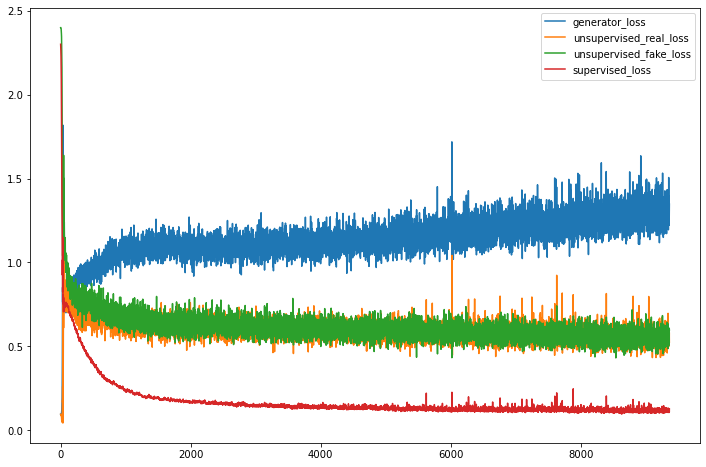

In [27]:
log_file.iloc[:, [0,1,2,3]].plot(figsize=(12,8))

<AxesSubplot:>

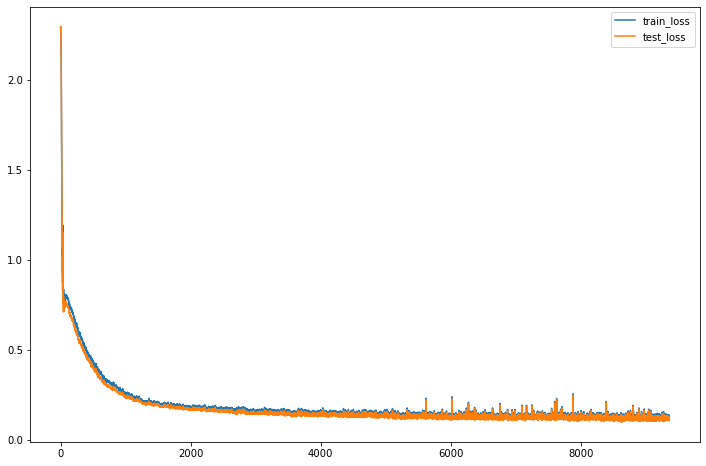

In [28]:
log_file.iloc[:, [5,6]].plot(figsize=(12,8))

<AxesSubplot:>

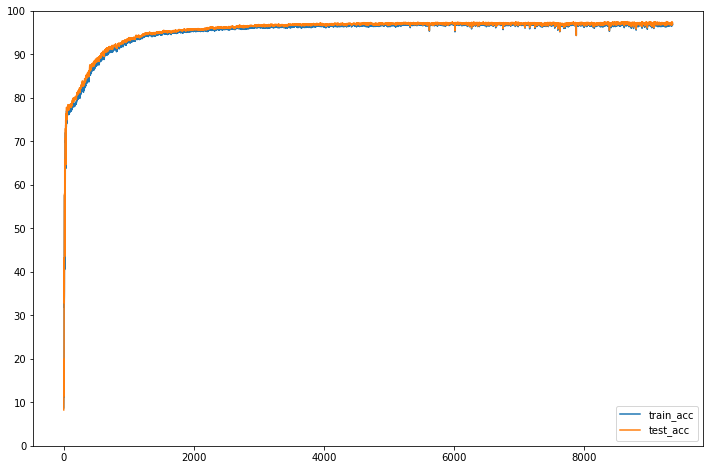

In [29]:
log_file.iloc[:, [7,8]].plot(figsize=(12,8), ylim=(0,100), yticks=range(0,110,10))